## 1. Introduction
This notebook processes and analyzes data comparing real user responses with responses generated by a Large Language Model (LLM). It includes data loading, LLM response generation, and comparison of the LLM responses to real user responses.

## 2. Importing Necessary Libraries and Helper Functions


In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sns
class PublicationStyle:
    """
    A class to maintain consistent styling across scientific publication visualizations.
    """
    
    # Color palettes
    MAIN_COLORS = {
        'primary': '#4F1787',
        'secondary': '#FB773C',
        'tertiary': '#7A24A1',
        'quaternary': '#FB4E56',
        'accent1': '#180161',
        'accent2': '#FDAA62',
        'accent3': '#B73AB3',
        'accent4': '#EB3678'
    }
    
    PALETTE = list(MAIN_COLORS.values())
    
    GRADIENT_COLORS = ['#FDAA62', '#FB773C', '#FB4E56', '#EB3678', 
                      '#B73AB3', '#7A24A1', '#4F1787', '#180161']
    
    GRADIENT_CMAP = clr.LinearSegmentedColormap.from_list('custom', GRADIENT_COLORS)
    
    # Font sizes
    FONT_SIZES = {
        'tiny': 8,
        'small': 10,
        'medium': 12,
        'large': 14,
        'xlarge': 16,
        'title': 16,
        'subtitle': 14,
        'axis_label': 12,
        'tick_label': 10,
        'legend': 10,
        'annotation': 9
    }
    
    @classmethod
    def set_style(cls):
        """Set the default style for all visualizations."""
        # Set basic seaborn style
        sns.set_theme(style="whitegrid", font='Arial')
        
        # Set default parameters
        plt.rcParams.update({
            # Font settings
            'font.size': cls.FONT_SIZES['medium'],
            
            # Figure settings
            'figure.figsize': (8, 6),
            'figure.dpi': 300,
            
            # Axes settings
            'axes.titlesize': cls.FONT_SIZES['title'],
            'axes.labelsize': cls.FONT_SIZES['axis_label'],
            'axes.grid': True,
            'grid.alpha': 0.3,
            
            # Tick settings
            'xtick.labelsize': cls.FONT_SIZES['tick_label'],
            'ytick.labelsize': cls.FONT_SIZES['tick_label'],
            
            # Legend settings
            'legend.fontsize': cls.FONT_SIZES['legend'],
            'legend.title_fontsize': cls.FONT_SIZES['legend'],
            'legend.frameon': True,
            'legend.framealpha': 0.8,
            'legend.edgecolor': 'black',
            
            # Lines and markers
            'lines.linewidth': 2,
            'lines.markersize': 8
        })
    
    @classmethod
    def format_axis(cls, ax, title=None, xlabel=None, ylabel=None, 
                   xticks=None, yticks=None, rotation=0):
        """Format a single axis with consistent styling."""
        if title:
            ax.set_title(title, pad=20, fontweight='bold')
        if xlabel:
            ax.set_xlabel(xlabel)
        if ylabel:
            ax.set_ylabel(ylabel)
        if xticks is not None:
            ax.set_xticks(xticks[0])
            ax.set_xticklabels(xticks[1], rotation=rotation)
        if yticks is not None:
            ax.set_yticks(yticks[0])
            ax.set_yticklabels(yticks[1])
        
        # Add subtle grid
        ax.grid(True, alpha=0.3)
        
        # Style spines
        for spine in ax.spines.values():
            spine.set_linewidth(1)
            spine.set_color('black')
    
    @classmethod
    def add_figure_labels(cls, fig, labels=None):
        """Add subplot labels (a, b, c, etc.) to figure."""
        if labels is None:
            labels = list('abcdefghijklmnopqrstuvwxyz')
        
        for n, ax in enumerate(fig.axes):
            if n < len(labels):
                ax.text(-0.1, 1.1, f'({labels[n]})', transform=ax.transAxes, 
                       size=14, weight='bold')

    @classmethod
    def save_figure(cls, fig, filename, dpi=300, bbox_inches='tight'):
        """Save figure with consistent settings."""
        fig.savefig(filename, dpi=dpi, bbox_inches=bbox_inches)
        
def transform_data_with_question_codes(filtered_data_path, question_codes_path):
    """
    Transforms the filtered data by replacing question codes with actual question text
    and answer values with the corresponding answer text based on the question_codes.json file.

    Parameters:
    filtered_data_path (str): Path to the CSV file with the filtered data.
    question_codes_path (str): Path to the question_codes.json file.

    Returns:
    pd.DataFrame: A transformed DataFrame with question text as column headers and answer text as values.
    """

    # Load the filtered data
    filtered_data = pd.read_csv(filtered_data_path)

    # Load the question_codes.json file
    with open(question_codes_path) as f:
        question_data = json.load(f)

    # Create mappings for question codes to question text
    code_to_question = {item['code']: item['question'] for item in question_data}

    # Create mappings for each question's options
    code_to_options = {item['code']: item['options'] for item in question_data}

    # Step 1: Rename the columns using the question text
    filtered_data.rename(columns=code_to_question, inplace=True)

    # Step 2: Replace the values with the answer text
    for code, options in code_to_options.items():
        question_text = code_to_question.get(code)  # Get the question text mapped to this code
        if question_text in filtered_data.columns:
            # Convert numeric responses to strings before mapping
            filtered_data[question_text] = filtered_data[question_text].astype(str).map(options)

    return filtered_data
def filter_data():
    # Read the data from ../data/raw/overall_filtered_us_data.csv
    data = pd.read_csv('../data/raw/overall_filtered_us_data.csv', low_memory=False)

    # Read the user ids from ../data/processed/combined_data.csv
    user_ids = pd.read_csv('../data/processed/combined_data.csv')['user']

    # Filter the data to only include rows with user ids present in combined_data.csv
    data = data[data['unique_id'].isin(user_ids)]

    # Read the question codes from ../data/raw/question_codes.json
    question_codes = pd.read_json('../data/raw/question_codes.json')['code']
    columns_to_keep = ['unique_id'] + list(question_codes)
    data = data[columns_to_keep]

    data.set_index('unique_id', inplace=True)
    data.drop(["F2A14", 'F1A9_1', 'F1A13_1', 'F1A16_1', 'F2A8', 'F3A5_1'], axis=1, inplace=True)

    return data

filtered_data = filter_data()




In [362]:
filtered_data.head() 

F1A10_1  F2A6  F2A7  F2A9  F3A3_1  F3A6_1  F3A7_1  F3A8_1
unique_id                                                            
IDUS103408        2     3     3     2       6       4       4       7
IDUS103554        7     5     2     5       7       1       1       1
IDUS103826        4     1     1     4       7       1       3       4
IDUS104424        5     4     3     4       7       1       2       2
IDUS104578        6     5     2     4       6       1       3       2

In [363]:
filtered_data.to_csv('../data/raw/filtered_data.csv')

## 3. Data Loading and Preprocessing


In [364]:
encoded_data_path = '../data/raw/filtered_data.csv'
question_codes_path = '../data/raw/question_codes.json'
decoded_data = transform_data_with_question_codes(encoded_data_path, question_codes_path)

### Actual Human Responses

In [365]:
decoded_data.head()

unique_id I feel like I am treated fairly by politicians.  \
0  IDUS103408                                           Agree   
1  IDUS103554                             Completely disagree   
2  IDUS103826                      Neither agree nor disagree   
3  IDUS104424                         Disagree to some extent   
4  IDUS104578                                        Disagree   

  To what degree does this concern you: The fact that the US is getting more deeply involved in the war in Ukraine  \
0                               moderately concerned                                                                 
1                                     very concerned                                                                 
2                               not concerned at all                                                                 
3                                    quite concerned                                                                 
4                                     very concerned                                                                 

  To what degree does this concern you: The situation of Ukrainian refugees in the US  \
0                               moderately concerned                                    
1                                 not very concerned                                    
2                               not concerned at all                                    
3                               moderately concerned                                    
4                                 not very concerned                                    

  To what degree does this concern you: The state of the US healthcare system  \
0                                 not very concerned                            
1                                     very concerned                            
2                                    quite concerned                            
3                                    quite concerned                            
4                                    quite concerned                            

  Agree or disagree: In the US, you can express your opinion publicly without fear of hostility  \
0                                           Disagree                                              
1                                Completely disagree                                              
2                                Completely disagree                                              
3                                Completely disagree                                              
4                                           Disagree                                              

  Agree or disagree: We no longer have room in the US for refugees from countries other than Ukraine  \
0                         Neither agree nor disagree                                                   
1                                   Completely agree                                                   
2                                   Completely agree                                                   
3                                   Completely agree                                                   
4                                   Completely agree                                                   

  Agree or disagree: Foreigners exacerbate crime problems  \
0                         Neither agree nor disagree        
1                                   Completely agree        
2                               Agree to some extent        
3                                              Agree        
4                               Agree to some extent        

  Agree or disagree: Foreigners are taking jobs away from Americans  
0                                Completely disagree                 
1                                   Completely agree                 
2                         Neither agree nor disagree                 
3              

### Generating Prompts For the LLMs 
(Based on the questions asked to the real people)

In [366]:
def generate_prompts_from_questions(question_codes_path):
    """
    Generates prompt strings for each question and its corresponding options from the question_codes.json file,
    excluding questions with specific codes.

    Parameters:
    question_codes_path (str): Path to the question_codes.json file.

    Returns:
    List[str]: A list of formatted prompts, each containing the question and its available options.
    """

    # List of question codes to exclude
    excluded_codes = ["F2A14", 'F1A9_1', 'F1A13_1', 'F1A16_1', 'F2A8', 'F3A5_1']

    # Load the question_codes.json file
    with open(question_codes_path) as f:
        question_data = json.load(f)

    prompts = []

    # Loop over each question in the JSON data
    for item in question_data:
        question_code = item.get('code')  # Assuming each question has a 'code' key
        question = item['question']
        options = item['options']

        # Skip questions whose codes are in the excluded list
        if question_code in excluded_codes:
            print(f"Skipping question with code: {question_code}")
            continue

        # Format the question and options as a readable string (no numbers involved)
        prompt = f"Based on your background and beliefs as described, respond to this question by selecting ONLY ONE of the provided options. Any answer not using exactly one of these options will be considered invalid.\n**Question**: {question}\n**Options** (choose ONE):\n"
        for option_text in options.values():
            prompt += f"- {option_text}\n"

        prompts.append(prompt.strip())  # Add the formatted prompt to the list

    return prompts


In [367]:
prompts = generate_prompts_from_questions(question_codes_path)
prompts[:5]

Skipping question with code: F1A9_1
Skipping question with code: F1A13_1
Skipping question with code: F1A16_1
Skipping question with code: F2A8
Skipping question with code: F2A14
Skipping question with code: F3A5_1


['Based on your background and beliefs as described, respond to this question by selecting ONLY ONE of the provided options. Any answer not using exactly one of these options will be considered invalid.\n**Question**: I feel like I am treated fairly by politicians.\n**Options** (choose ONE):\n- Completely agree\n- Agree\n- Agree to some extent\n- Neither agree nor disagree\n- Disagree to some extent\n- Disagree\n- Completely disagree',
 'Based on your background and beliefs as described, respond to this question by selecting ONLY ONE of the provided options. Any answer not using exactly one of these options will be considered invalid.\n**Question**: To what degree does this concern you: The fact that the US is getting more deeply involved in the war in Ukraine\n**Options** (choose ONE):\n- not concerned at all\n- not very concerned\n- moderately concerned\n- quite concerned\n- very concerned',
 'Based on your background and beliefs as described, respond to this question by selecting ON

### LLM Responses (Before exposure to biased articles)

In [368]:
def save_responses_to_file(output_file, responses):
    """
    Saves the list of responses to a JSON file.
    If the file exists, it appends the new responses to the existing data.
    """
    try:
        with open(output_file, 'r') as file:
            existing_data = json.load(file)
            responses = existing_data + responses
    except FileNotFoundError:
        pass  # If the file doesn't exist, we will create it later

    with open(output_file, 'w') as outfile:
        json.dump(responses, outfile, indent=4)


In [369]:
import logging
import re

class CustomOutputParser:
    def __init__(self):
        # Combined list of all predefined options, sorted by length (longest first to avoid partial matches)
        self.target_keys = sorted([
            # Agreement options
            'Completely agree', 'Agree', 'Agree to some extent', 'Neither agree nor disagree',
            'Disagree to some extent', 'Disagree', 'Completely disagree',
            # Concern levels
            'not concerned at all', 'not very concerned', 'moderately concerned',
            'quite concerned', 'very concerned'
        ], key=len, reverse=True)  # Sort by length to prioritize longer options

    def parse(self, output: str) -> dict:
        try:
            # Attempt to extract the exact option
            selected_option = self.extract_option(output)
            logging.debug(f"Extracted option: {selected_option}")

            # Handle case when no valid option is found
            if selected_option is None:
                logging.warning("No valid option found in the output.")
                selected_option = "N/A"

            return {
                "type": "final_answer",
                "selected_option": selected_option.strip()
            }
        except Exception as e:
            logging.error(f"Error parsing LLM output: {e}")
            return {"type": "raw_output", "content": output.strip()}

    def extract_option(self, text: str) -> str:
        # Normalize the text (remove extra spaces, lowercase for comparison)
        normalized_text = text.strip().lower()

        # Check for exact matches of predefined options in the raw output
        for option in self.target_keys:
            # Use word boundaries to ensure we're matching the whole phrase
            pattern = re.compile(r'\b' + re.escape(option.lower()) + r'\b')
            if pattern.search(normalized_text):
                return option  # Return the exact matched option

        # No valid option found
        return None

# Ensure logging is set up to show debug information
logging.basicConfig(level=logging.DEBUG)


In [370]:
import json
import os
from llm import CustomLLM

def load_json_file(file_path):
    """ Load data from a JSON file. """
    with open(file_path, 'r') as file:
        return json.load(file)


def load_processed_responses(output_file):
    """ Load the already processed responses from the file. """
    processed_responses = {}
    
    if os.path.exists(output_file):
        with open(output_file, 'r') as f:
            try:
                existing_data = json.load(f)
                # Ensure the file contains a list of responses
                if isinstance(existing_data, list):
                    for response_data in existing_data:
                        user_id = response_data.get('user_id')
                        question = response_data.get('question')

                        if user_id and question:
                            if user_id not in processed_responses:
                                processed_responses[user_id] = set()
                            processed_responses[user_id].add(question)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}. Skipping invalid data in {output_file}.")
    
    return processed_responses

def append_responses_to_file(output_file, user_responses):
    """ Append the user responses to the output file, ensuring correct JSON formatting. """
    if os.path.exists(output_file):
        try:
            with open(output_file, 'r+') as f:
                try:
                    existing_data = json.load(f)
                    if not isinstance(existing_data, list):
                        print(f"Error: {output_file} contains invalid JSON format. Overwriting with new data.")
                        existing_data = []
                except json.JSONDecodeError:
                    print(f"Error: {output_file} contains invalid JSON. Overwriting with new data.")
                    existing_data = []
                
                # Append new responses to the existing data
                existing_data.extend(user_responses)
                
                # Move file pointer to the beginning to overwrite
                f.seek(0)
                json.dump(existing_data, f, indent=4)
                f.truncate()  # Ensure no leftover content
        except IOError as e:
            print(f"Error writing to file {output_file}: {e}")
    else:
        # If the file doesn't exist, create it and write the responses
        with open(output_file, 'w') as f:
            json.dump(user_responses, f, indent=4)

def get_agents_responses():
    # Load persona prompts
    persona_prompts = load_json_file('../data/processed/persona_prompts.json')

    # Load the new question prompts
    question_prompts = generate_prompts_from_questions('../data/raw/question_codes.json')

    # Initialize the LLM and output parser
    llm = CustomLLM(model="llama3.1:70b-instruct-q6_K", api_url="https://inf.cl.uni-trier.de/")
    parser = CustomOutputParser()

    # Load previously processed responses
    output_file = '../data/processed/before_responses.json'
    processed_responses = load_processed_responses(output_file)

    # Iterate through persona prompts and new question prompts
    for persona in persona_prompts:
        persona_prompt = persona["persona_prompt"]
        user_id = persona["user_id"]

        # Check if the user has been processed before
        if user_id not in processed_responses:
            processed_responses[user_id] = set()

        user_responses = []

        for question_prompt in question_prompts:
            # Skip if this user-question pair has already been processed
            if question_prompt in processed_responses[user_id]:
                print(f"Skipping already processed User ID: {user_id}, Question: {question_prompt}")
                continue

            # Send persona prompt and question prompt to LLM
            response = llm.generate_response(persona_prompt, question_prompt)
            parsed_output = parser.parse(response)
            
            # Output the raw and parsed response for inspection
            print(f"User ID: {user_id}")
            print("Raw output:")
            print(response)
            print("Parsed output:")
            print(parsed_output)

            # Collect the responses for the current user
            user_responses.append({
                "user_id": user_id,
                "question": question_prompt,
                "response": parsed_output
            })
            # Mark this question as processed for this user
            processed_responses[user_id].add(question_prompt)
        
        # Append the user responses to the file after each user is processed
        append_responses_to_file(output_file, user_responses)


In [371]:
#get_agents_responses()


### Save Before Responses

In [372]:
import json

# Load the LLM responses from the file
llm_responses_path = '../data/processed/before_responses.json'  # Update with the correct path

with open(llm_responses_path, 'r', encoding="utf-8") as f:
    llm_responses = json.load(f)  # Load the entire file as a JSON array

# Check if the LLM responses loaded correctly
print(f"Total LLM responses loaded: {len(llm_responses)}")
print(llm_responses[:2])  # Display the first two responses to inspect the structure


Total LLM responses loaded: 936
[{'user_id': 'IDUS103408', 'question': 'Based on your background and beliefs as described, respond to this question by selecting ONLY ONE of the provided options. Any answer not using exactly one of these options will be considered invalid.\n**Question**: I feel like I am treated fairly by politicians.\n**Options** (choose ONE):\n- Completely agree\n- Agree\n- Agree to some extent\n- Neither agree nor disagree\n- Disagree to some extent\n- Disagree\n- Completely disagree', 'response': {'type': 'final_answer', 'selected_option': 'Completely disagree'}}, {'user_id': 'IDUS103408', 'question': 'Based on your background and beliefs as described, respond to this question by selecting ONLY ONE of the provided options. Any answer not using exactly one of these options will be considered invalid.\n**Question**: To what degree does this concern you: The fact that the US is getting more deeply involved in the war in Ukraine\n**Options** (choose ONE):\n- not concern

In [373]:
# Load the question codes JSON file
question_code_map_path = '../data/raw/question_codes.json'  # Update with the correct path
with open(question_code_map_path, 'r') as f:
    question_code_map = json.load(f)

# Check the structure of the question_code_map
print(f"Total question mappings loaded: {len(question_code_map)}")
print(question_code_map[:2])  # Display the first two mappings to inspect the structure


Total question mappings loaded: 14
[{'code': 'F1A9_1', 'question': 'I feel very angry when I think about the current situation.', 'options': {'1': 'Completely agree', '2': 'Agree', '3': 'Agree to some extent', '4': 'Neither agree nor disagree', '5': 'Disagree to some extent', '6': 'Disagree', '7': 'Completely disagree'}}, {'code': 'F1A10_1', 'question': 'I feel like I am treated fairly by politicians.', 'options': {'1': 'Completely agree', '2': 'Agree', '3': 'Agree to some extent', '4': 'Neither agree nor disagree', '5': 'Disagree to some extent', '6': 'Disagree', '7': 'Completely disagree'}}]


### Encode LLMs Before Responses to their code for comparison

In [374]:
import re

# Function to extract the actual question from the LLM's full question text
def extract_question_from_llm_text(llm_question_text):
    # Use regex to capture the text after '**Question**:'
    match = re.search(r'\*\*Question\*\*: (.+?)\n', llm_question_text)
    if match:
        return match.group(1).strip()
    return None


In [375]:
def map_llm_response_to_code(question_code, response_text):
    """
    Maps the LLM's textual response to the corresponding code based on the question code.
    """
    # Iterate through the list to find the matching question_code
    for entry in question_code_map:
        if entry['code'] == question_code:
            options = entry.get('options', {})  # Safely get options if available
            for code, option in options.items():
                if option.lower() == response_text.lower():
                    return int(code)
    return None  # Return None if no matching code is found


In [376]:
print(filtered_data.head())

            F1A10_1  F2A6  F2A7  F2A9  F3A3_1  F3A6_1  F3A7_1  F3A8_1
unique_id                                                            
IDUS103408        2     3     3     2       6       4       4       7
IDUS103554        7     5     2     5       7       1       1       1
IDUS103826        4     1     1     4       7       1       3       4
IDUS104424        5     4     3     4       7       1       2       2
IDUS104578        6     5     2     4       6       1       3       2


In [377]:
# Map LLM responses to numeric codes
llm_responses_mapped = []
for response in llm_responses:
    extracted_question = extract_question_from_llm_text(response["question"])
    if not extracted_question:
        continue

    matched = False
    for entry in question_code_map:
        if extracted_question.lower() == entry['question'].lower():  # Compare case-insensitively
            question_code = entry['code']
            matched = True
            break
     
    #if matched:

        #print(f"Matched question: {extracted_question} with code: {question_code}")  # Debug print
    #else:
        #print(f"No match found for question: {extracted_question}")  # Debug print

    # Map the LLM's response to a numeric code
    mapped_code = map_llm_response_to_code(question_code, response['response']['selected_option'])
    if mapped_code is not None:
        llm_responses_mapped.append({
            'user_id': response['user_id'],
            'question_code': question_code,
            'llm_response_code': mapped_code
        })


In [378]:
def map_llm_response_to_code(question_code, response_text):
    for entry in question_code_map:
        if entry['code'] == question_code:
            options = entry.get('options', {})
            for code, option in options.items():
                if option.lower() == response_text.lower():
                    #print(f"Mapped response '{response_text}' to code: {code}")  # Debug print
                    return int(code)
    print(f"Failed to map response '{response_text}' for question code: {question_code}")  # Debug print
    return None


In [379]:
mapped_code = map_llm_response_to_code(question_code, response['response']['selected_option'])


#### Combining mapped questions and Mapped answer codes
Both questions and answers are now mapped back to their codes

In [380]:
# Initialize a list to store all mapped responses from LLM
llm_responses_mapped = []

# Iterate through all LLM responses
for response in llm_responses:
    user_id = response['user_id']  # Each user will have their own unique ID
    extracted_question = extract_question_from_llm_text(response["question"])  # Extract the question from the LLM response
    
    if not extracted_question:
        continue  # Skip if question extraction failed

    matched = False  # Track if we successfully matched the question
    for entry in question_code_map:
        if extracted_question.lower() == entry['question'].lower():
            question_code = entry['code']  # Get the code for the matched question
            matched = True
            break
    
    # If a matching question is found, map the LLM's response to a numeric code
    if matched:
        #print(f"Matched question: {extracted_question} with code: {question_code}")

        # Map the LLM's response to a numeric code based on the options in question_code_map
        mapped_code = map_llm_response_to_code(question_code, response['response']['selected_option'].strip())

        if mapped_code is not None:
            # Store the mapped response with the user ID and question code
            llm_responses_mapped.append({
                'user_id': user_id,  # Include user ID for each response
                'question_code': question_code,
                'llm_response_code': mapped_code
            })
            #print(f"Mapped response '{response['response']['selected_option']}' to code: {mapped_code} for user: {user_id}")
        else:
            print(f"Failed to map LLM response: '{response['response']['selected_option']}' for question: {question_code} and user: {user_id}")
    else:
        #print(f"No match found for extracted question: {extracted_question}")
        continue

# Print total mapped responses and some of the mapped responses for verification
print(f"\nTotal mapped responses: {len(llm_responses_mapped)}")
print(llm_responses_mapped[:5])  # Print the first 5 mapped responses to verify



Total mapped responses: 936
[{'user_id': 'IDUS103408', 'question_code': 'F1A10_1', 'llm_response_code': 7}, {'user_id': 'IDUS103408', 'question_code': 'F2A6', 'llm_response_code': 4}, {'user_id': 'IDUS103408', 'question_code': 'F2A7', 'llm_response_code': 1}, {'user_id': 'IDUS103408', 'question_code': 'F2A9', 'llm_response_code': 2}, {'user_id': 'IDUS103408', 'question_code': 'F3A3_1', 'llm_response_code': 1}]


### Comparing the LLM (Before) Responses with the Actual Human Responses

In [381]:
def weighted_difference(real_response_code, llm_response_code, weight=1):
    """
    Calculates the weighted difference between real and LLM response codes.
    
    Parameters:
    - real_response_code: The real response code (numeric or categorical).
    - llm_response_code: The response code generated by the LLM (numeric or categorical).
    - weight: A scaling factor for the difference. Defaults to 1 (no weighting).
    
    Returns:
    - The weighted difference between the real and LLM response codes.
    """
    # Ensure the codes are comparable by converting them to float (if they are numeric)
    try:
        real_response_code = float(real_response_code)
        llm_response_code = float(llm_response_code)
    except ValueError:
        # If not numeric, calculate difference as 1 if codes are different, 0 if the same
        return weight if real_response_code != llm_response_code else 0
    
    # Calculate the absolute difference between the codes, weighted by the provided factor
    difference = abs(real_response_code - llm_response_code)
    return difference * weight


## 4. Comparing LLM Responses with Real User Data


In [382]:
import pandas as pd
import json

def weighted_difference(real_response_code, llm_response_code, weight=1):
    """
    Calculates the weighted difference between real and LLM response codes.
    
    Parameters:
    - real_response_code: The real response code (numeric or categorical).
    - llm_response_code: The response code generated by the LLM (numeric or categorical).
    - weight: A scaling factor for the difference. Defaults to 1 (no weighting).
    
    Returns:
    - The weighted difference between the real and LLM response codes.
    """
    # Ensure the codes are comparable by converting them to float (if they are numeric)
    try:
        real_response_code = float(real_response_code)
        llm_response_code = float(llm_response_code)
    except ValueError:
        # If not numeric, calculate difference as 1 if codes are different, 0 if the same
        return weight if real_response_code != llm_response_code else 0
    
    # Calculate the absolute difference between the codes, weighted by the provided factor
    difference = abs(real_response_code - llm_response_code)
    return difference * weight

def compare_llm_to_real(llm_responses_mapped, filtered_data):
    """
    Compare LLM responses to real responses and calculate the weighted differences.

    Parameters:
    - llm_responses_mapped (list): A list of LLM response dictionaries, where each dictionary contains
                                   'user_id', 'question_code', and 'llm_response_code'.
    - filtered_data (DataFrame): A pandas DataFrame containing real responses, with user_id as the index
                                 and question_code as the columns.

    Returns:
    - comparison_df (DataFrame): A pandas DataFrame containing the comparison results.
    - average_weighted_difference (float): The average weighted difference between LLM and real responses.
    """
    llm_vs_real_comparison = []

    # Iterate through the LLM responses
    for llm_response in llm_responses_mapped:
        user_id = llm_response['user_id']
        question_code = llm_response['question_code']
        llm_response_code = llm_response['llm_response_code']
        
        # Check if the user_id and question_code exist in filtered_data
        if user_id in filtered_data.index and question_code in filtered_data.columns:
            # Fetch the real response
            real_response = filtered_data.loc[user_id, question_code]
            
            # If real_response is a Series (multiple values), extract the first valid value
            if isinstance(real_response, pd.Series):
                real_response_code = real_response.iloc[0]  # Get the first value
            else:
                real_response_code = real_response
            
            # Check if the real response code is valid (not NaN)
            if pd.notna(real_response_code):
                # Calculate the weighted difference using the custom function
                difference = weighted_difference(real_response_code, llm_response_code)
                
                # Store the comparison
                llm_vs_real_comparison.append({
                    'user_id': user_id,
                    'question_code': question_code,
                    'llm_response_code': llm_response_code,
                    'real_response_code': real_response_code,
                    'difference': difference
                })

    # Convert the comparison results to a DataFrame for analysis
    comparison_df = pd.DataFrame(llm_vs_real_comparison)

    # Calculate the average weighted difference
    if not comparison_df.empty:
        average_weighted_difference = comparison_df['difference'].mean()
    else:
        average_weighted_difference = None  # Handle the case where there's no valid comparison

    return comparison_df, average_weighted_difference


# Example Usage:

# llm_responses_mapped = [ ... ] # Your list of LLM responses mapped
# filtered_data = pd.DataFrame(...)  # Your filtered real data in a DataFrame

# Call the function
comparison_df, avg_difference = compare_llm_to_real(llm_responses_mapped, filtered_data)

# Display results
print(comparison_df.head())
print(f"Average weighted difference between LLM and real responses: {avg_difference}")
comparison_df.to_csv('../data/processed/llm_vs_real_comparison_before.csv', index=False)


      user_id question_code  llm_response_code  real_response_code  difference
0  IDUS103408       F1A10_1                  7                   2         5.0
1  IDUS103408          F2A6                  4                   3         1.0
2  IDUS103408          F2A7                  1                   3         2.0
3  IDUS103408          F2A9                  2                   2         0.0
4  IDUS103408        F3A3_1                  1                   6         5.0
Average weighted difference between LLM and real responses: 1.7297008547008548


In [383]:
comparison_df.question_code.unique()

array(['F1A10_1', 'F2A6', 'F2A7', 'F2A9', 'F3A3_1', 'F3A6_1', 'F3A7_1',
       'F3A8_1'], dtype=object)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\miria\AppData\Local\Temp\ipykernel_22360\2032215980.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='difference', data=comparison_df, palette=PublicationStyle.PALETTE, ax=ax)
C:\Users\miria\AppData\Local\Temp\ipykernel_22360\2032215980.py:6: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.countplot(x='difference', data=comparison_df, palette=PublicationStyle.PALETTE, ax=ax)
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate 

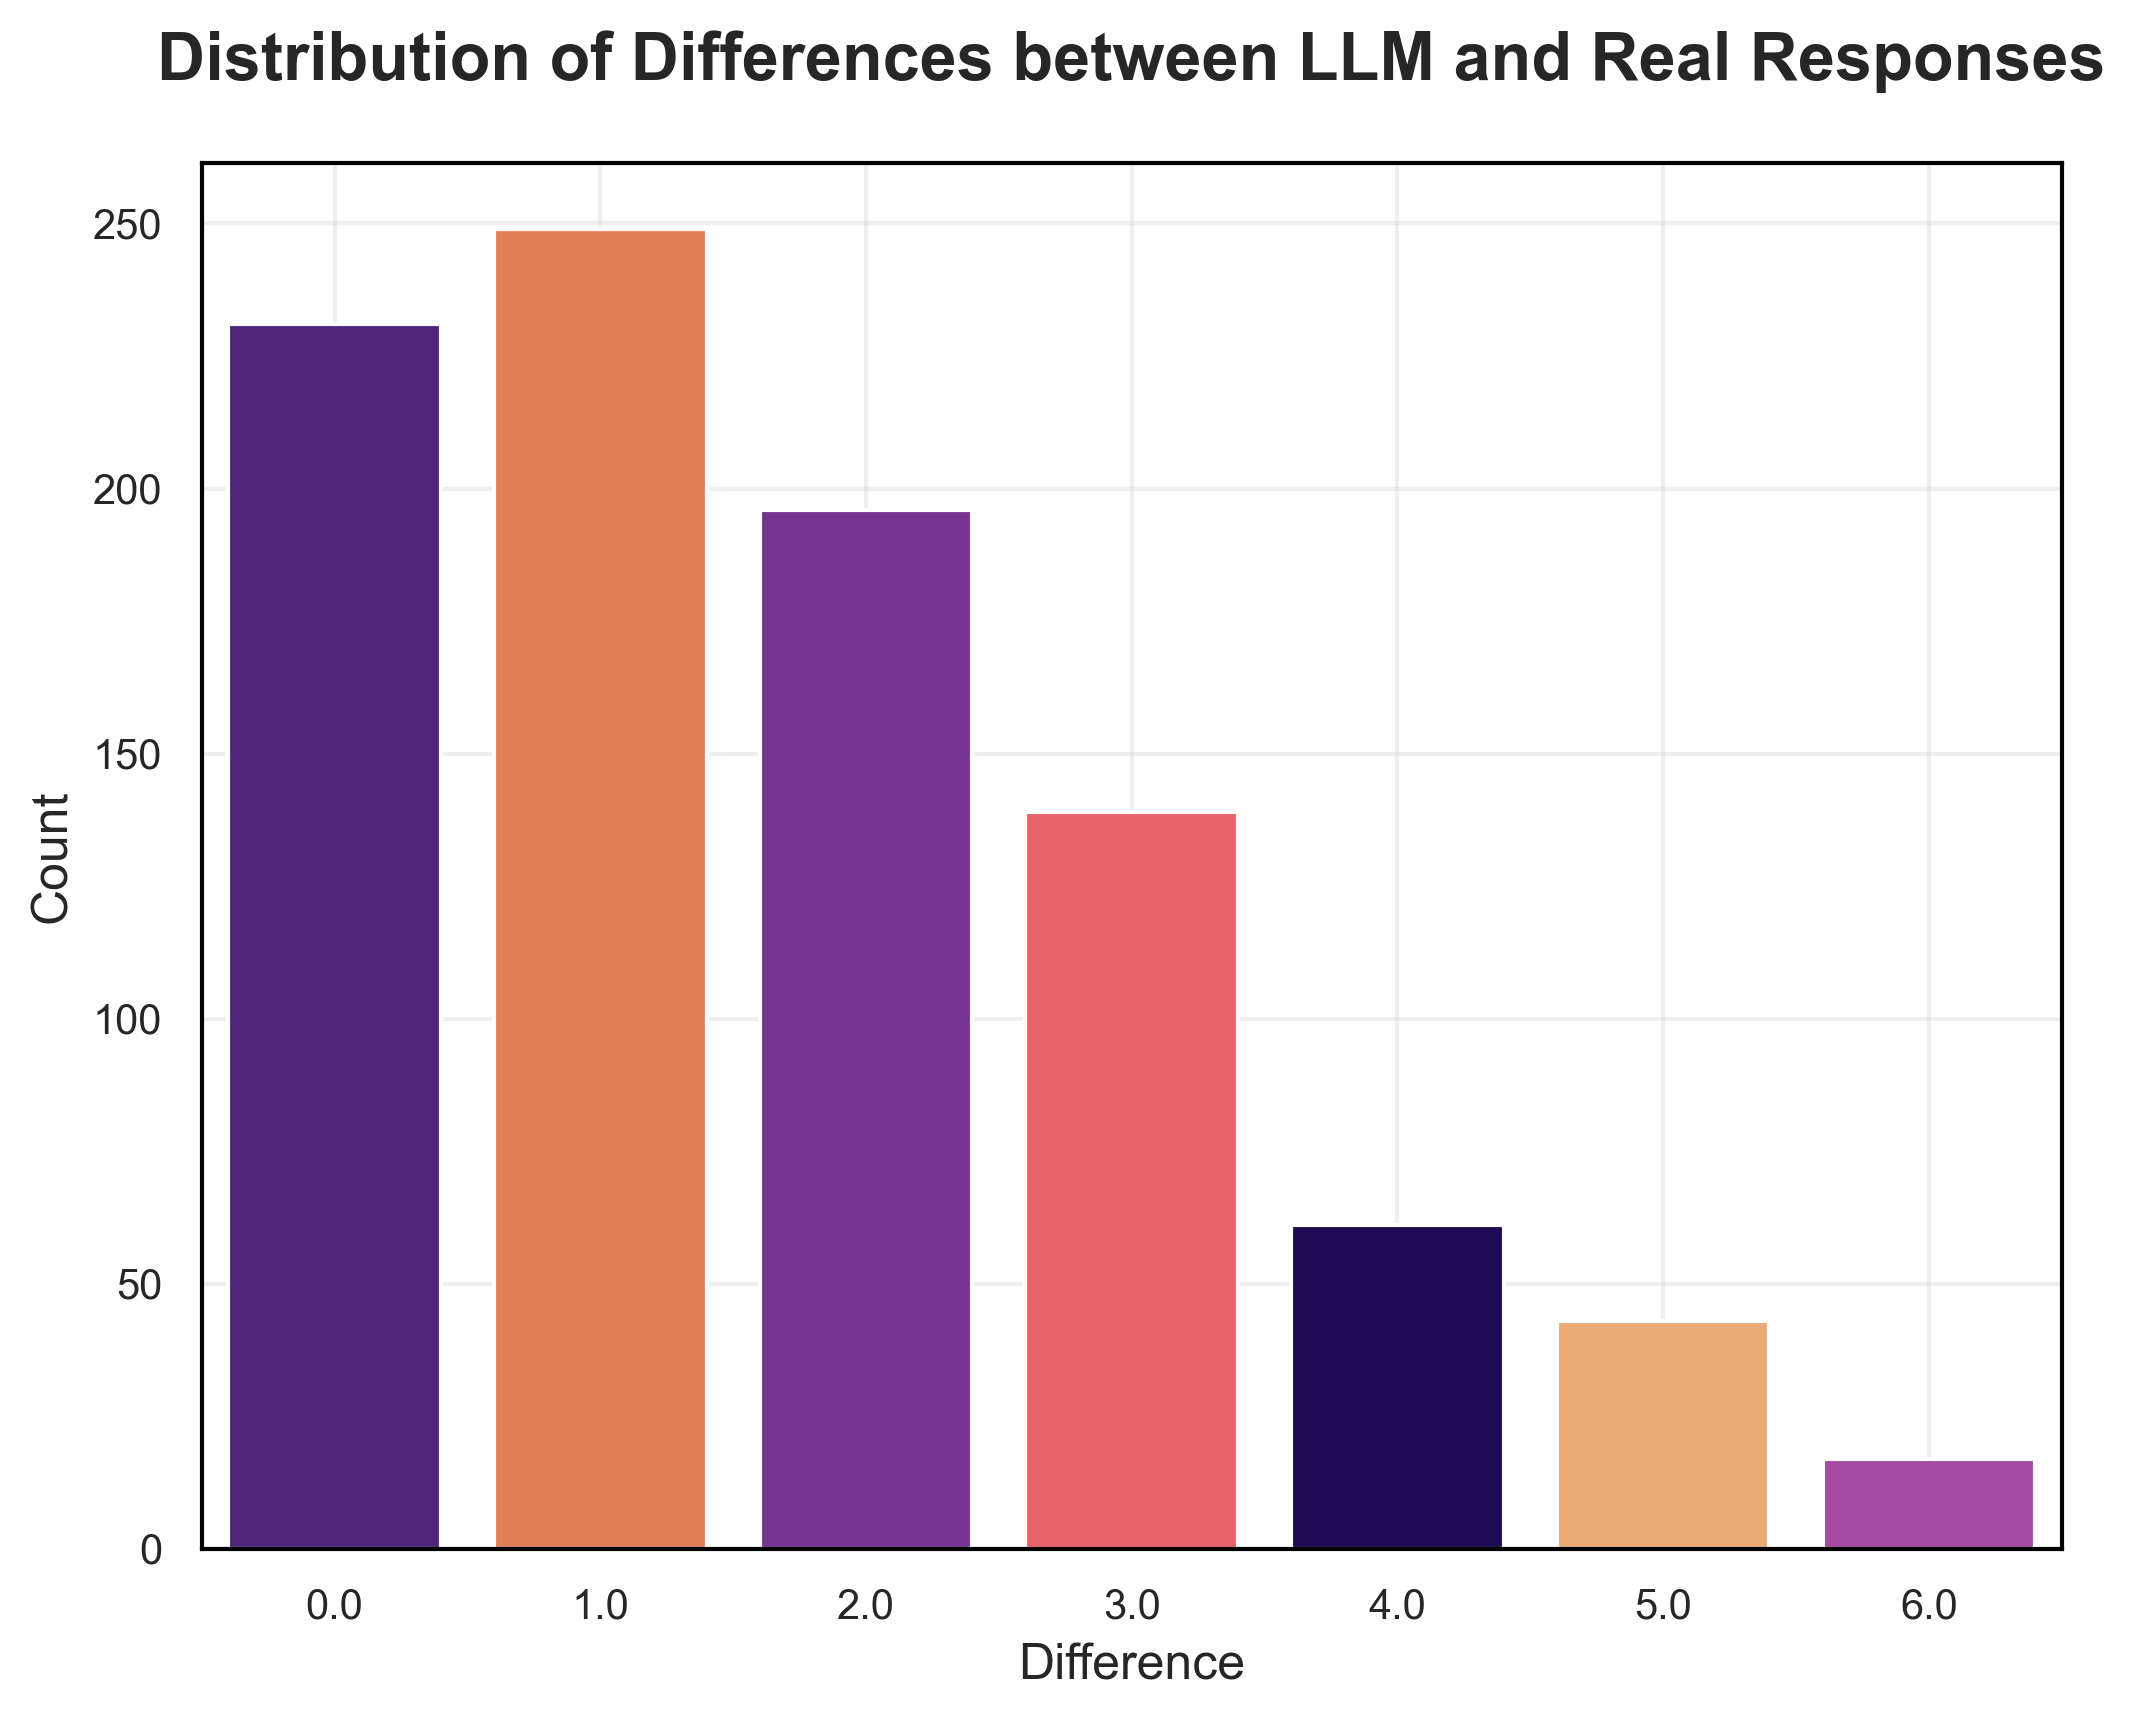

In [384]:
# Apply the PublicationStyle
PublicationStyle.set_style()

# Plot distribution of differences with PublicationStyle
fig, ax = plt.subplots(figsize=(8, 6))  # Ensure consistent figure size
sns.countplot(x='difference', data=comparison_df, palette=PublicationStyle.PALETTE, ax=ax)

# Use PublicationStyle to format the axis
PublicationStyle.format_axis(
    ax,
    title='Distribution of Differences between LLM and Real Responses',
    xlabel='Difference',
    ylabel='Count'
)

# Show the plot
plt.show()


#### How far away are the LLM responses from the real responses (By question)?

## 5. Results Analysis and Average Weighted Difference


C:\Users\miria\AppData\Local\Temp\ipykernel_22360\3988813839.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


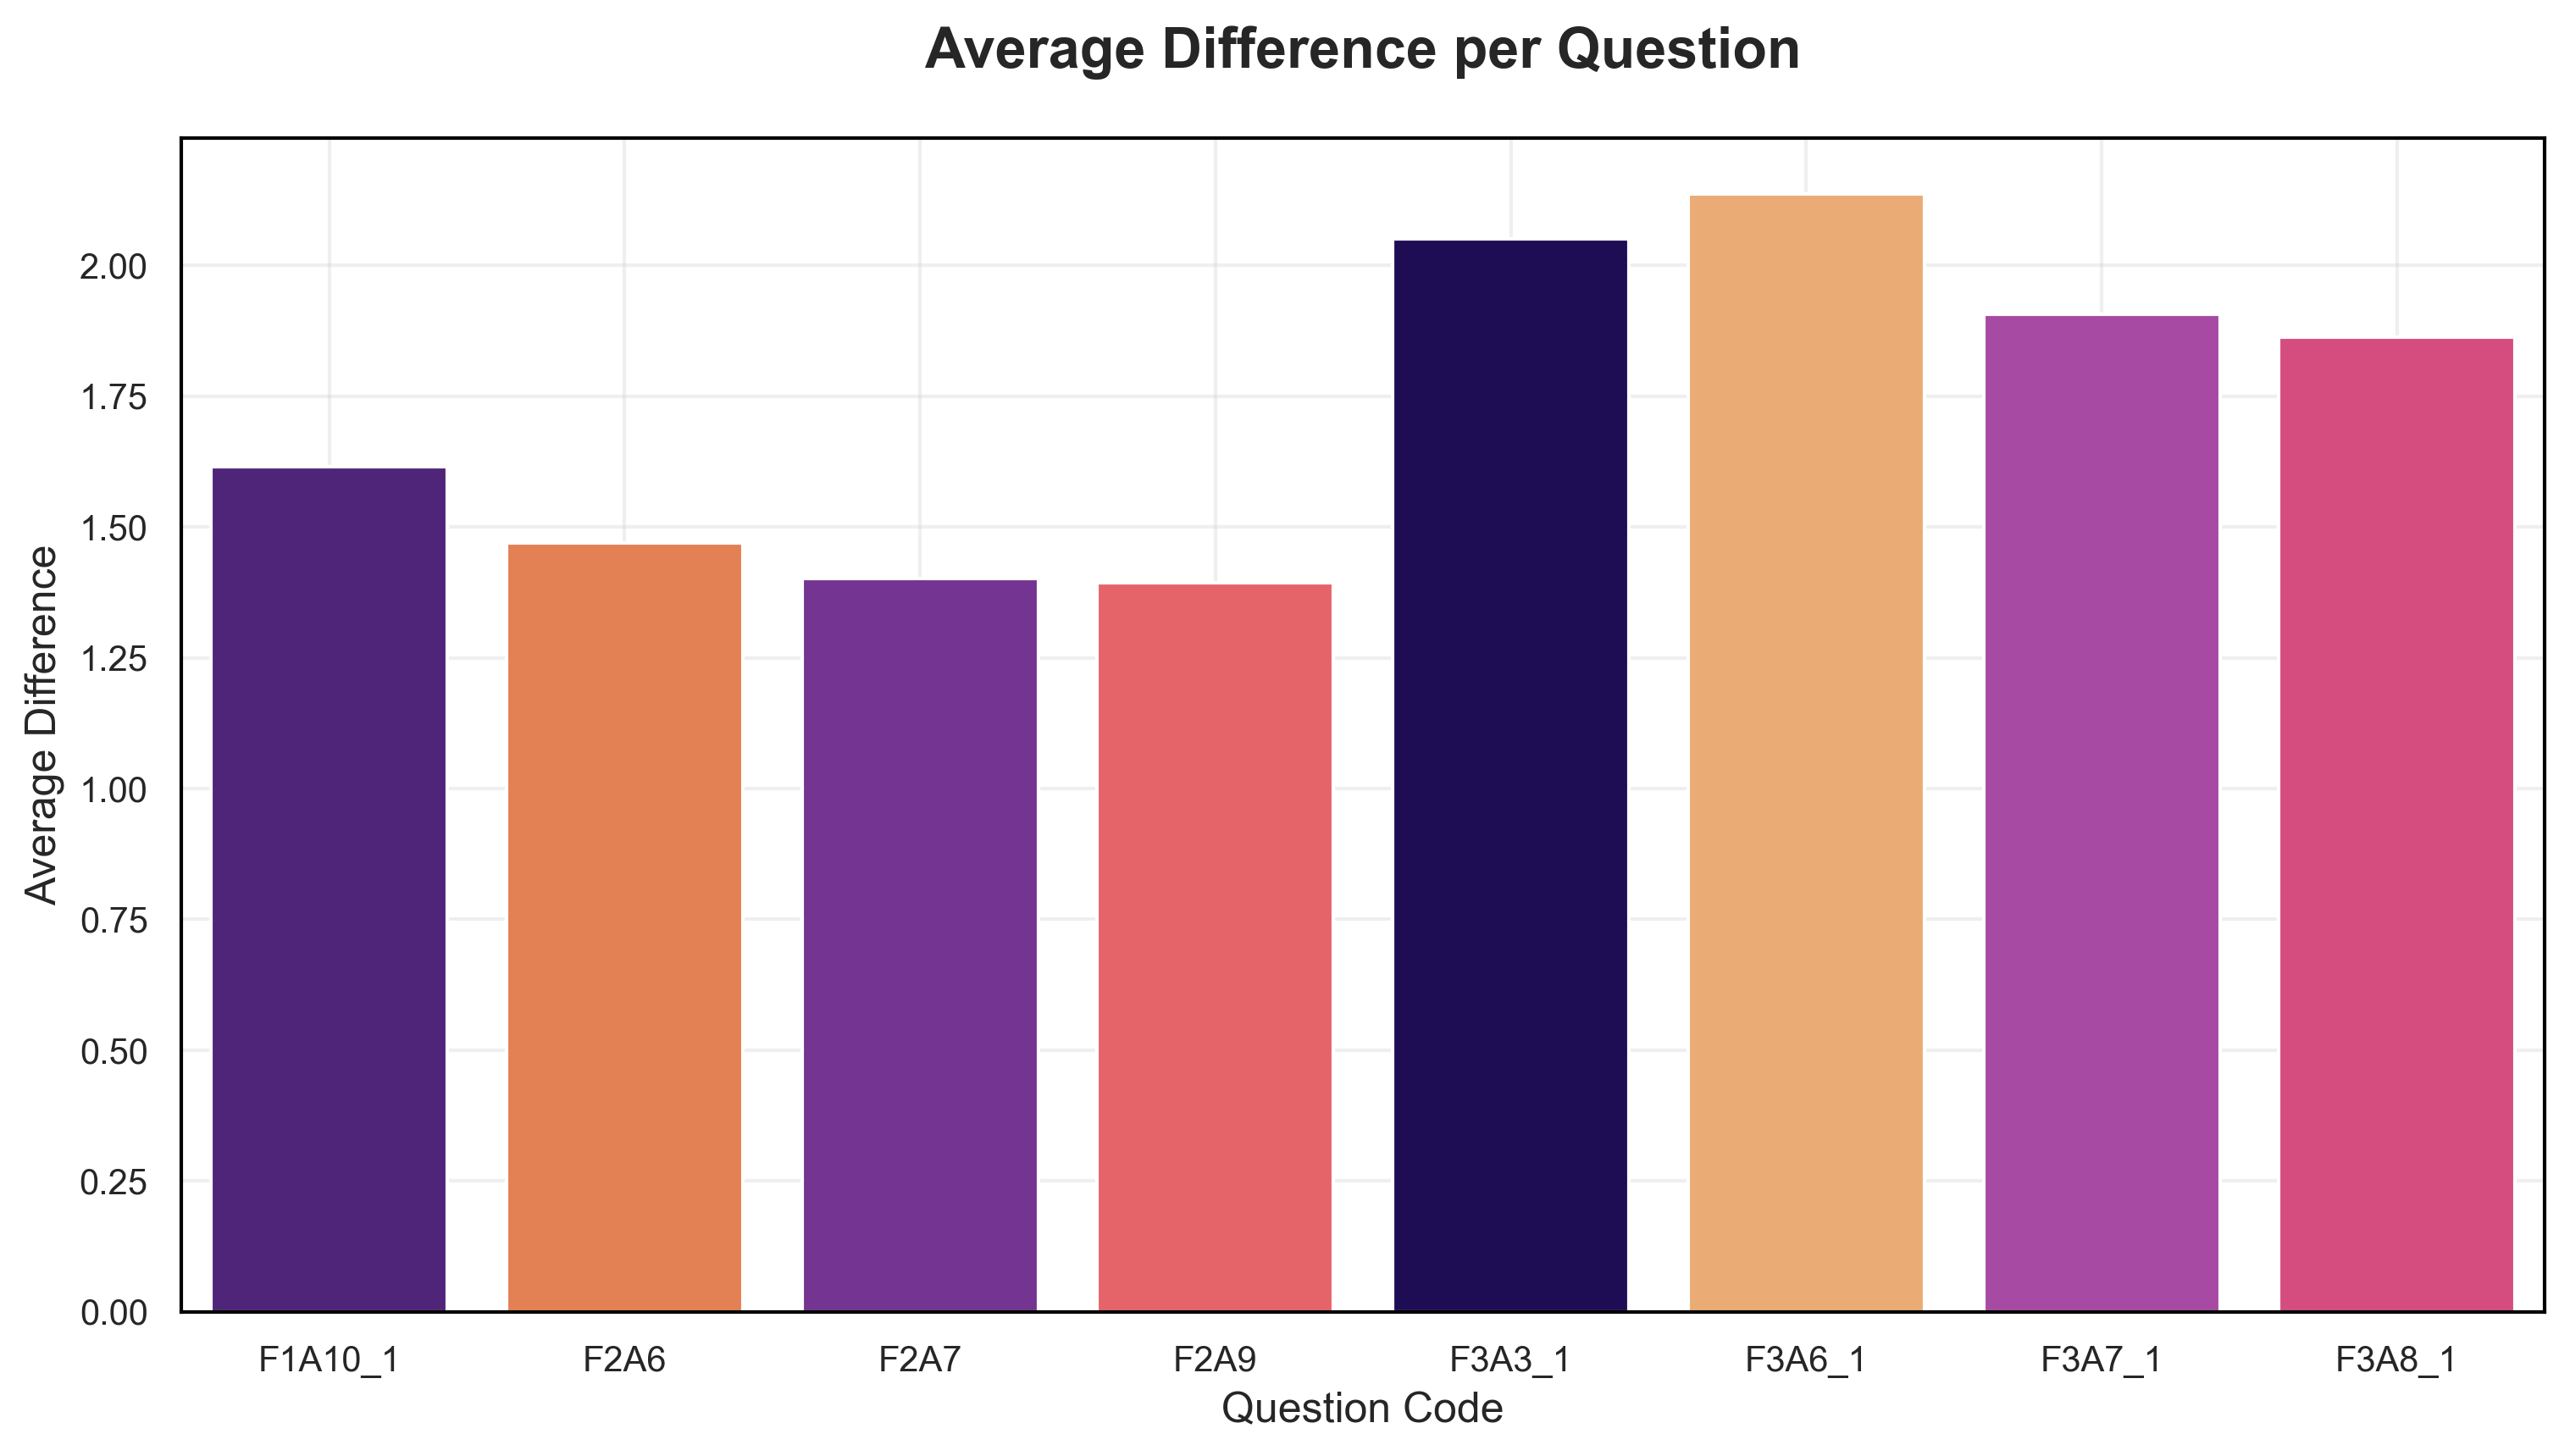

In [385]:
# Apply the PublicationStyle
PublicationStyle.set_style()

# Calculate the average difference per question
question_differences = comparison_df.groupby('question_code')['difference'].mean().reset_index()

# Plot average difference per question with PublicationStyle
fig, ax = plt.subplots(figsize=(12, 6))  # Ensure consistent figure size
sns.barplot(
    x='question_code',
    y='difference',
    data=question_differences,
    palette=PublicationStyle.PALETTE,
    ax=ax
)

# Use PublicationStyle to format the axis
PublicationStyle.format_axis(
    ax,
    title='Average Difference per Question',
    xlabel='Question Code',
    ylabel='Average Difference',
    rotation=45  # Rotate x-axis labels for readability
)

# Show the plot
plt.show()


In [386]:
## THIS NEEDS TO BE CHANGED SINCE SUBJECTIVE QUESTIONS ARE DROPPED AT THE BEGINNING

### Measuring Alignment between LLMs and Humans

In [387]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

def categorize_response(response_code, question_code):
    """
    Categorizes the response based on the question type.
    
    Args:
    - response_code (int): The response code given by the LLM or real person.
    - question_code (str): The identifier of the question to determine the categorization strategy.
    
    Returns:
    - str: The category ('Positive Agreement', 'Neutral Agreement', 'Negative Agreement', or 'Unknown').
    """

    if question_code.startswith("F2"):  # Questions with codes ranging from 1-5
        if response_code in [1, 2]:  # Not concerned at all, Not very concerned
            return 'Low Concern'
        elif response_code in [3]:  # Moderately concerned
            return 'Moderate Concern'
        elif response_code in [4, 5]:  # Quite concerned, Very concerned
            return 'High Concern'
    else:  # Questions with codes ranging from 1-7
        if response_code in [1, 2]:  # Completely agree, Agree
            return 'Positive Agreement'
        elif response_code in [3, 4, 5]:  # Neutral (Agree to some extent, Neither agree nor disagree)
            return 'Neutral Agreement'
        elif response_code in [6, 7]:  # Disagree to some extent, Disagree, Completely disagree
            return 'Negative Agreement'
    
    return 'Unknown'

def evaluate_llm_alignment(comparison_df, acceptable_difference_threshold=2):
    """
    Evaluates the alignment between LLM responses and real people's responses using various metrics.
    
    Args:
    - comparison_df (pd.DataFrame): DataFrame containing 'llm_response_code', 'real_response_code', 'difference', and 'question_code'.
    - acceptable_difference_threshold (int): Threshold for "close enough" accuracy (default is 2).
    
    Outputs a summary of metrics and their interpretation.
    """
    
    # Calculate Exact Match Accuracy
    exact_match_accuracy = (comparison_df['llm_response_code'] == comparison_df['real_response_code']).mean() * 100
    
    # Calculate "Close Enough" Accuracy
    close_enough_accuracy = (comparison_df['difference'] <= acceptable_difference_threshold).mean() * 100
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(comparison_df['real_response_code'], comparison_df['llm_response_code'])
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(comparison_df['real_response_code'], comparison_df['llm_response_code'])
    
    # Apply categorization based on question type
    comparison_df = comparison_df.copy()
    comparison_df['real_response_category'] = comparison_df.apply(lambda row: categorize_response(row['real_response_code'], row['question_code']), axis=1)
    comparison_df['llm_response_category'] = comparison_df.apply(lambda row: categorize_response(row['llm_response_code'], row['question_code']), axis=1)
    
    # Calculate categorical accuracy
    categorical_accuracy = (comparison_df['real_response_category'] == comparison_df['llm_response_category']).mean() * 100
    
    # Print the metrics with interpretations
    print("---- LLM Alignment Evaluation ----")
    print(f"Exact Match Accuracy: {exact_match_accuracy:.2f}%")
    print("Interpretation: The LLM exactly matches real people's responses. Higher is desirable.")
    
    print(f"'Close Enough' Accuracy (within {acceptable_difference_threshold} steps): {close_enough_accuracy:.2f}%")
    print("Interpretation: The LLM response is close (within the defined step range) to real people's responses.")
    
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print("Interpretation: A high MSE indicates some large mismatches between LLM and real people's responses.")
    
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Interpretation: On average, LLM responses are about {mae:.2f} steps away from real people's responses.")
    
    print(f"Categorical Accuracy: {categorical_accuracy:.2f}%")
    print("Interpretation: The LLM matches the general direction (agreement or concern level) about this percentage of the time.")
    
    print("-----------------------------------")



In [388]:
evaluate_llm_alignment(comparison_df)


---- LLM Alignment Evaluation ----
Exact Match Accuracy: 24.68%
Interpretation: The LLM exactly matches real people's responses. Higher is desirable.
'Close Enough' Accuracy (within 2 steps): 72.22%
Interpretation: The LLM response is close (within the defined step range) to real people's responses.
Mean Squared Error (MSE): 5.29
Interpretation: A high MSE indicates some large mismatches between LLM and real people's responses.
Mean Absolute Error (MAE): 1.73
Interpretation: On average, LLM responses are about 1.73 steps away from real people's responses.
Categorical Accuracy: 41.77%
Interpretation: The LLM matches the general direction (agreement or concern level) about this percentage of the time.
-----------------------------------


In [389]:
import pandas as pd
import numpy as np

def categorize_response(response_code, question_code):
    if question_code.startswith("F2"):  # Questions with codes ranging from 1-5
        if response_code in [1, 2]:  # Not concerned at all, Not very concerned
            return 'Low Concern'
        elif response_code in [3]:  # Moderately concerned
            return 'Moderate Concern'
        elif response_code in [4, 5]:  # Quite concerned, Very concerned
            return 'High Concern'
    else:  # Questions with codes ranging from 1-7
        if response_code in [1, 2]:  # Completely agree, Agree
            return 'Positive'
        elif response_code in [3, 4, 5]:  # Neutral (Agree to some extent, Neither agree nor disagree)
            return 'Neutral'
        elif response_code in [6, 7]:  # Disagree to some extent, Disagree, Completely disagree
            return 'Negative'
    
    return 'Unknown'

def calculate_baseline_errors(comparison_df):
    """
    Calculates baseline errors for comparison with LLM responses using categorized responses.
    
    Args:
    - comparison_df (pd.DataFrame): DataFrame containing 'llm_response_code', 'real_response_code', and 'question_code'.
    
    Returns:
    - dict: Baseline MAE and MSE for random person, average response, and most frequent response.
    """
    
    # Ensure only the relevant question codes are considered
    valid_question_codes = ['F1A10_1', 'F2A6', 'F2A7', 'F2A9', 'F3A3_1', 'F3A6_1', 'F3A7_1', 'F3A8_1']
    comparison_df = comparison_df[comparison_df['question_code'].isin(valid_question_codes)]
    
    # Apply categorization
    comparison_df['real_response_category'] = comparison_df.apply(
        lambda row: categorize_response(row['real_response_code'], row['question_code']),
        axis=1
    )
    comparison_df['llm_response_category'] = comparison_df.apply(
        lambda row: categorize_response(row['llm_response_code'], row['question_code']),
        axis=1
    )
    
    # Initialize a dictionary to store baseline results
    baseline_results = {}
    
    # 1. Baseline with Random Person's Response
    random_person_response = comparison_df.sample(1)
    baseline_random_mae = np.mean(
        np.abs(comparison_df['llm_response_code'] - random_person_response['real_response_code'].values[0])
    )
    baseline_random_mse = np.mean(
        (comparison_df['llm_response_code'] - random_person_response['real_response_code'].values[0]) ** 2
    )
    baseline_results['Random Person MAE'] = baseline_random_mae
    baseline_results['Random Person MSE'] = baseline_random_mse
    
    # 2. Baseline with Average Response
    average_responses = comparison_df.groupby('question_code')['real_response_code'].mean()
    comparison_df['average_response'] = comparison_df['question_code'].map(average_responses)
    baseline_average_mae = np.mean(
        np.abs(comparison_df['llm_response_code'] - comparison_df['average_response'])
    )
    baseline_average_mse = np.mean(
        (comparison_df['llm_response_code'] - comparison_df['average_response']) ** 2
    )
    baseline_results['Average Response MAE'] = baseline_average_mae
    baseline_results['Average Response MSE'] = baseline_average_mse
    
    # 3. Baseline with Most Frequent Response
    most_frequent_responses = comparison_df.groupby('question_code')['real_response_code'].agg(lambda x: x.mode()[0])
    comparison_df['most_frequent_response'] = comparison_df['question_code'].map(most_frequent_responses)
    baseline_frequent_mae = np.mean(
        np.abs(comparison_df['llm_response_code'] - comparison_df['most_frequent_response'])
    )
    baseline_frequent_mse = np.mean(
        (comparison_df['llm_response_code'] - comparison_df['most_frequent_response']) ** 2
    )
    baseline_results['Most Frequent Response MAE'] = baseline_frequent_mae
    baseline_results['Most Frequent Response MSE'] = baseline_frequent_mse
    
    return baseline_results


baseline_errors = calculate_baseline_errors(comparison_df)
for key, value in baseline_errors.items():
    print(f"{key}: {value:.2f}")


Random Person MAE: 2.52
Random Person MSE: 9.49
Average Response MAE: 1.88
Average Response MSE: 4.50
Most Frequent Response MAE: 1.66
Most Frequent Response MSE: 5.41


In [390]:
#MSNBC vs FOXNEWS

In [391]:
import pandas as pd
import numpy as np

def categorize_response(response_code, question_code):
    if question_code.startswith("F2"):  # Questions with codes ranging from 1-5
        if response_code in [1, 2]:  # Not concerned at all, Not very concerned
            return 'Low Concern'
        elif response_code in [3]:  # Moderately concerned
            return 'Moderate Concern'
        elif response_code in [4, 5]:  # Quite concerned, Very concerned
            return 'High Concern'
    else:  # Questions with codes ranging from 1-7
        if response_code in [1, 2]:  # Completely agree, Agree
            return 'Positive'
        elif response_code in [3, 4, 5]:  # Neutral (Agree to some extent, Neither agree nor disagree)
            return 'Neutral'
        elif response_code in [6, 7]:  # Disagree to some extent, Disagree, Completely disagree
            return 'Negative'
    
    return 'Unknown'

def calculate_baseline_errors(comparison_df):
    """
    Calculates baseline errors for comparison with LLM responses using categorized responses.
    
    Args:
    - comparison_df (pd.DataFrame): DataFrame containing 'llm_response_code', 'real_response_code', and 'question_code'.
    
    Returns:
    - dict: Baseline MAE and MSE for random person, average response, and most frequent response.
    """
    
    # Ensure only the relevant question codes are considered
    valid_question_codes = ['F1A10_1', 'F2A6', 'F2A7', 'F2A9', 'F3A3_1', 'F3A6_1', 'F3A7_1', 'F3A8_1']
    comparison_df = comparison_df[comparison_df['question_code'].isin(valid_question_codes)]
    
    # Apply categorization
    comparison_df['real_response_category'] = comparison_df.apply(
        lambda row: categorize_response(row['real_response_code'], row['question_code']),
        axis=1
    )
    comparison_df['llm_response_category'] = comparison_df.apply(
        lambda row: categorize_response(row['llm_response_code'], row['question_code']),
        axis=1
    )
    
    # Initialize a dictionary to store baseline results
    baseline_results = {}
    
    # 1. Baseline with Random Person's Response
    random_person_response = comparison_df.sample(1)
    baseline_random_mae = np.mean(
        np.abs(comparison_df['llm_response_code'] - random_person_response['real_response_code'].values[0])
    )
    baseline_random_mse = np.mean(
        (comparison_df['llm_response_code'] - random_person_response['real_response_code'].values[0]) ** 2
    )
    baseline_results['Random Person MAE'] = baseline_random_mae
    baseline_results['Random Person MSE'] = baseline_random_mse
    
    # 2. Baseline with Average Response
    average_responses = comparison_df.groupby('question_code')['real_response_code'].mean()
    comparison_df['average_response'] = comparison_df['question_code'].map(average_responses)
    baseline_average_mae = np.mean(
        np.abs(comparison_df['llm_response_code'] - comparison_df['average_response'])
    )
    baseline_average_mse = np.mean(
        (comparison_df['llm_response_code'] - comparison_df['average_response']) ** 2
    )
    baseline_results['Average Response MAE'] = baseline_average_mae
    baseline_results['Average Response MSE'] = baseline_average_mse
    
    # 3. Baseline with Most Frequent Response
    most_frequent_responses = comparison_df.groupby('question_code')['real_response_code'].agg(lambda x: x.mode()[0])
    comparison_df['most_frequent_response'] = comparison_df['question_code'].map(most_frequent_responses)
    baseline_frequent_mae = np.mean(
        np.abs(comparison_df['llm_response_code'] - comparison_df['most_frequent_response'])
    )
    baseline_frequent_mse = np.mean(
        (comparison_df['llm_response_code'] - comparison_df['most_frequent_response']) ** 2
    )
    baseline_results['Most Frequent Response MAE'] = baseline_frequent_mae
    baseline_results['Most Frequent Response MSE'] = baseline_frequent_mse
    
    # Print interpretations
    print("---- Baseline Evaluation ----")
    
    # Random Person
    print(f"Random Person MAE: {baseline_results['Random Person MAE']:.2f}")
    
    print(f"Random Person MSE: {baseline_results['Random Person MSE']:.2f}")
    
    # Average Response
    print(f"Average Response MAE: {baseline_results['Average Response MAE']:.2f}")
    
    print(f"Average Response MSE: {baseline_results['Average Response MSE']:.2f}")
    
    # Most Frequent Response
    print(f"Most Frequent Response MAE: {baseline_results['Most Frequent Response MAE']:.2f}")
    
    print(f"Most Frequent Response MSE: {baseline_results['Most Frequent Response MSE']:.2f}")
    
    print("-----------------------------------")



In [392]:
import numpy as np
import pandas as pd

def compare_llm_to_random_person(data, comparison_df, filtered_data):
    """
    Compare the LLM responses to a random person who is not part of the filtered data (LLM mimicked personas).

    Args:
    - data (pd.DataFrame): The full dataset containing people's responses, including those not in filtered_data.
    - comparison_df (pd.DataFrame): DataFrame containing LLM's responses and the corresponding question codes.
    - filtered_data (pd.DataFrame): DataFrame of filtered data that the LLM was trained on (to exclude).

    Returns:
    - Prints the MAE and MSE comparing LLM responses to a randomly selected person from the dataset.
    """
    
    # Get list of filtered IDs (those used for LLM personas)
    filtered_ids = filtered_data.index.tolist()

    # Remove the filtered personas from the data to ensure we're only picking a random person who wasn't used for LLM personas
    data = data[~data['unique_id'].isin(filtered_ids)]

    # Pick a random person from the remaining dataset
    random_person_row = data.sample(1)
    random_person_id = random_person_row['unique_id'].values[0]  # Get the random person's unique ID
    print(f"Random Person ID: {random_person_id}")

    # Extract the random person's responses (dropping non-question columns)
    question_columns = comparison_df['question_code'].unique()  # Get unique question codes from comparison_df
    random_person_responses = random_person_row[question_columns].dropna(axis=1)  # Drop NaNs in their responses

    # Ensure alignment of LLM responses with the random person’s responses
    aligned_llm_responses = comparison_df.set_index('question_code')['llm_response_code']
    aligned_random_responses = random_person_responses.T.squeeze()  # Transpose to align with LLM responses

    # Filter to only include questions that both the LLM and random person answered
    common_questions = aligned_llm_responses.index.intersection(aligned_random_responses.index)
    aligned_llm_responses = aligned_llm_responses.loc[common_questions]
    aligned_random_responses = aligned_random_responses.loc[common_questions]

    # Compare LLM responses with the random person's responses
    if not aligned_llm_responses.empty and not aligned_random_responses.empty:
        mae_random = np.mean(np.abs(aligned_llm_responses - aligned_random_responses))
        mse_random = np.mean((aligned_llm_responses - aligned_random_responses) ** 2)
    else:
        mae_random, mse_random = np.nan, np.nan

    # Output the results
    print(f"MAE with Random Person: {mae_random}")
    print(f"MSE with Random Person: {mse_random}")

# Example usage:
data = pd.read_csv("../data/raw/overall_filtered_us_data.csv", low_memory=False)
# comparison_df = ...  # LLM comparison DataFrame
# filtered_data = ...  # DataFrame of filtered personas used for LLM

compare_llm_to_random_person(data, comparison_df, filtered_data)


Random Person ID: IDUS102914
MAE with Random Person: 2.2425213675213675
MSE with Random Person: 8.349358974358974


In [393]:

def calculate_baseline_errors(data, comparison_df, filtered_data):
    """
    Calculate baselines to compare the LLM's personalized responses with:
    - A random person's response from the remaining dataset (excluding filtered data).
    - The average response for each question in the remaining dataset.
    - The most frequent response for each question in the remaining dataset.
    
    Args:
    - data (pd.DataFrame): The full dataset containing people's responses, including those not in filtered_data.
    - comparison_df (pd.DataFrame): DataFrame comparing LLM responses with actual people's responses (mimicked personas).
    - filtered_data (pd.DataFrame): DataFrame of filtered personas used to create LLM personas (to exclude).
    
    Returns:
    - Prints Baseline MAE and MSE for random person, average response, and most frequent response with interpretation.
    """
    
    # 1. Exclude filtered personas (those used for LLM)
    filtered_ids = filtered_data.index.tolist()
    data_cleaned = data[~data['unique_id'].isin(filtered_ids)]

    # Ensure relevant question codes in data and comparison_df
    question_codes = comparison_df['question_code'].unique()
    data_cleaned = data_cleaned[question_codes].dropna(how='all', axis=1)
    
    # Drop NaN values in comparison_df for 'llm_response_code'
    valid_comparison_df = comparison_df.dropna(subset=['llm_response_code']).copy()
    
    # Convert LLM responses and remaining real responses to numeric type for comparison
    valid_comparison_df['llm_response_code'] = pd.to_numeric(valid_comparison_df['llm_response_code'], errors='coerce')
    data_cleaned = data_cleaned.apply(pd.to_numeric, errors='coerce')

    # Align based on question codes
    valid_comparison_df = valid_comparison_df.set_index('question_code')
    
    # 2. Random Person's Response (randomly selected from data_cleaned)
    random_person_id = data_cleaned.sample(1).index[0]  # Pick a random person
    random_person_response = data_cleaned.loc[random_person_id].dropna()

    print(f"Random Person's Response (ID: {random_person_id}):\n{random_person_response}\n")

    # Align the LLM responses with the random person's response
    aligned_random_response = random_person_response.reindex(valid_comparison_df.index).dropna()

    if not aligned_random_response.empty:
        # Calculate MAE and MSE
        baseline_random_mae = np.mean(np.abs(valid_comparison_df['llm_response_code'] - aligned_random_response))
        baseline_random_mse = np.mean((valid_comparison_df['llm_response_code'] - aligned_random_response) ** 2)
    else:
        baseline_random_mae, baseline_random_mse = np.nan, np.nan
    
    print(f"Random Person MAE: {baseline_random_mae}")
    print(f"Random Person MSE: {baseline_random_mse}")
    
    # 3. Average Response for Each Question
    average_responses = data_cleaned.mean()
    aligned_average_response = average_responses.reindex(valid_comparison_df.index).dropna()

    if not aligned_average_response.empty:
        baseline_average_mae = np.mean(np.abs(valid_comparison_df['llm_response_code'] - aligned_average_response))
        baseline_average_mse = np.mean((valid_comparison_df['llm_response_code'] - aligned_average_response) ** 2)
    else:
        baseline_average_mae, baseline_average_mse = np.nan, np.nan

    print(f"Average Response MAE: {baseline_average_mae}")
    print(f"Average Response MSE: {baseline_average_mse}")

    # 4. Most Frequent Response for Each Question
    most_frequent_responses = data_cleaned.mode().iloc[0]
    aligned_frequent_response = most_frequent_responses.reindex(valid_comparison_df.index).dropna()

    if not aligned_frequent_response.empty:
        baseline_frequent_mae = np.mean(np.abs(valid_comparison_df['llm_response_code'] - aligned_frequent_response))
        baseline_frequent_mse = np.mean((valid_comparison_df['llm_response_code'] - aligned_frequent_response) ** 2)
    else:
        baseline_frequent_mae, baseline_frequent_mse = np.nan, np.nan

    print(f"Most Frequent Response MAE: {baseline_frequent_mae}")
    print(f"Most Frequent Response MSE: {baseline_frequent_mse}")

    # Print final results with interpretation
    print("\n---- Baseline Evaluation ----")
    print(f"Random Person MAE: {baseline_random_mae}")
    print(f"Random Person MSE: {baseline_random_mse}\n")
    print(f"Average Response MAE: {baseline_average_mae}")
    print(f"Average Response MSE: {baseline_average_mse}\n")
    print(f"Most Frequent Response MAE: {baseline_frequent_mae}")
    print(f"Most Frequent Response MSE: {baseline_frequent_mse}")
    print("-----------------------------------")

# Example usage:
calculate_baseline_errors(data, comparison_df, filtered_data)


Random Person's Response (ID: 41947):
F1A10_1    4
F2A6       2
F2A7       2
F2A9       3
F3A3_1     5
F3A6_1     5
F3A7_1     6
F3A8_1     6
Name: 41947, dtype: int64

Random Person MAE: 2.3194444444444446
Random Person MSE: 7.823717948717949
Average Response MAE: 1.9522760920886253
Average Response MSE: 4.797865305828185
Most Frequent Response MAE: 2.1880341880341883
Most Frequent Response MSE: 6.134615384615385

---- Baseline Evaluation ----
Random Person MAE: 2.3194444444444446
Random Person MSE: 7.823717948717949

Average Response MAE: 1.9522760920886253
Average Response MSE: 4.797865305828185

Most Frequent Response MAE: 2.1880341880341883
Most Frequent Response MSE: 6.134615384615385
-----------------------------------


## Personalised LLM VS Random Person

In [394]:
import numpy as np
import pandas as pd

def calculate_alignment_with_random(data, comparison_df, filtered_data):
    """
    Compare the alignment of the LLM's responses with:
    - The real person it was mimicking (from comparison_df).
    - A random person's response (from the original data excluding filtered_data).
    
    Args:
    - data (pd.DataFrame): Full dataset containing people's responses, including those not in filtered_data.
    - comparison_df (pd.DataFrame): DataFrame with LLM and real responses side by side.
    - filtered_data (pd.DataFrame): DataFrame of real people used to create LLM personas (to exclude).
    
    Returns:
    - Prints the alignment (MAE/MSE) with the mimicked person and with a random person.
    """
    
    # Exclude the personas used for LLM (from filtered_data)
    filtered_ids = filtered_data.index.tolist()
    data_cleaned = data[~data['unique_id'].isin(filtered_ids)]
    
    # Ensure we only have relevant question codes in data_cleaned and comparison_df
    question_codes = comparison_df['question_code'].unique()
    data_cleaned = data_cleaned[question_codes].dropna(how='all', axis=1)
    
    # 1. Calculate MAE and MSE with the real person the LLM mimicked
    mae_persona = np.mean(np.abs(comparison_df['llm_response_code'] - comparison_df['real_response_code']))
    mse_persona = np.mean((comparison_df['llm_response_code'] - comparison_df['real_response_code']) ** 2)
    
    print(f"MAE with the real person (persona): {mae_persona}")
    print(f"MSE with the real person (persona): {mse_persona}")
    
    # 2. Select a random person from data_cleaned and align with LLM responses
    random_person_id = data_cleaned.sample(1).index[0]  # Pick a random person
    random_person_responses = data_cleaned.loc[random_person_id]

    # Align the random person's responses with the question codes in comparison_df
    aligned_random_person = random_person_responses.reindex(comparison_df['question_code']).dropna()

    if not aligned_random_person.empty:
        # Ensure alignment by reindexing
        aligned_llm_responses = comparison_df.set_index('question_code')['llm_response_code'].reindex(aligned_random_person.index).dropna()

        # Check if both LLM and random person have valid responses for all questions
        if not aligned_llm_responses.empty and not aligned_random_person.empty:
            mae_random = np.mean(np.abs(aligned_llm_responses - aligned_random_person))
            mse_random = np.mean((aligned_llm_responses - aligned_random_person) ** 2)
        else:
            mae_random, mse_random = np.nan, np.nan
    else:
        mae_random, mse_random = np.nan, np.nan

    print(f"MAE with a random person: {mae_random}")
    print(f"MSE with a random person: {mse_random}")
    
    # Determine if LLM is better aligned with the real person or the random person
    if mae_persona < mae_random:
        print("LLM is better aligned with the real person it was mimicking.")
    else:
        print("LLM is more aligned with the random person.")
    print("-" * 50)


compare_llm_to_random_person(data, comparison_df, filtered_data)


Random Person ID: IDUS128501
MAE with Random Person: 2.6655982905982905
MSE with Random Person: 11.998931623931623


## Personalised LLM VS Average Response

In [395]:
def calculate_full_baseline(data, comparison_df, filtered_data):
    """
    Compare the alignment of the LLM's responses with:
    - The real person it was mimicking (from comparison_df).
    - A random person's response (from the data excluding filtered_data).
    - The average response of all people (baseline).
    - The most frequent response for each question (baseline).
    
    Args:
    - data (pd.DataFrame): Full dataset containing people's responses, including those not in filtered_data.
    - comparison_df (pd.DataFrame): DataFrame with LLM and real responses side by side.
    - filtered_data (pd.DataFrame): DataFrame of real people used to create LLM personas (to exclude).
    
    Returns:
    - A dictionary containing absolute differences for each baseline.
    - A filtered version of the data for random sampling (data_cleaned).
    """
    def interpret(mae, mse, description):
        if pd.notna(mae) and pd.notna(mse):
            print(f"MAE with the {description}: {mae:.2f}")
            print(f"MSE with the {description}: {mse:.2f}")
        else:
            print(f"MAE and MSE with the {description}: Data unavailable (NaN detected).")
        
        # Dynamic interpretation
        if pd.notna(mae):
            if mae < 1.0:
                print(f"Interpretation: The LLM is highly aligned with the {description}, with very small differences (less than 1 step) on average.")
            elif mae < 2.0:
                print(f"Interpretation: The LLM is moderately aligned with the {description}, with some noticeable differences (1-2 steps away).")
            else:
                print(f"Interpretation: The LLM has low alignment with the {description}, with significant differences (more than 2 steps away).")
        else:
            print(f"Interpretation: Unable to interpret alignment due to missing data for the {description}.")
        print()

    # Store differences for Wilcoxon test
    differences = {}

    # Exclude the filtered personas (those used for LLM training)
    filtered_ids = filtered_data.index.tolist()
    data_cleaned = data[~data['unique_id'].isin(filtered_ids)]

    # Ensure we only have relevant question codes in data_cleaned and comparison_df
    question_codes = comparison_df['question_code'].unique()
    data_cleaned = data_cleaned[question_codes].dropna(how='all', axis=1)
    
    # 1. Calculate MAE, MSE, and differences with the real person the LLM mimicked
    persona_differences = abs(comparison_df['llm_response_code'] - comparison_df['real_response_code'])
    mae_persona = persona_differences.mean()
    mse_persona = (persona_differences ** 2).mean()
    differences["persona"] = persona_differences
    interpret(mae_persona, mse_persona, "real person (persona)")

    # 2. Calculate MAE, MSE, and differences with a random person from data_cleaned
    random_person_id = data_cleaned.sample(1, random_state=2).index[0]  # Pick a random person
    random_person_responses = data_cleaned.loc[random_person_id]

    aligned_random_person = random_person_responses.reindex(comparison_df['question_code']).dropna()
    if not aligned_random_person.empty:
        random_differences = abs(comparison_df.set_index('question_code')['llm_response_code'] - aligned_random_person)
        mae_random = random_differences.mean()
        mse_random = (random_differences ** 2).mean()
        differences["random"] = random_differences
    else:
        mae_random, mse_random = np.nan, np.nan
    interpret(mae_random, mse_random, "random person")

    # 3. Calculate MAE, MSE, and differences with the average response
    average_responses = data_cleaned.mean()
    aligned_average_response = average_responses.reindex(comparison_df['question_code']).dropna()
    if not aligned_average_response.empty:
        average_differences = abs(comparison_df.set_index('question_code')['llm_response_code'] - aligned_average_response)
        mae_average = average_differences.mean()
        mse_average = (average_differences ** 2).mean()
        differences["average"] = average_differences
    else:
        mae_average, mse_average = np.nan, np.nan
    interpret(mae_average, mse_average, "average response")

    # 4. Calculate MAE, MSE, and differences with the most frequent response
    most_frequent_responses = data_cleaned.mode().iloc[0]
    aligned_frequent_response = most_frequent_responses.reindex(comparison_df['question_code']).dropna()
    if not aligned_frequent_response.empty:
        frequent_differences = abs(comparison_df.set_index('question_code')['llm_response_code'] - aligned_frequent_response)
        mae_frequent = frequent_differences.mean()
        mse_frequent = (frequent_differences ** 2).mean()
        differences["frequent"] = frequent_differences
    else:
        mae_frequent, mse_frequent = np.nan, np.nan
    interpret(mae_frequent, mse_frequent, "most frequent response")

    # Return differences and data_cleaned for further analysis
    return differences, data_cleaned


### Does the Random Person Matter?

MAE with the real person (persona): 1.73
MSE with the real person (persona): 5.29
Random Person ID: 15904
MAE with the random person: 1.88
MSE with the random person: 5.15
Random Person ID: 65897
MAE with the random person: 1.72
MSE with the random person: 5.20
Random Person ID: 70795
MAE with the random person: 2.26
MSE with the random person: 7.08
Random Person ID: 43152
MAE with the random person: 2.13
MSE with the random person: 7.40
Random Person ID: 8137
MAE with the random person: 1.96
MSE with the random person: 6.80
Random Person ID: 1535
MAE with the random person: 2.67
MSE with the random person: 10.41
Random Person ID: 102407
MAE with the random person: 2.16
MSE with the random person: 6.53
Random Person ID: 4494
MAE with the random person: 1.79
MSE with the random person: 5.57
Random Person ID: 63984
MAE with the random person: 2.26
MSE with the random person: 8.99
Random Person ID: 25353
MAE with the random person: 2.17
MSE with the random person: 9.49


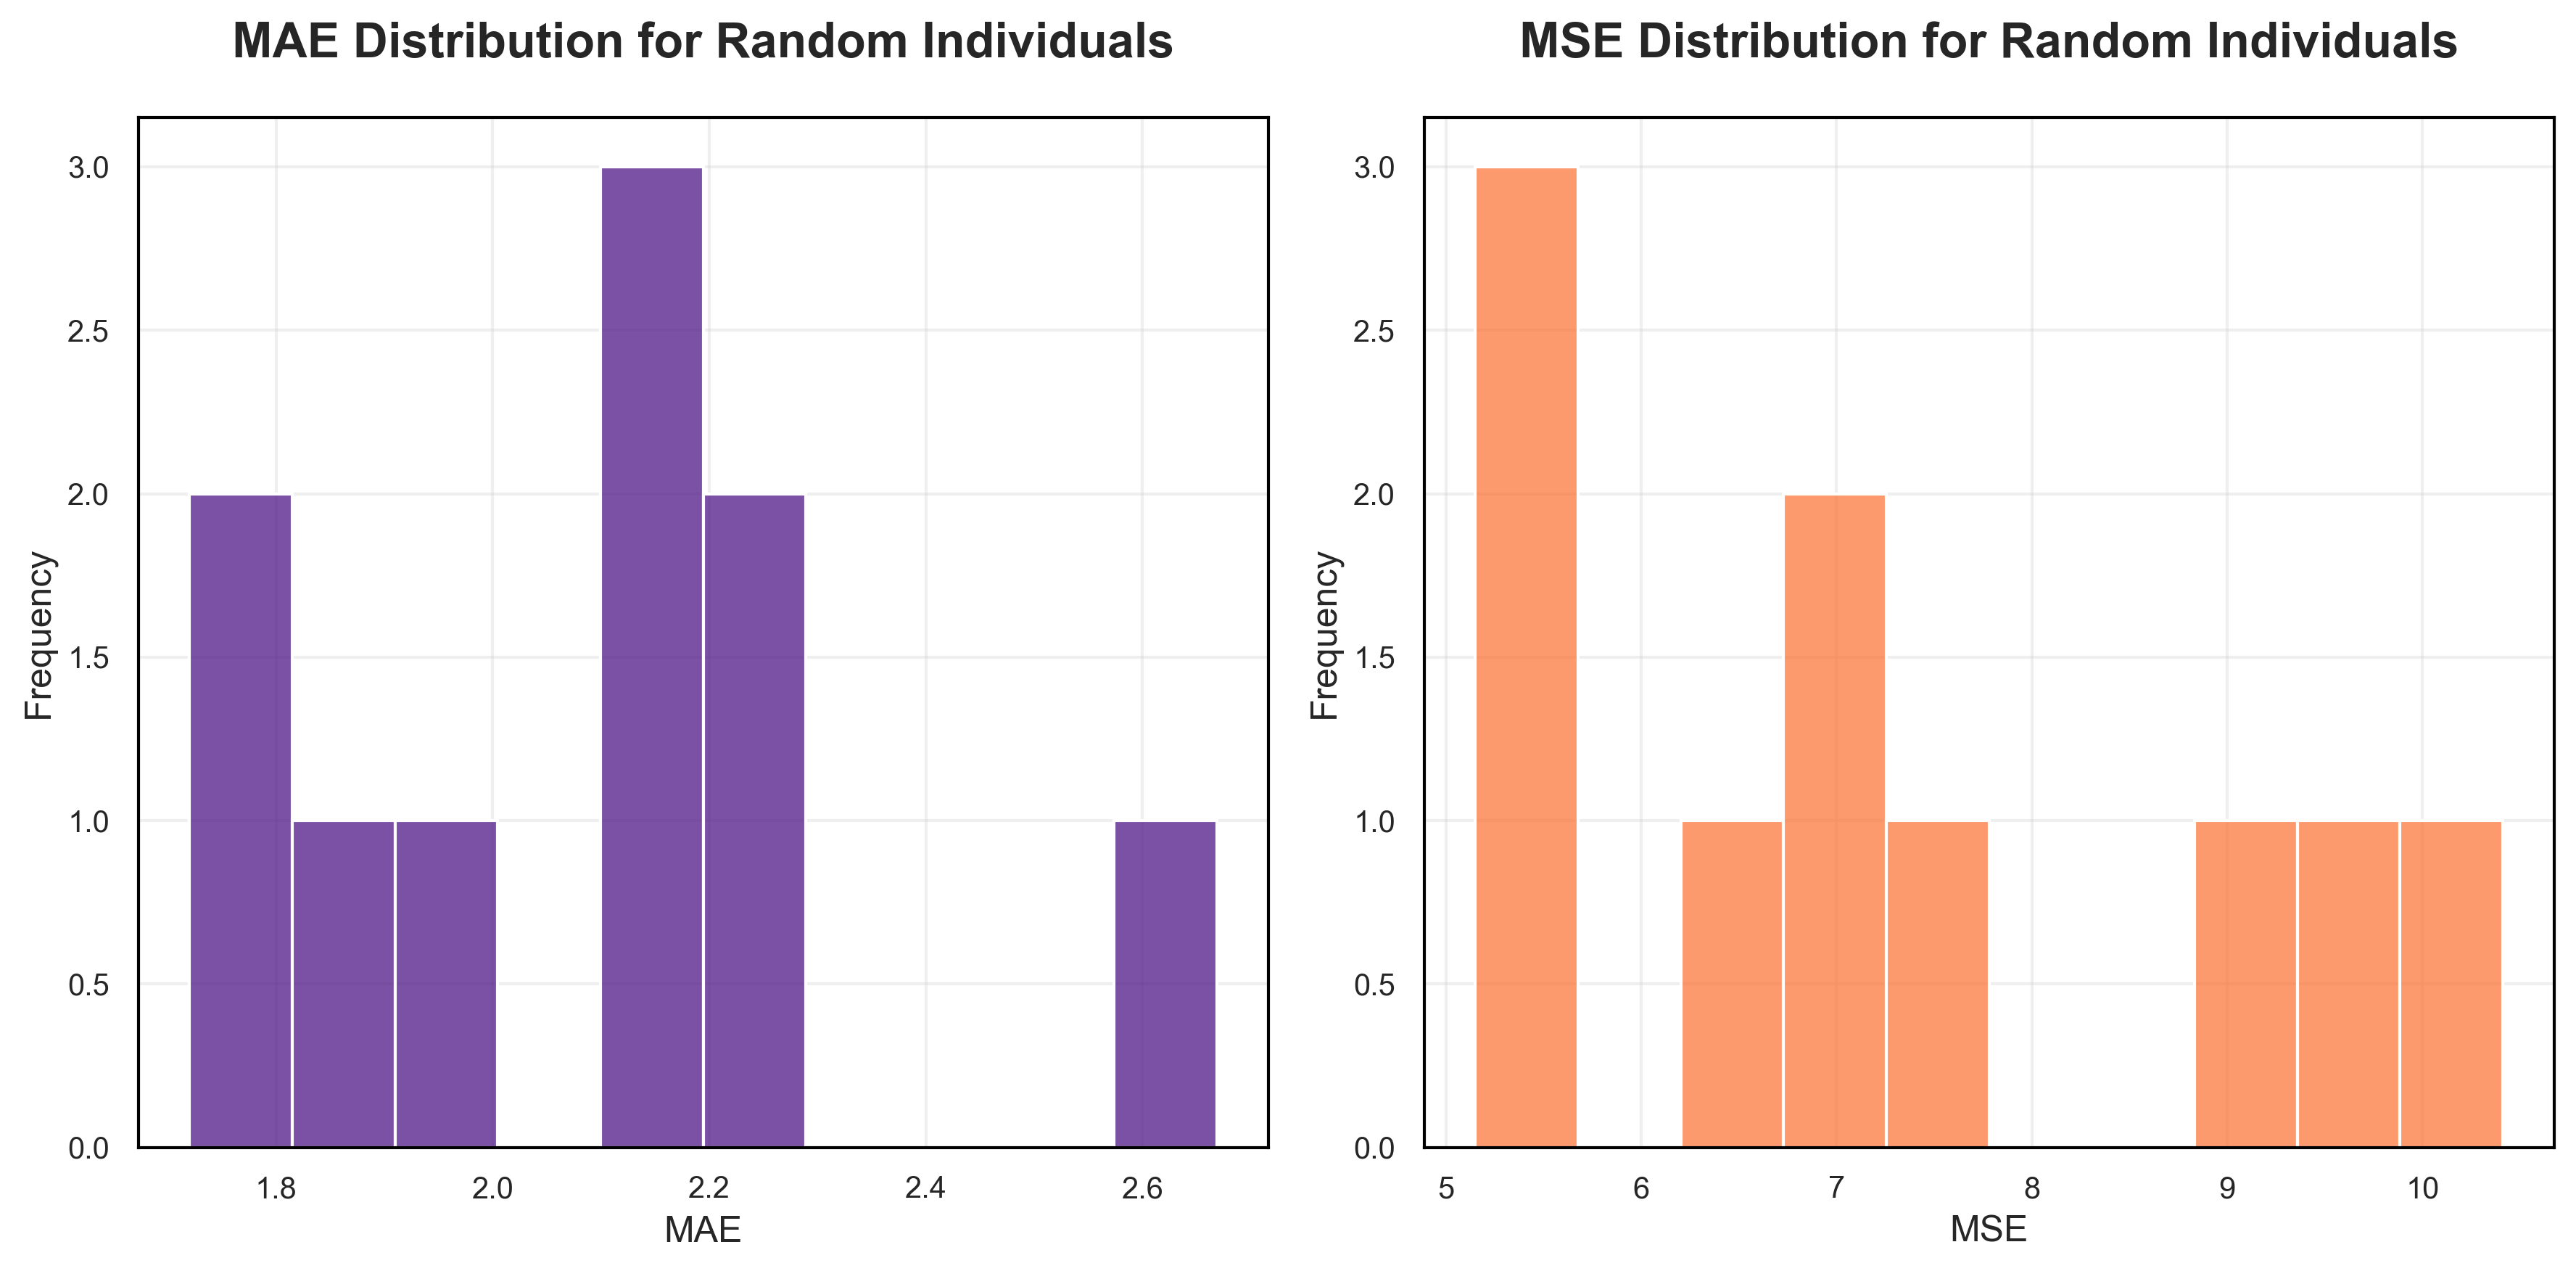

In [396]:
def calculate_alignment_multiple_randoms(data, comparison_df, filtered_data, num_samples=10):
    """
    Compare the alignment of the LLM's responses with:
    - The real person it was mimicking (from comparison_df).
    - Multiple random people's responses (from the data excluding filtered_data).
    
    Args:
    - data (pd.DataFrame): Full dataset containing people's responses, including those not in filtered_data.
    - comparison_df (pd.DataFrame): DataFrame with LLM and real responses side by side.
    - filtered_data (pd.DataFrame): DataFrame of real people used to create LLM personas (to exclude).
    - num_samples (int): Number of random individuals to compare against.
    
    Returns:
    - Prints the alignment (MAE/MSE) with the mimicked person and multiple random individuals.
    - Plots the distribution of MAE and MSE across the random individuals.
    """
    def interpret(mae, mse, description):
        if pd.notna(mae) and pd.notna(mse):
            print(f"MAE with the {description}: {mae:.2f}")
            print(f"MSE with the {description}: {mse:.2f}")
        else:
            print(f"MAE and MSE with the {description}: Data unavailable (NaN detected).")
    
    # Store MAE and MSE results for random individuals
    mae_random_list = []
    mse_random_list = []

    # Exclude the filtered personas (those used for LLM training)
    filtered_ids = filtered_data.index.tolist()
    data_cleaned = data[~data['unique_id'].isin(filtered_ids)]

    # Ensure relevant question codes in data_cleaned and comparison_df
    question_codes = comparison_df['question_code'].unique()
    data_cleaned = data_cleaned[question_codes].dropna(how='all', axis=1)
    
    # 1. Calculate MAE and MSE with the real person the LLM mimicked
    mae_persona = np.mean(np.abs(comparison_df['llm_response_code'] - comparison_df['real_response_code']))
    mse_persona = np.mean((comparison_df['llm_response_code'] - comparison_df['real_response_code']) ** 2)
    
    print(f"MAE with the real person (persona): {mae_persona:.2f}")
    print(f"MSE with the real person (persona): {mse_persona:.2f}")
    
    # 2. Calculate MAE and MSE with multiple random people from data_cleaned
    for _ in range(num_samples):
        random_person_id = data_cleaned.sample(1).index[0]  # Pick a random person
        random_person_responses = data_cleaned.loc[random_person_id]

        # Align the random person's responses with the question codes in comparison_df
        aligned_random_person = random_person_responses.reindex(comparison_df['question_code']).dropna()

        if not aligned_random_person.empty:
            aligned_llm_responses = comparison_df.set_index('question_code')['llm_response_code'].reindex(aligned_random_person.index).dropna()

            if not aligned_llm_responses.empty:
                mae_random = np.mean(np.abs(aligned_llm_responses - aligned_random_person))
                mse_random = np.mean((aligned_llm_responses - aligned_random_person) ** 2)
            else:
                mae_random, mse_random = np.nan, np.nan
        else:
            mae_random, mse_random = np.nan, np.nan

        mae_random_list.append(mae_random)
        mse_random_list.append(mse_random)

        print(f"Random Person ID: {random_person_id}")
        interpret(mae_random, mse_random, "random person")
    
    # Apply PublicationStyle
    PublicationStyle.set_style()

    # Plot MAE and MSE distribution for random individuals
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot MAE distribution
    sns.histplot(
        [mae for mae in mae_random_list if pd.notna(mae)],
        bins=10,
        color=PublicationStyle.MAIN_COLORS['primary'],
        ax=axes[0]
    )
    PublicationStyle.format_axis(
        axes[0],
        title='MAE Distribution for Random Individuals',
        xlabel='MAE',
        ylabel='Frequency'
    )

    # Plot MSE distribution
    sns.histplot(
        [mse for mse in mse_random_list if pd.notna(mse)],
        bins=10,
        color=PublicationStyle.MAIN_COLORS['secondary'],
        ax=axes[1]
    )
    PublicationStyle.format_axis(
        axes[1],
        title='MSE Distribution for Random Individuals',
        xlabel='MSE',
        ylabel='Frequency'
    )

    # Tight layout for better visuals
    plt.tight_layout()
    plt.show()

calculate_alignment_multiple_randoms(data, comparison_df, filtered_data, num_samples=10)

The results show that the LLM is most closely aligned with the real person it was trained to mimic, by a significant margin.
The less consistent alignment with random individuals further reinforces the idea that the LLM is not producing generic responses, but rather ones that are specifically tuned to the real person.

# Best and Worst Aligned

Which people in the data is the model best at mimicking and viceversa?

In [397]:
comparison_df = pd.read_csv("../data/processed/llm_vs_real_comparison_before.csv", index_col=0)

In [398]:
import pandas as pd

def calculate_alignment_for_all_individuals(comparison_df):
    # Initialize a list to store user_id, MAE, and MSE for each individual
    alignment_results = []

    # Group by 'user_id' to calculate metrics per user
    grouped = comparison_df.groupby('user_id')

    for user_id, group in grouped:
        # Extract the 'difference' column for the user
        differences = group['difference']

        # Calculate MAE (Mean Absolute Error)
        mae = differences.mean()

        # Calculate MSE (Mean Squared Error) by squaring the differences
        mse = (differences ** 2).mean()

        # Append the result into the list
        alignment_results.append({'user_id': user_id, 'MAE': mae, 'MSE': mse})

    # Convert the alignment results into a DataFrame for easy sorting
    alignment_df = pd.DataFrame(alignment_results)

    # Sort and get top 5 best and worst aligned based on MAE
    best_mae = alignment_df.nsmallest(5, 'MAE')['user_id'].tolist()  # Top 5 lowest MAE
    worst_mae = alignment_df.nlargest(5, 'MAE')['user_id'].tolist()  # Top 5 highest MAE

    # Sort and get top 5 best and worst aligned based on MSE
    best_mse = alignment_df.nsmallest(5, 'MSE')['user_id'].tolist()  # Top 5 lowest MSE
    worst_mse = alignment_df.nlargest(5, 'MSE')['user_id'].tolist()  # Top 5 highest MSE

    # Return the user_ids for both MAE and MSE rankings
    return {
        'best_mae': best_mae,
        'worst_mae': worst_mae,
        'best_mse': best_mse,
        'worst_mse': worst_mse
    }

# Example usage:
alignment_results = calculate_alignment_for_all_individuals(comparison_df)
print(alignment_results)


{'best_mae': ['IDUS127802', 'IDUS103554', 'IDUS125517', 'IDUS129270', 'IDUS104666'], 'worst_mae': ['IDUS106278', 'IDUS103408', 'IDUS110181', 'IDUS115645', 'IDUS116165'], 'best_mse': ['IDUS125517', 'IDUS127802', 'IDUS103554', 'IDUS126773', 'IDUS137441'], 'worst_mse': ['IDUS106278', 'IDUS103408', 'IDUS137909', 'IDUS116165', 'IDUS104424']}


In [399]:

# Now you can proceed with the rest of the code

def get_persona_characteristics_from_csv(user_ids, csv_data):
    """
    Fetch the characteristics of users based on their user_ids from the combined_data.csv.
    
    Parameters:
    - user_ids: List of user_ids to fetch characteristics for.
    - csv_data: DataFrame containing the data from combined_data.csv.
    
    Returns:
    - List of dictionaries containing user_id and the corresponding persona characteristics.
    """
    user_characteristics = []
    
    for user_id in user_ids:
        # Use the index to locate the user in csv_data
        if user_id in csv_data.index:
            user_data = csv_data.loc[user_id]
            
            # Extract relevant fields
            political_position = user_data['Where would you place your own political position?']
            vote_2020 = user_data['In the 2020 presidential election, who did you vote for? Donald Trump, Joe Biden, or someone else?']
            vote_2024 = user_data['If the 2024 presidential election were between Donald Trump for the Republicans and Joe Biden for the Democrats, would you vote for Donald Trump, Joe Biden, someone else, or probably not vote?']
            gender = user_data['What gender are you?']
            income = user_data['What is your approximate yearly household net income? Please indicate which category your household is in if you add together the monthly net income of all household members: All wages, salaries, pensions and other incomes after payroll taxes e.g. social security (OASDI), medicare taxes, unemployment taxes.']
            education = user_data['What is the highest educational level that you have?']
            
            # Create a formatted persona description
            description = {
                'user_id': user_id,
                'political_position': political_position,
                'vote_2020': vote_2020,
                'vote_2024': vote_2024,
                'gender': gender,
                'income': income,
                'education': education
            }
        else:
            description = {
                'user_id': user_id,
                'political_position': "No data available",
                'vote_2020': "No data available",
                'vote_2024': "No data available",
                'gender': "No data available",
                'income': "No data available",
                'education': "No data available"
            }
        
        # Append the user characteristics
        user_characteristics.append(description)
    
    return user_characteristics

# Example usage after resolving the ambiguity and fetching characteristics
alignment_results = calculate_alignment_for_all_individuals(comparison_df)
csv_data = pd.read_csv("../data/processed/combined_data.csv", index_col='user')

# Fetch characteristics for the top 5 best and worst aligned individuals (MAE and MSE)
best_mae_characteristics = get_persona_characteristics_from_csv(alignment_results['best_mae'], csv_data)
worst_mae_characteristics = get_persona_characteristics_from_csv(alignment_results['worst_mae'], csv_data)
best_mse_characteristics = get_persona_characteristics_from_csv(alignment_results['best_mse'], csv_data)
worst_mse_characteristics = get_persona_characteristics_from_csv(alignment_results['worst_mse'], csv_data)

# Print or analyze the characteristics
print("Best MAE Characteristics:", best_mae_characteristics)
print("Worst MAE Characteristics:", worst_mae_characteristics)
print("Best MSE Characteristics:", best_mse_characteristics)
print("Worst MSE Characteristics:", worst_mse_characteristics)


Best MAE Characteristics: [{'user_id': 'IDUS127802', 'political_position': 'Extreme Right', 'vote_2020': 'Donald Trump', 'vote_2024': 'Donald Trump', 'gender': 'Female', 'income': '$50,000 to 74,999', 'education': 'Bachelor or equivalent'}, {'user_id': 'IDUS103554', 'political_position': 'Extreme Right', 'vote_2020': 'Donald Trump', 'vote_2024': 'Donald Trump', 'gender': 'Female', 'income': '$25,000 to 49,999', 'education': 'Upper secondary education'}, {'user_id': 'IDUS125517', 'political_position': 'Extreme Right', 'vote_2020': 'Donald Trump', 'vote_2024': 'Donald Trump', 'gender': 'Male', 'income': '$25,000 to 49,999', 'education': 'Primary education'}, {'user_id': 'IDUS129270', 'political_position': 'Extreme Right', 'vote_2020': 'Donald Trump', 'vote_2024': 'Donald Trump', 'gender': 'Female', 'income': '$25,000 to 49,999', 'education': 'Bachelor or equivalent'}, {'user_id': 'IDUS104666', 'political_position': 'Extreme Right', 'vote_2020': 'Donald Trump', 'vote_2024': 'Donald Trump'

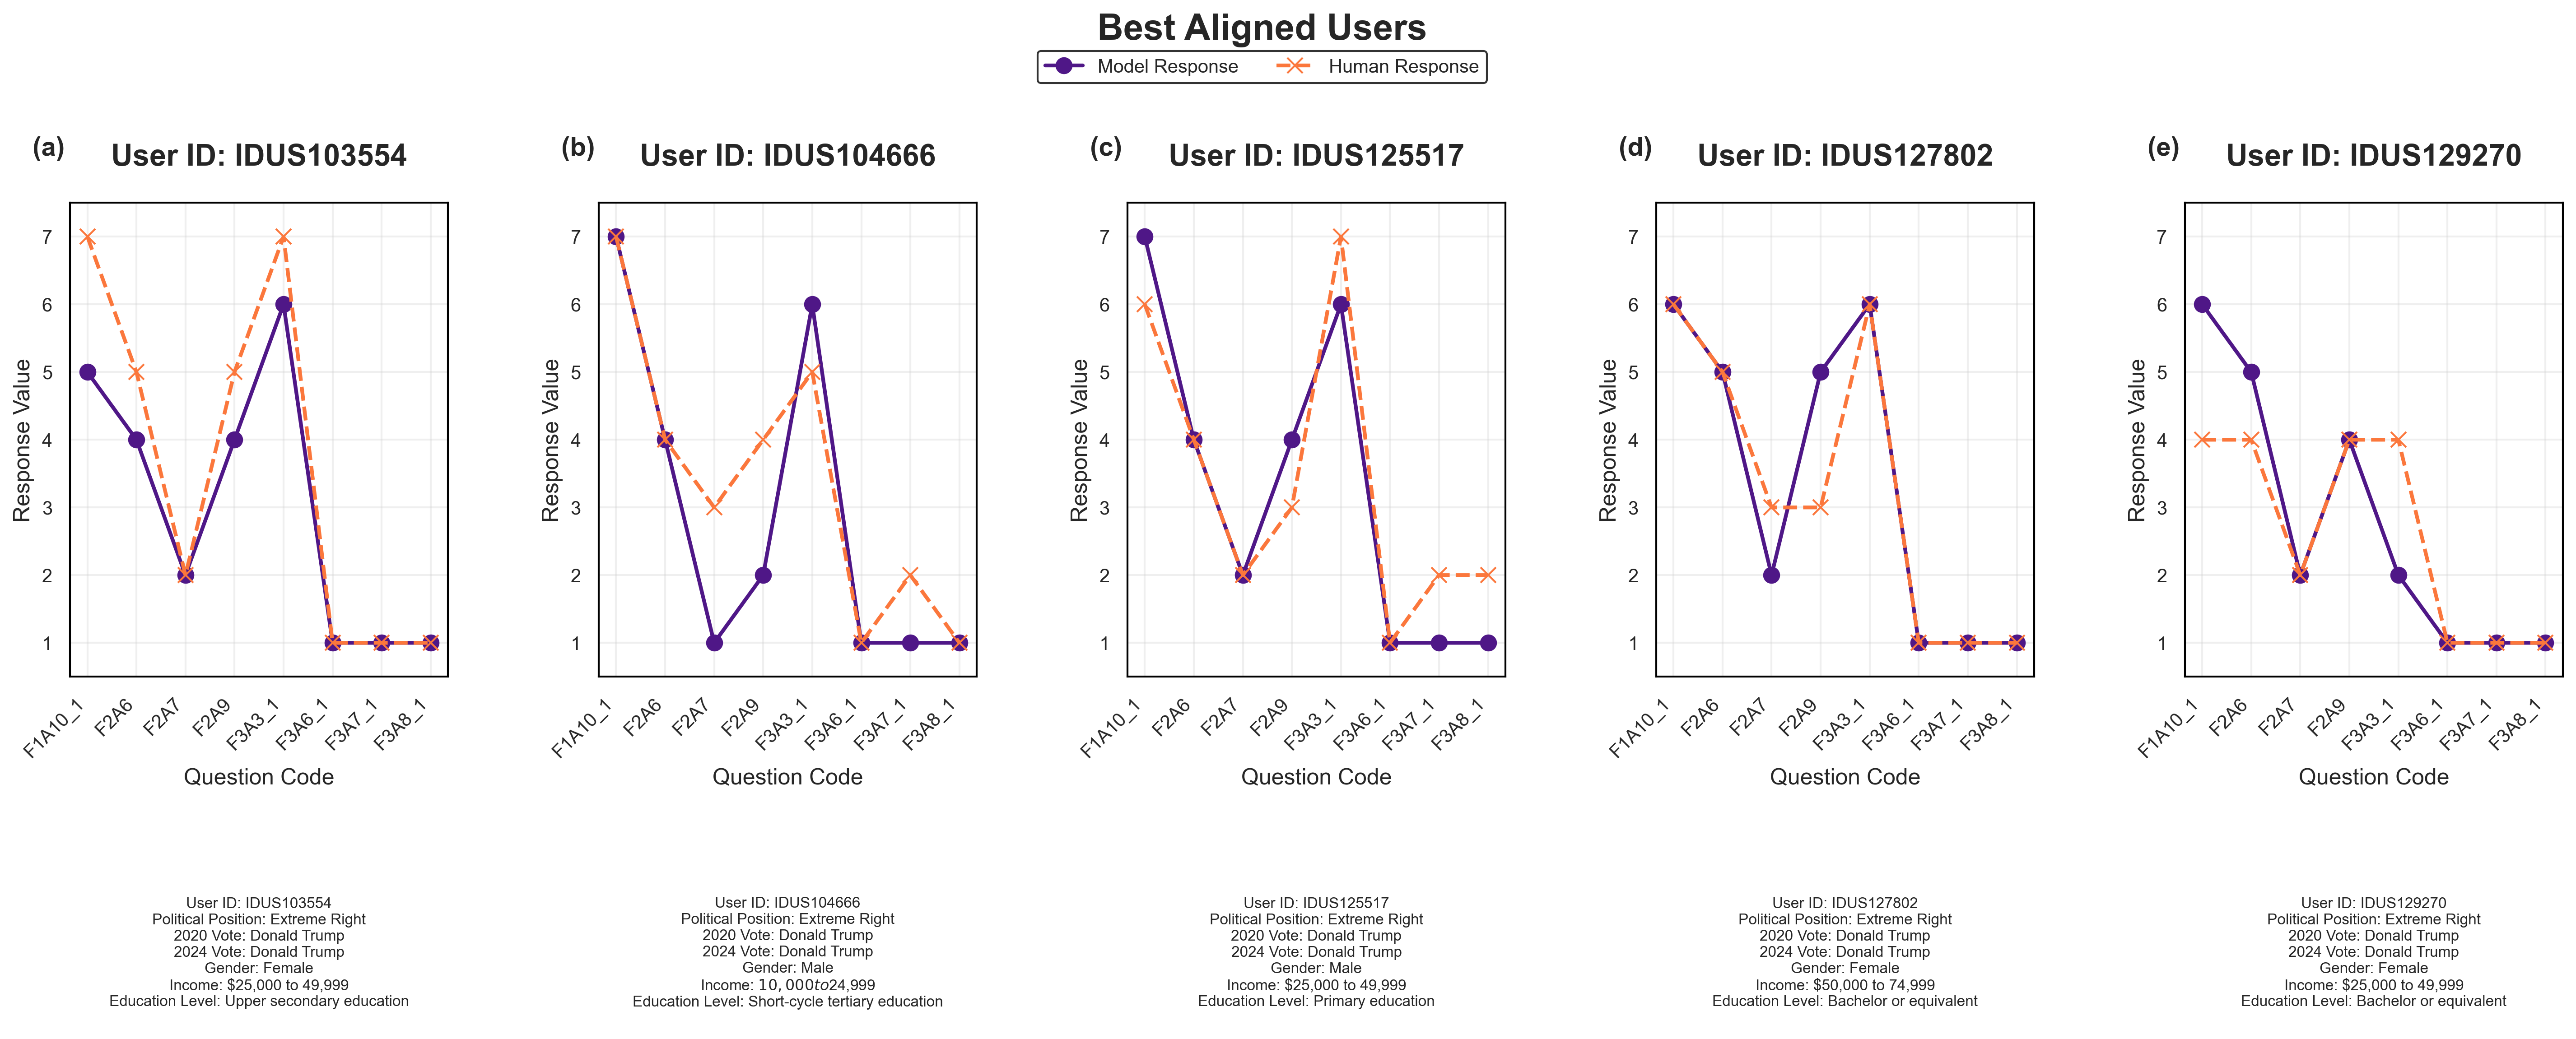

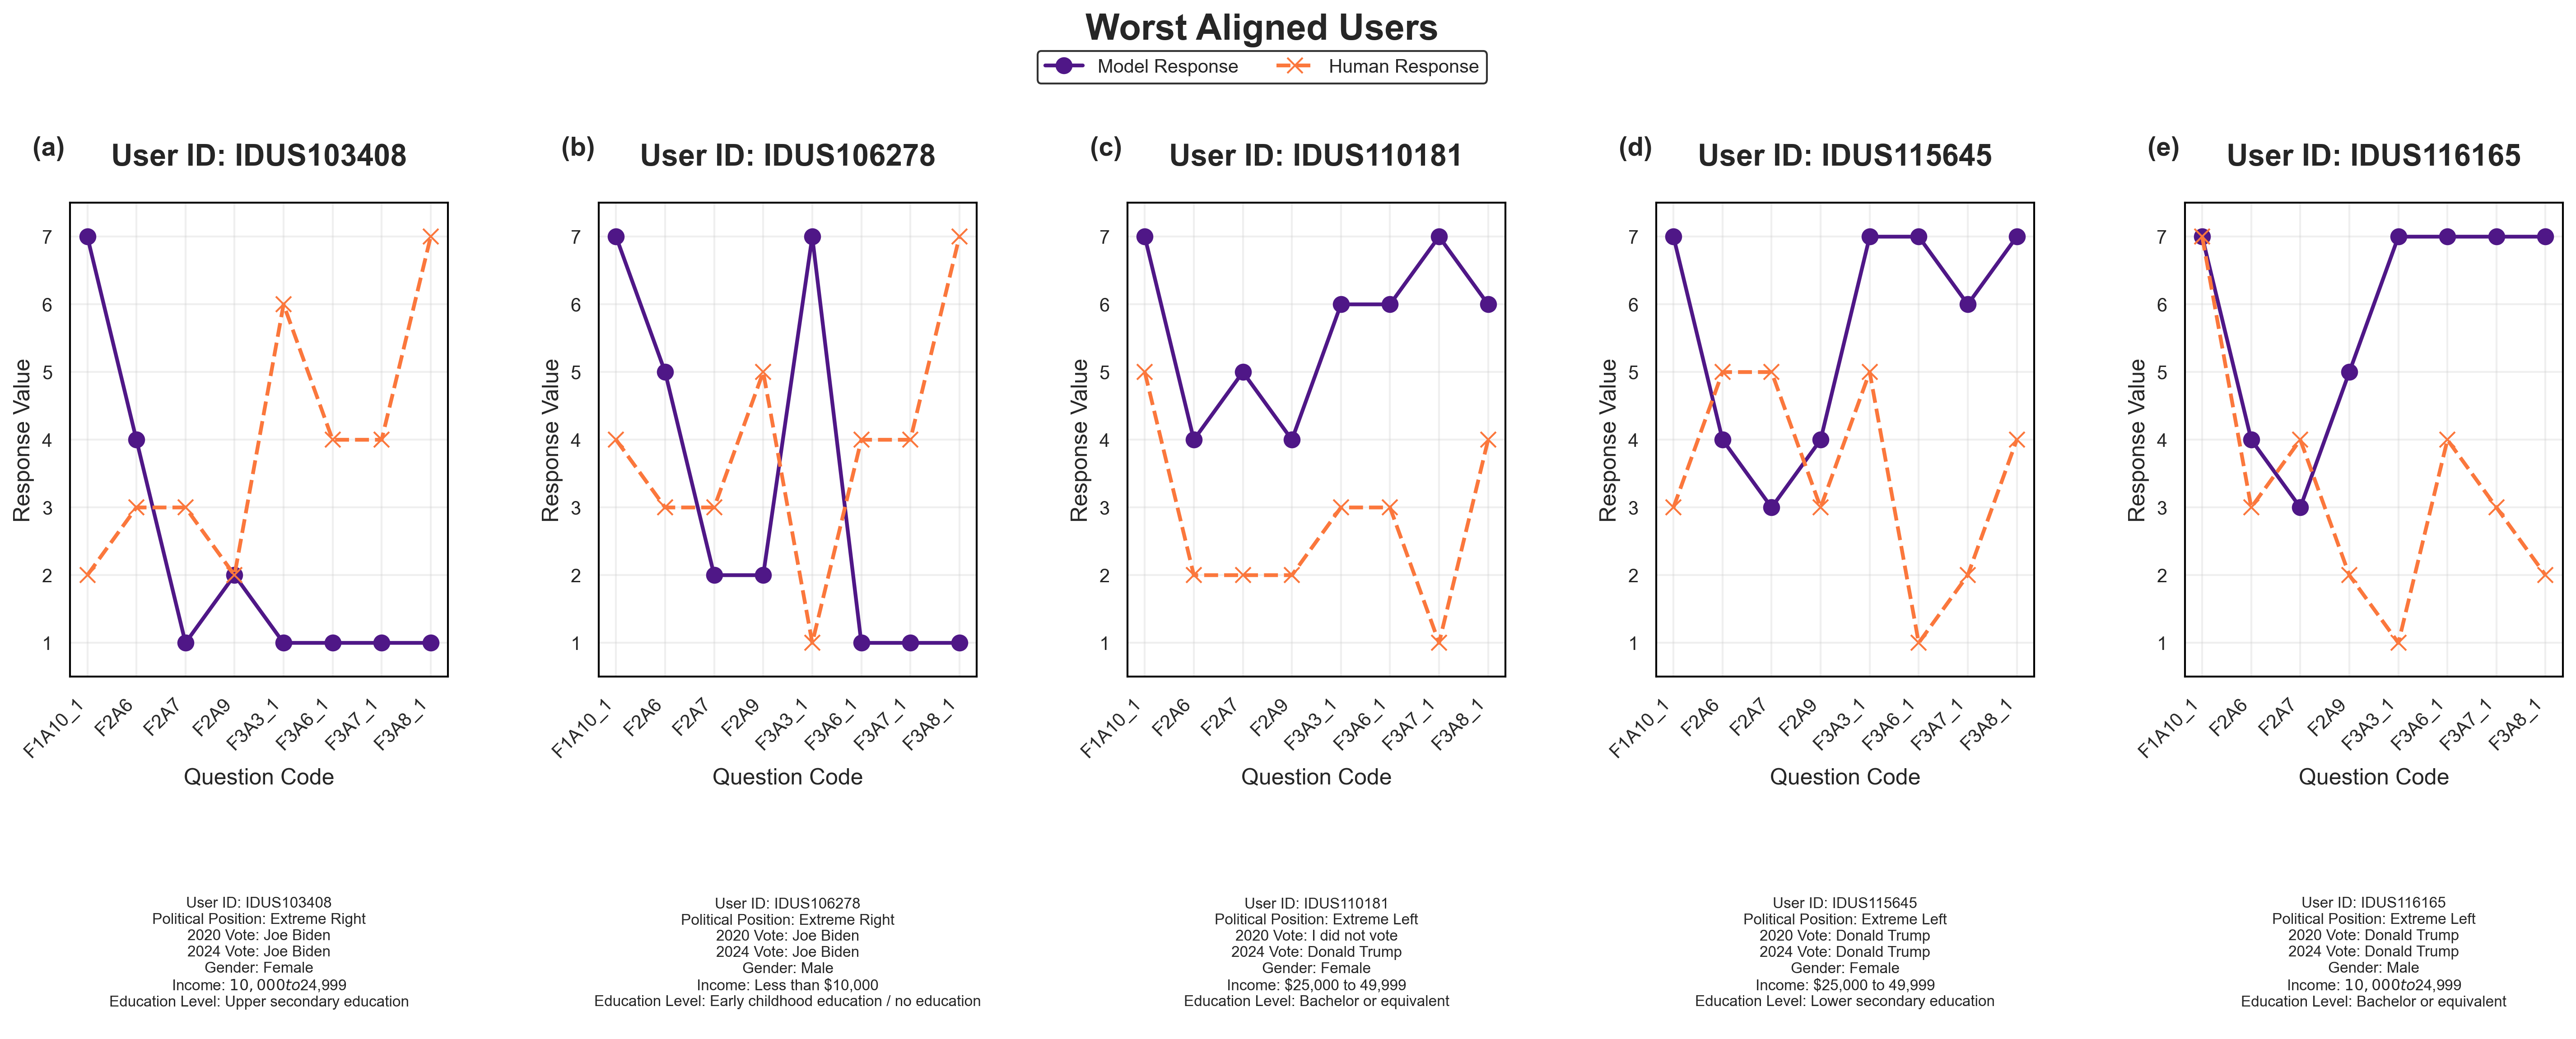

In [400]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_model_vs_real_responses(ax, user_id, model_responses, real_responses, question_codes, persona_description):
    """Plot model vs real responses for a single user with improved formatting."""
    # Plot responses with custom styling
    ax.plot(
        range(len(question_codes)), 
        model_responses,
        marker='o',
        linestyle='-',
        color=PublicationStyle.MAIN_COLORS['primary'],
        label='Model Response'
    )
    ax.plot(
        range(len(question_codes)),
        real_responses,
        marker='x',
        linestyle='--',
        color=PublicationStyle.MAIN_COLORS['secondary'],
        label='Human Response'
    )
    
    # Set up axis formatting
    PublicationStyle.format_axis(
        ax,
        title=f"User ID: {user_id}",
        xlabel="Question Code",
        ylabel="Response Value"
    )
    
    # Configure x-axis ticks
    ax.set_xticks(range(len(question_codes)))
    ax.set_xticklabels(question_codes, rotation=45, ha='right')
    
    # Set y-axis limits
    ax.set_ylim(0.5, 7.5)
    
    # Add persona description as text in a smaller font with adjusted position
    ax.text(0.5, -0.6, persona_description,  # Moved down from -0.4 to -0.6
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes,
            fontsize=PublicationStyle.FONT_SIZES['tiny'])  # Reduced font size

def visualize_best_and_worst_users_with_personas(best_users_df, worst_users_df, best_personas, worst_personas):
    """Create publication-quality visualizations for best and worst aligned users."""
    
    # Set publication style
    PublicationStyle.set_style()
    
    figsize = (20, 7)  # Slightly increased height to accommodate spacing
    for title, users_df, personas in [
        ('Best Aligned Users', best_users_df, best_personas),
        ('Worst Aligned Users', worst_users_df, worst_personas)
    ]:
        fig, axs = plt.subplots(1, 5, figsize=figsize)
        
        # Add main title
        fig.suptitle(title, 
                    fontsize=PublicationStyle.FONT_SIZES['title']*1.2,
                    fontweight='bold',
                    y=1.05)
        
        # Plot each user
        for idx, (user_id, persona) in enumerate(zip(users_df['user_id'].unique(), personas)):
            user_data = users_df[users_df['user_id'] == user_id]
            model_responses = user_data['llm_response_code'].tolist()
            real_responses = user_data['real_response_code'].tolist()
            question_codes = user_data['question_code'].tolist()
            
            plot_model_vs_real_responses(axs[idx], user_id, model_responses, 
                                       real_responses, question_codes, persona)
        
        # Add a single legend for the entire figure
        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels,
                  bbox_to_anchor=(0.5, 1.02),
                  loc='upper center',
                  ncol=2,
                  fontsize=PublicationStyle.FONT_SIZES['legend'])
        
        # Adjust layout with more space at the bottom
        plt.subplots_adjust(
            top=0.85,      # Move plots down from suptitle
            bottom=0.35,   # Increased from 0.3 to 0.35 to make more room
            wspace=0.4,    # Space between subplots
            right=0.98,    # Right margin
            left=0.06,     # Left margin
            hspace=0.5     # Vertical space between elements
        )
        
        # Add subplot labels
        PublicationStyle.add_figure_labels(fig)
        
        plt.show()

# The rest of your code remains the same

def create_persona_descriptions_from_csv(user_ids, csv_data):
    descriptions = []
    
    for user_id in user_ids:
        if user_id in csv_data.index:
            user_data = csv_data.loc[user_id]
            political_position = user_data['Where would you place your own political position?']
            vote_2020 = user_data['In the 2020 presidential election, who did you vote for? Donald Trump, Joe Biden, or someone else?']
            vote_2024 = user_data['If the 2024 presidential election were between Donald Trump for the Republicans and Joe Biden for the Democrats, would you vote for Donald Trump, Joe Biden, someone else, or probably not vote?']
            gender = user_data['What gender are you?']
            income = user_data['What is your approximate yearly household net income? Please indicate which category your household is in if you add together the monthly net income of all household members: All wages, salaries, pensions and other incomes after payroll taxes e.g. social security (OASDI), medicare taxes, unemployment taxes.']
            education = user_data['What is the highest educational level that you have?']
            
            description = (
                f"User ID: {user_id}\n"
                f"Political Position: {political_position}\n"
                f"2020 Vote: {vote_2020}\n"
                f"2024 Vote: {vote_2024}\n"
                f"Gender: {gender}\n"
                f"Income: {income}\n"
                f"Education Level: {education}\n"
            )
        else:
            description = f"User ID: {user_id}\nNo data available."

        descriptions.append(description)
    
    return descriptions

# Function to ensure the alignment of user_id and user columns
def ensure_user_alignment(comparison_df, csv_data):
    if 'user_id' not in comparison_df.columns:
        comparison_df = comparison_df.reset_index()
    comparison_df = comparison_df[comparison_df['user_id'].isin(csv_data.index)]
    return comparison_df

csv_path = "../data/processed/combined_data.csv"
csv_data = pd.read_csv(csv_path, index_col='user')

comparison_df = ensure_user_alignment(comparison_df, csv_data)

best_mae_users = alignment_results['best_mae']
worst_mae_users = alignment_results['worst_mae']

best_mae_accuracy = comparison_df[comparison_df['user_id'].isin(best_mae_users)]
worst_mae_accuracy = comparison_df[comparison_df['user_id'].isin(worst_mae_users)]

best_mae_personas = create_persona_descriptions_from_csv(best_mae_accuracy['user_id'].unique(), csv_data)
worst_mae_personas = create_persona_descriptions_from_csv(worst_mae_accuracy['user_id'].unique(), csv_data)

visualize_best_and_worst_users_with_personas(best_mae_accuracy, worst_mae_accuracy, best_mae_personas, worst_mae_personas)


In [401]:
import pandas as pd

# Function to rank users based on the new reliability score
def rank_users_by_alignment(comparison_df):
    """
    Rank users by alignment using an inverted score where higher is better.
    
    Parameters:
    - comparison_df: DataFrame containing 'user_id', 'llm_response_code', 'real_response_code', and 'difference'.
    
    Returns:
    - DataFrame with 'user_id' and 'reliability_score' sorted by best alignment.
    """
    # Group by user_id and compute the mean difference
    user_reliability = comparison_df.groupby('user_id')['difference'].mean().reset_index()
    
    # Invert the mean difference to create a new reliability score
    # The formula is 1 / (1 + mean_difference), so that lower differences give higher scores
    user_reliability['reliability_score'] = 1 / (1 + user_reliability['difference'])
    
    # Sort users by reliability score (higher is better alignment)
    user_reliability = user_reliability.sort_values(by='reliability_score', ascending=False)
    
    # Assign ranks (higher score gets a better rank)
    user_reliability['rank'] = user_reliability['reliability_score'].rank(method='dense', ascending=False)
    
    return user_reliability

# Example usage to rank the users based on comparison_df
user_ranks = rank_users_by_alignment(comparison_df)

# Display ranked users with new reliability scores and ranks
print(user_ranks.head(10))  # Show top 10 most reliable users


        user_id  difference  reliability_score  rank
97   IDUS127802       0.375           0.727273   1.0
79   IDUS125517       0.625           0.615385   2.0
100  IDUS129270       0.625           0.615385   2.0
1    IDUS103554       0.625           0.615385   2.0
6    IDUS104666       0.750           0.571429   3.0
92   IDUS126773       0.750           0.571429   3.0
112  IDUS137441       0.750           0.571429   3.0
116  IDUS140583       0.750           0.571429   3.0
111  IDUS133993       0.750           0.571429   3.0
64   IDUS118210       0.875           0.533333   4.0


In [402]:
user_ranks.to_csv("../data/processed/user_ranks.csv", index=False)

## Extra Analysis

In [403]:
from scipy.stats import wilcoxon
import numpy as np

# Assuming the original dataset is stored in `data`
# and the filtered dataset is `filtered_data`
# and `unique_id` is the column identifying personas

# Get the IDs of filtered personas
filtered_ids = filtered_data.index.tolist()

from scipy.stats import wilcoxon
import numpy as np

def perform_wilcoxon_tests_unique_randoms(differences, data_cleaned, comparison_df, num_random_samples=10):
    """
    Perform Wilcoxon tests to evaluate LLM alignment with the persona against multiple unique random baselines.

    Args:
        differences (dict): Contains differences for 'persona', 'random', 'average', and 'frequent'.
        data_cleaned (pd.DataFrame): Dataset with cleaned random responses.
        comparison_df (pd.DataFrame): Comparison DataFrame with LLM responses.
        num_random_samples (int): Number of unique random samples to test.

    Returns:
        None. Prints results and interpretation dynamically.
    """
    print("Wilcoxon Test Results:")

    # Perform Wilcoxon test for all predefined baselines
    for baseline, baseline_differences in differences.items():
        if baseline != "persona":  # Compare only against persona
            stat, p_value = wilcoxon(differences["persona"], baseline_differences, alternative='less')
            print(f"\nLLM vs {baseline.capitalize()} Baseline:")
            print(f"  W-statistic = {stat}, p-value = {p_value:.4f}")

            # Dynamic interpretation
            if p_value < 0.001:
                print(f"  -> **Highly significant:** The LLM is significantly better aligned with the persona compared to the {baseline} baseline (p < 0.001).")
            elif p_value < 0.05:
                print(f"  -> **Significant:** The LLM is better aligned with the persona compared to the {baseline} baseline (p < 0.05).")
            else:
                print(f"  -> No significant difference: The LLM's alignment with the persona is not statistically better than the {baseline} baseline.")
    
    # Evaluate multiple unique random baselines
    print("\nEvaluating Multiple Unique Random Baselines:")
    random_p_values = []
    sampled_indices = set()

    for i in range(num_random_samples):
        try:
            # Sample a new random person without replacement
            available_indices = data_cleaned.index.difference(sampled_indices)
            if len(available_indices) == 0:
                print(f"  No more unique individuals available for Random Baseline {i + 1}.")
                break

            random_person_id = np.random.choice(available_indices)
            sampled_indices.add(random_person_id)
            random_person_responses = data_cleaned.loc[random_person_id]

            # Align the random person's responses with the question codes
            aligned_random_person = random_person_responses.reindex(comparison_df['question_code']).dropna()

            if not aligned_random_person.empty:
                random_differences = abs(comparison_df.set_index('question_code')['llm_response_code'] - aligned_random_person)
                
                # Perform Wilcoxon test
                stat, p_value = wilcoxon(differences["persona"], random_differences, alternative='less')
                random_p_values.append(p_value)
                print(f"  Random Baseline {i + 1}: p-value = {p_value:.4f}")
            else:
                print(f"  Random Baseline {i + 1}: No data available for this sample.")
        except Exception as e:
            print(f"  Random Baseline {i + 1}: Error - {e}")

    # Aggregate results from multiple random baselines
    if random_p_values:
        mean_p_value = np.median(random_p_values)
        std_p_value = np.std(random_p_values)

        print("\nAggregate Results for Random Baselines:")
        print(f"Median p-value: {mean_p_value:.4f}")
        print(f"Standard Deviation of p-values: {std_p_value:.4f}")

        # Final interpretation
        if mean_p_value < 0.05:
            print("\n-> The median p-value indicates that the LLM aligns significantly better with the persona compared to multiple unique random baselines.")
        else:
            print("\n-> The median p-value indicates that the LLM's alignment with the persona is not significantly better than unique random baselines.")
    else:
        print("\n-> No valid random baselines could be evaluated.")

differences, data_cleaned = calculate_full_baseline(data, comparison_df, filtered_data)
perform_wilcoxon_tests_unique_randoms(differences, data_cleaned, comparison_df, num_random_samples=100)


MAE with the real person (persona): 1.73
MSE with the real person (persona): 5.29
Interpretation: The LLM is moderately aligned with the real person (persona), with some noticeable differences (1-2 steps away).

MAE with the random person: 1.89
MSE with the random person: 6.47
Interpretation: The LLM is moderately aligned with the random person, with some noticeable differences (1-2 steps away).

MAE with the average response: 1.95
MSE with the average response: 4.80
Interpretation: The LLM is moderately aligned with the average response, with some noticeable differences (1-2 steps away).

MAE with the most frequent response: 2.19
MSE with the most frequent response: 6.13
Interpretation: The LLM has low alignment with the most frequent response, with significant differences (more than 2 steps away).

Wilcoxon Test Results:

LLM vs Random Baseline:
  W-statistic = 130058.0, p-value = 0.0705
  -> No significant difference: The LLM's alignment with the persona is not statistically better 

In [404]:
def analyze_by_question(comparison_df, filtered_data):
    """
    Analyze performance question by question, comparing LLM vs baselines
    """
    results = []
    
    # Get unique question codes
    questions = comparison_df['question_code'].unique()
    
    for question in questions:
        # Get the real responses for this question from filtered_data
        real_responses = filtered_data[question].dropna()
        
        # Calculate baselines for this question
        avg_response = round(real_responses.mean())  # Round to nearest integer
        most_freq_response = real_responses.mode()[0]  # Get most frequent response
        
        # Get LLM differences for this question
        question_data = comparison_df[comparison_df['question_code'] == question]
        llm_mae = question_data['difference'].mean()
        
        # Calculate baseline differences
        avg_differences = abs(real_responses - avg_response).mean()
        freq_differences = abs(real_responses - most_freq_response).mean()
        
        results.append({
            'Question': question,
            'LLM MAE': round(llm_mae, 2),
            'Avg Response': avg_response,
            'Avg Response MAE': round(avg_differences, 2),
            'Most Frequent': most_freq_response,
            'Most Frequent MAE': round(freq_differences, 2)
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

# Create analysis
results = analyze_by_question(comparison_df, filtered_data)

# Display results
print("\nQuestion-by-Question Analysis:")
print(results.to_string(index=False))

# Save results
Path("../results").mkdir(parents=True, exist_ok=True)
results.to_csv('../results/question_analysis.csv', index=False)


Question-by-Question Analysis:
Question  LLM MAE  Avg Response  Avg Response MAE  Most Frequent  Most Frequent MAE
 F1A10_1     1.62             6              1.14              7               1.47
    F2A6     1.47             3              1.00              3               1.00
    F2A7     1.40             3              0.90              3               0.90
    F2A9     1.39             3              0.99              3               0.99
  F3A3_1     2.05             5              1.39              6               1.33
  F3A6_1     2.14             3              1.86              1               2.29
  F3A7_1     1.91             3              1.53              1               2.34
  F3A8_1     1.86             3              1.62              1               2.40


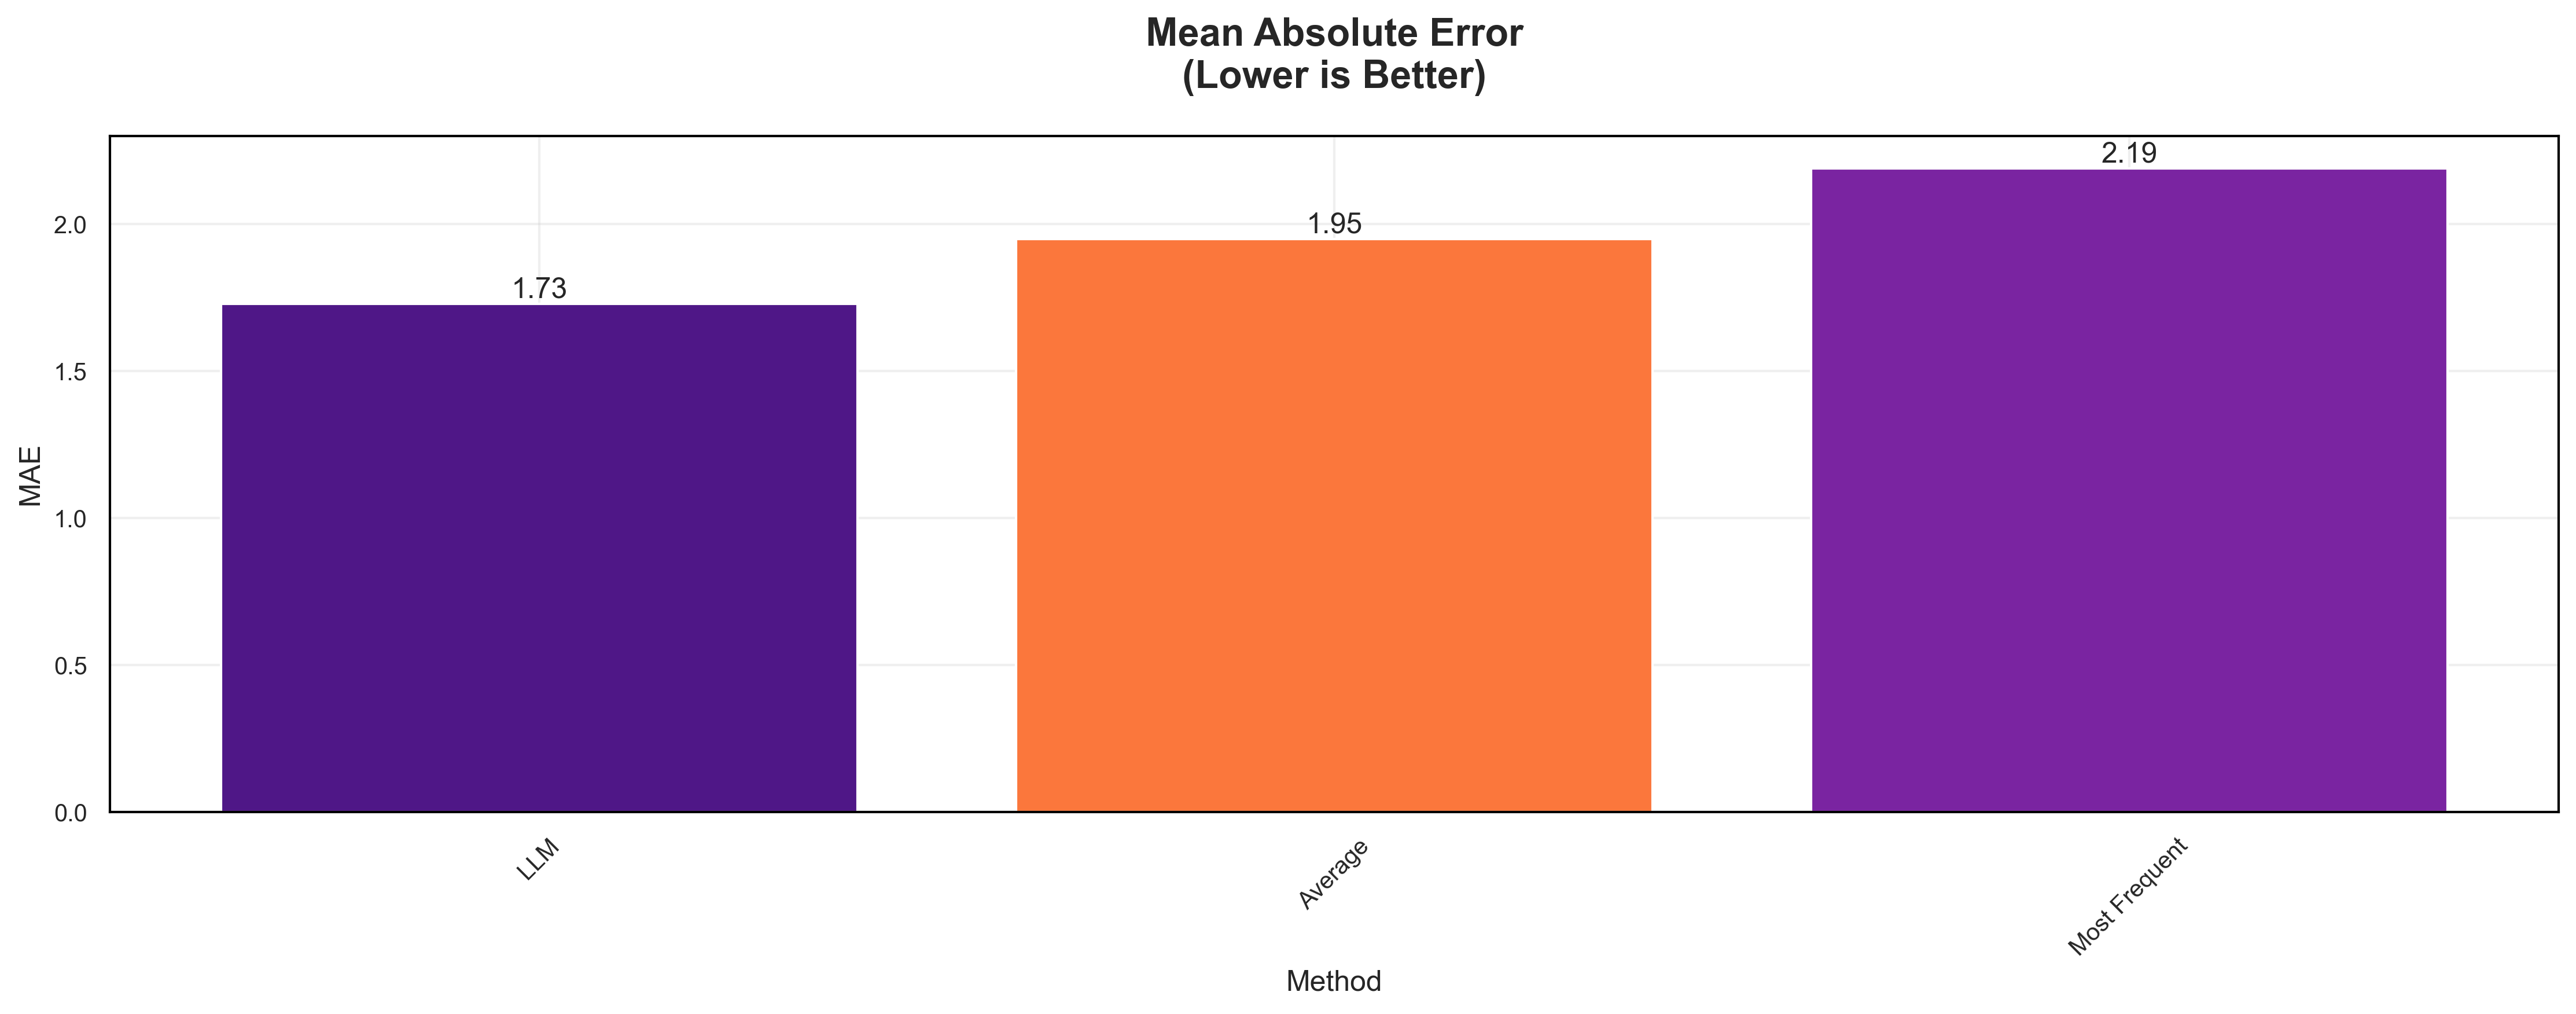

In [405]:
def plot_performance_comparison(comparison_df, filtered_data):
    """
    Create visualization showing error rates and paired comparisons
    """
    PublicationStyle.set_style()
    
    fig, ax = plt.subplots(1, figsize=(15, 6))
    
    # Plot 1: Mean Absolute Error (MAE)
    mae_data = {
        'LLM': 1.73,
        'Average': 1.95,
        'Most Frequent': 2.19
    }
    
    x = np.arange(len(mae_data))
    bars = ax.bar(x, mae_data.values(), 
                  color=[PublicationStyle.MAIN_COLORS[c] for c in ['primary', 'secondary', 'tertiary']])
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')
    
    PublicationStyle.format_axis(
        ax,
        title='Mean Absolute Error\n(Lower is Better)',
        xlabel='Method',
        ylabel='MAE',
        xticks=[x, mae_data.keys()],
        rotation=45
    )
    
    
    plt.tight_layout()
    plt.show()

# Create the visualization
plot_performance_comparison(comparison_df, filtered_data)

In [406]:
import pandas as pd
import numpy as np

def compare_llm_to_real(llm_responses_mapped, filtered_data):
    """
    Compare LLM responses to real responses and calculate the absolute differences.
    Also perform step-wise comparison of the LLM, Average, and Most Frequent baselines.

    Parameters:
    - llm_responses_mapped (list): A list of LLM response dictionaries, where each dictionary contains
                                  'user_id', 'question_code', and 'llm_response_code'.
    - filtered_data (DataFrame): A pandas DataFrame containing real responses, with user_id as the index
                                and question_code as the columns.

    Returns:
    - comparison_df (DataFrame): A pandas DataFrame containing the comparison results.
    - step_wise_df (DataFrame): A pandas DataFrame containing the step-wise comparison results.
    """
    llm_vs_real_comparison = []
    step_wise_comparison = []

    for llm_response in llm_responses_mapped:
        user_id = llm_response['user_id']
        question_code = llm_response['question_code']
        llm_response_code = llm_response['llm_response_code']

        # Check if the user_id and question_code exist in filtered_data
        if user_id in filtered_data.index and question_code in filtered_data.columns:
            # Fetch the real response
            real_response = filtered_data.loc[user_id, question_code]

            # If real_response is a Series (multiple values), extract the first valid value
            if isinstance(real_response, pd.Series):
                real_response_code = real_response.iloc[0]
            else:
                real_response_code = real_response

            # Check if the real response code is valid (not NaN)
            if pd.notna(real_response_code):
                # Calculate the absolute difference
                difference = abs(real_response_code - llm_response_code)

                # Store the comparison
                llm_vs_real_comparison.append({
                    'user_id': user_id,
                    'question_code': question_code,
                    'llm_response_code': llm_response_code,
                    'real_response_code': real_response_code,
                    'difference': difference
                })

                # Calculate the step-wise comparison
                real_responses = filtered_data[question_code].dropna()
                llm_diff = abs(real_response_code - llm_response_code)
                avg_diff = abs(real_response_code - round(real_responses.mean()))
                mf_diff = abs(real_response_code - real_responses.mode()[0])

                step_wise_comparison.append({
                    'question_code': question_code,
                    'llm_steps_away': llm_diff,
                    'avg_steps_away': avg_diff,
                    'mf_steps_away': mf_diff
                })

    # Convert the comparison results to DataFrames
    comparison_df = pd.DataFrame(llm_vs_real_comparison)
    step_wise_df = pd.DataFrame(step_wise_comparison)

    return comparison_df, step_wise_df


In [407]:
comparison_df, step_wise_df = compare_llm_to_real(llm_responses_mapped, filtered_data)


In [408]:
print("Comparison DataFrame:")
print(comparison_df)
print("\nStep-wise Comparison DataFrame:")
print(step_wise_df)

Comparison DataFrame:
        user_id question_code  llm_response_code  real_response_code  \
0    IDUS103408       F1A10_1                  7                   2   
1    IDUS103408          F2A6                  4                   3   
2    IDUS103408          F2A7                  1                   3   
3    IDUS103408          F2A9                  2                   2   
4    IDUS103408        F3A3_1                  1                   6   
..          ...           ...                ...                 ...   
931  IDUS140555          F2A9                  5                   5   
932  IDUS140555        F3A3_1                  5                   7   
933  IDUS140555        F3A6_1                  7                   7   
934  IDUS140555        F3A7_1                  7                   7   
935  IDUS140555        F3A8_1                  7                   6   

     difference  
0             5  
1             1  
2             2  
3             0  
4             5  
..   

In [409]:
def plot_step_wise_comparison_subplots(step_wise_df):
    """
    Visualize the step-wise comparison for each question as separate subplots,
    showing the LLM, Average, and Most Frequent baselines for each step distance.

    Parameters:
    - step_wise_df (pd.DataFrame): DataFrame containing columns 'question_code', 'llm_steps_away',
                                   'avg_steps_away', and 'mf_steps_away'.
    """
    # Set the publication style
    PublicationStyle.set_style()

    # Prepare data: Count the number of responses for each step distance by baseline and question_code
    llm_counts = step_wise_df.groupby(['question_code', 'llm_steps_away']).size().unstack(fill_value=0)
    avg_counts = step_wise_df.groupby(['question_code', 'avg_steps_away']).size().unstack(fill_value=0)
    mf_counts = step_wise_df.groupby(['question_code', 'mf_steps_away']).size().unstack(fill_value=0)

    # Determine unique step values for consistency across subplots
    step_values = sorted(set(llm_counts.columns).union(avg_counts.columns).union(mf_counts.columns))

    # Ensure all data is aligned to the same step_values
    llm_counts = llm_counts.reindex(columns=step_values, fill_value=0)
    avg_counts = avg_counts.reindex(columns=step_values, fill_value=0)
    mf_counts = mf_counts.reindex(columns=step_values, fill_value=0)

    # Get unique question codes and set up subplots
    question_codes = step_wise_df['question_code'].unique()
    num_questions = len(question_codes)
    fig, axes = plt.subplots(nrows=(num_questions + 3) // 4, ncols=4, figsize=(20, 5 * ((num_questions + 3) // 4)))
    axes = axes.flatten()
    fig.suptitle("Step-wise Comparison: LLM vs Baselines", fontsize=PublicationStyle.FONT_SIZES['title'], y=1)
    # Iterate over questions and plot in individual subplots
    for i, question in enumerate(question_codes):
        ax = axes[i]

        # Extract data for the current question
        llm_data = llm_counts.loc[question] if question in llm_counts.index else pd.Series(0, index=step_values)
        avg_data = avg_counts.loc[question] if question in avg_counts.index else pd.Series(0, index=step_values)
        mf_data = mf_counts.loc[question] if question in mf_counts.index else pd.Series(0, index=step_values)

        # Plot bars for each step distance
        bar_width = 0.2
        ax.bar(step_values, llm_data, width=bar_width, label='LLM',
               color=PublicationStyle.MAIN_COLORS['primary'], align='center')
        ax.bar([x + bar_width for x in step_values], avg_data, width=bar_width, label='Average',
               color=PublicationStyle.MAIN_COLORS['secondary'], align='center')
        ax.bar([x + 2 * bar_width for x in step_values], mf_data, width=bar_width, label='Most Frequent',
               color=PublicationStyle.MAIN_COLORS['tertiary'], align='center')

        # Customize subplot
        ax.set_title(f"Question {question}")
        ax.set_xticks([x + bar_width for x in step_values])
        ax.set_xticklabels(step_values)
        ax.set_xlabel("Steps Away")
        ax.set_ylabel("Number of Responses")
        ax.set_ylim(0, 60)
    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add a global legend at the figure level
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3, title="Baseline", bbox_to_anchor=(0.5, 0.98))

    # Adjust layout and show plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


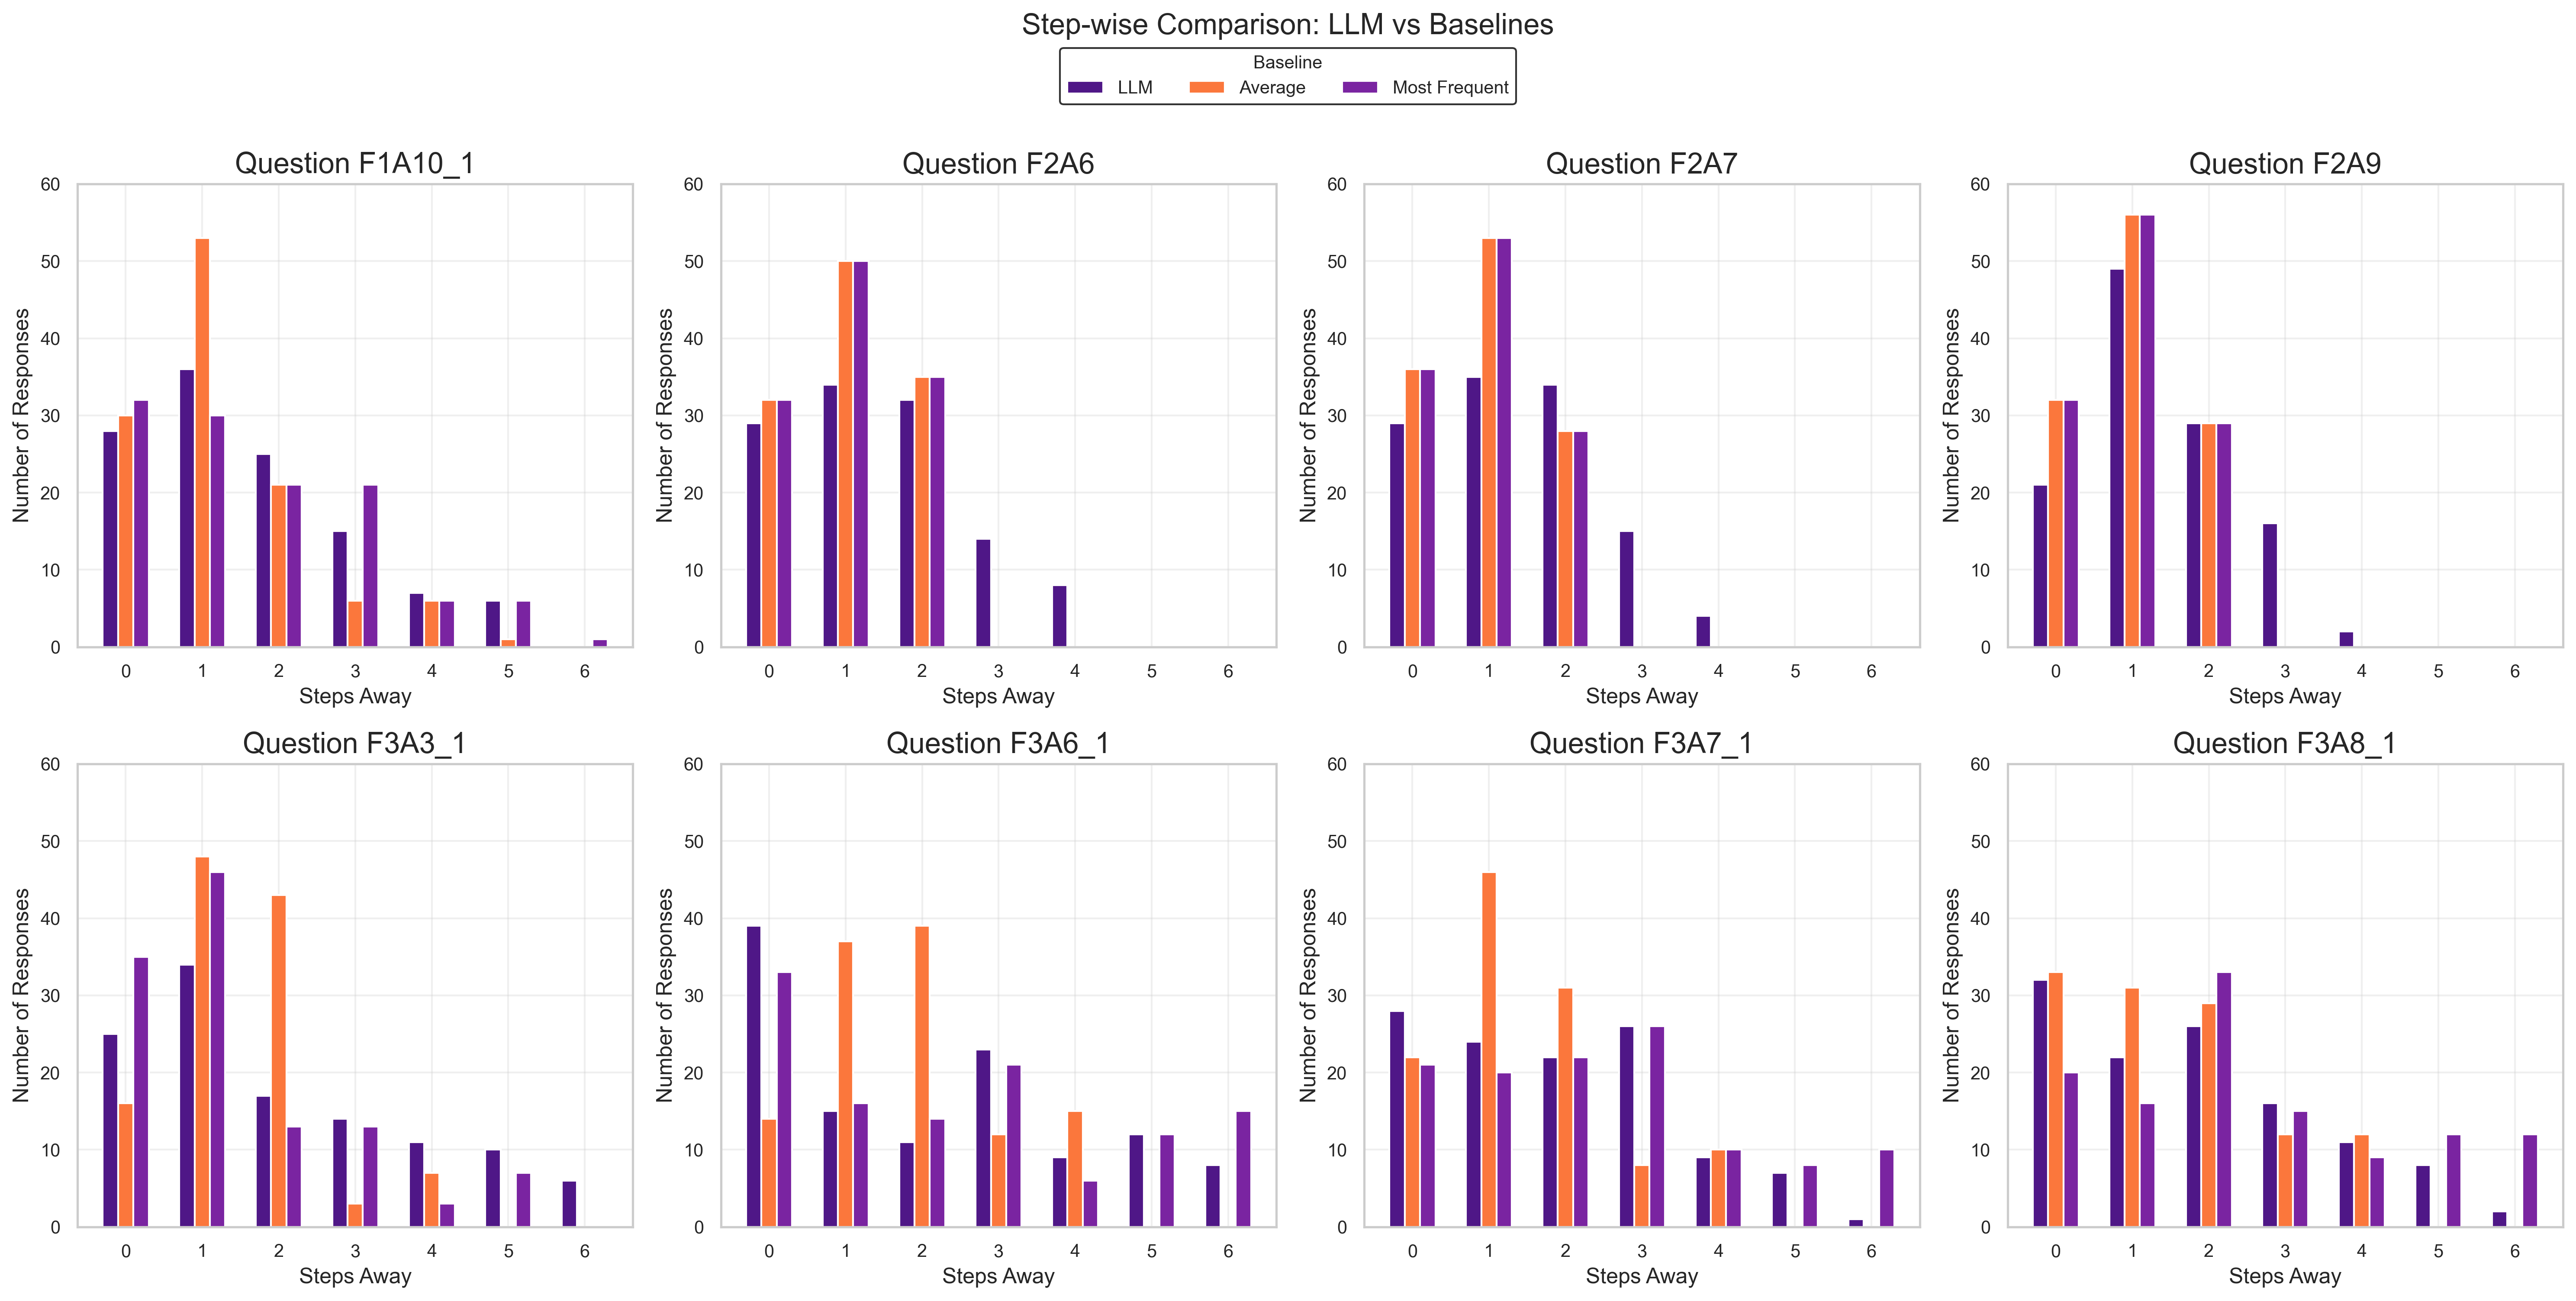

In [410]:
# Call the function
plot_step_wise_comparison_subplots(step_wise_df)


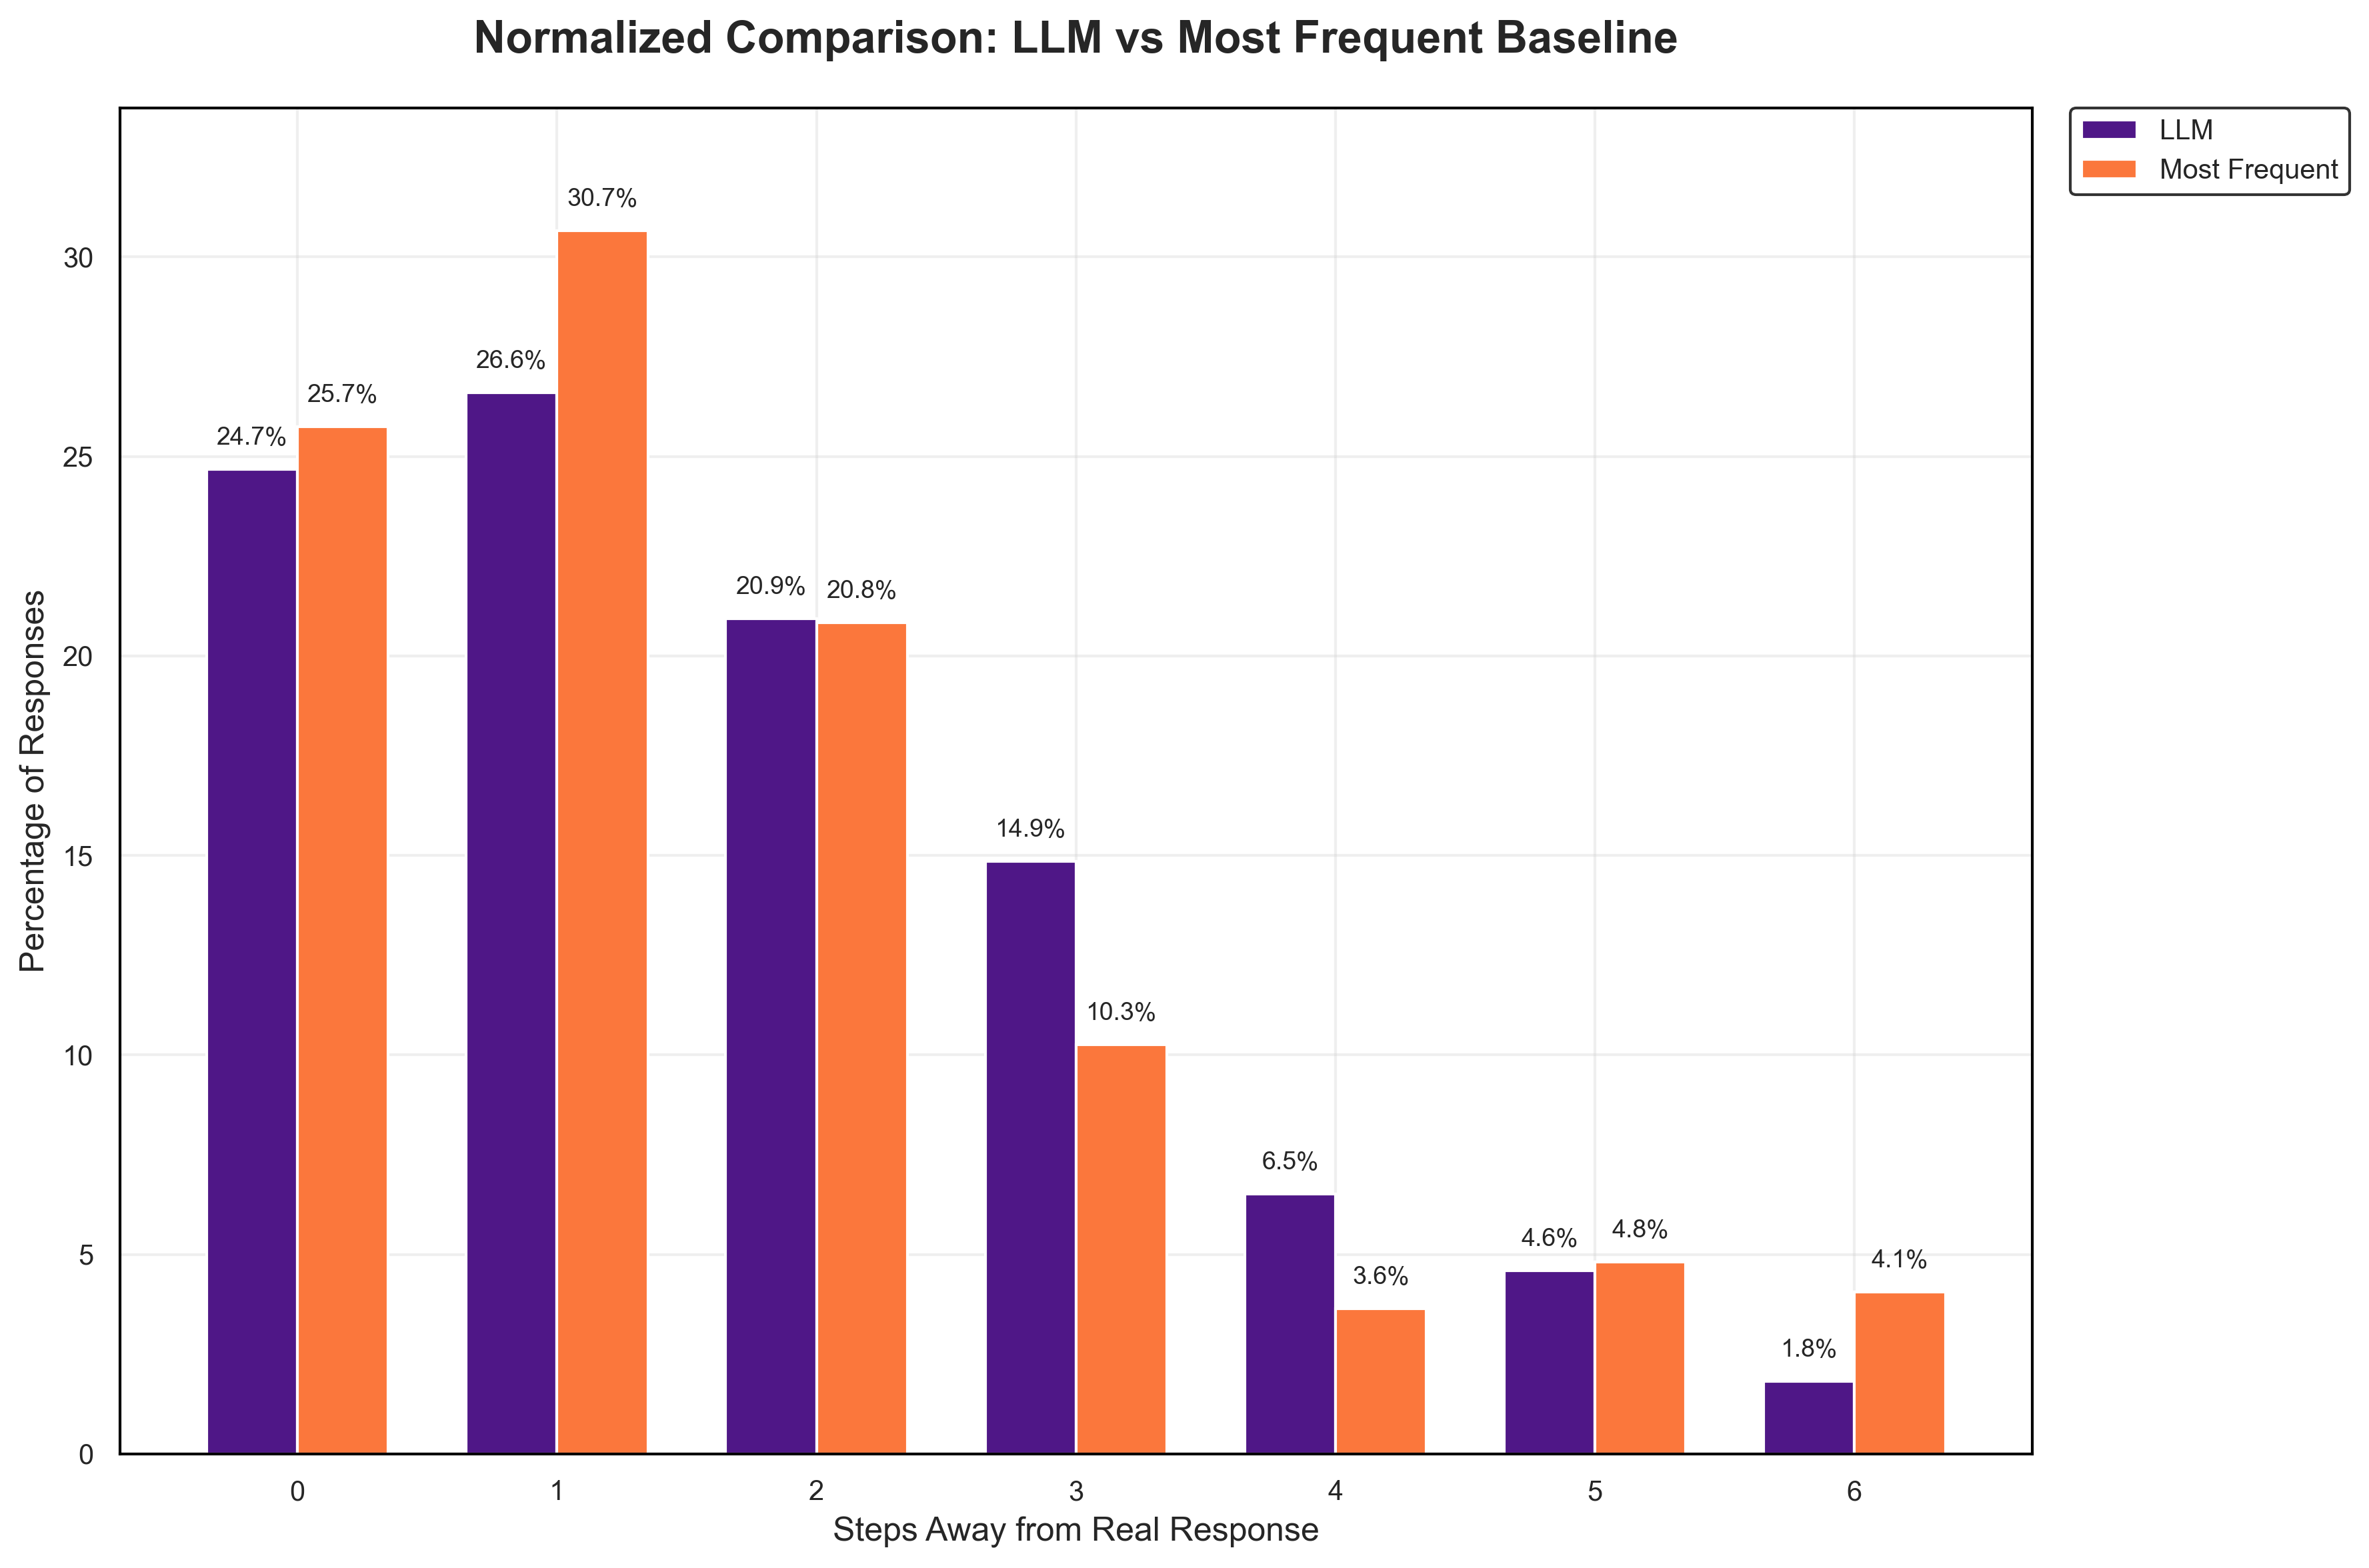


Raw Counts:
   LLM  Most_Frequent
0  231            241
1  249            287
2  196            195
3  139             96
4   61             34
5   43             45
6   17             38

Normalized Counts (%):
         LLM  Most_Frequent
0  24.679487      25.747863
1  26.602564      30.662393
2  20.940171      20.833333
3  14.850427      10.256410
4   6.517094       3.632479
5   4.594017       4.807692
6   1.816239       4.059829


In [412]:
def plot_normalized_comparison(normalized_counts):
    """
    Create a publication-ready bar plot comparing normalized LLM and Most Frequent baseline responses.
    
    Parameters:
    - normalized_counts (pd.DataFrame): DataFrame with normalized comparison data
    """
    # Set the publication style
    PublicationStyle.set_style()
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot bars
    bar_width = 0.35
    x = np.arange(len(normalized_counts.index))
    
    # Use publication colors
    llm_bars = ax.bar(x - bar_width/2, normalized_counts['LLM'], 
                      bar_width, label='LLM', 
                      color=PublicationStyle.MAIN_COLORS['primary'])
    mf_bars = ax.bar(x + bar_width/2, normalized_counts['Most_Frequent'],
                     bar_width, label='Most Frequent', 
                     color=PublicationStyle.MAIN_COLORS['secondary'])
    
    # Add percentage labels on top of bars with publication font size
    for bars in [llm_bars, mf_bars]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.5,
                   f'{height:.1f}%',
                   ha='center', va='bottom',
                   fontsize=PublicationStyle.FONT_SIZES['annotation'])
    
    # Customize axis
    PublicationStyle.format_axis(
        ax,
        title='Normalized Comparison: LLM vs Most Frequent Baseline',
        xlabel='Steps Away from Real Response',
        ylabel='Percentage of Responses',
        xticks=(x, normalized_counts.index)
    )
    
    # Customize legend
    ax.legend(
        bbox_to_anchor=(1.02, 1),
        loc='upper left',
        borderaxespad=0,
        frameon=True
    )
    
    # Set y-axis limits with some padding for labels
    ax.set_ylim(0, max(normalized_counts.max()) * 1.1)
    
    # Add grid with lower opacity
    ax.grid(True, alpha=0.3, axis='y')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return fig, ax

# Generate the comparison data
normalized_counts, raw_counts = create_normalized_comparison(step_wise_df)

# Create and show the plot
fig, ax = plot_normalized_comparison(normalized_counts)

# Optionally save the figure
# PublicationStyle.save_figure(fig, 'normalized_comparison.png')
plt.show()

# Print raw numbers for reference
print("\nRaw Counts:")
print(raw_counts)
print("\nNormalized Counts (%):")
print(normalized_counts)


Raw Numbers:
LLM:
Total responses: 936
Average responses per question: 117.00

Most Frequent:
Total responses: 936
Average responses per question: 117.00


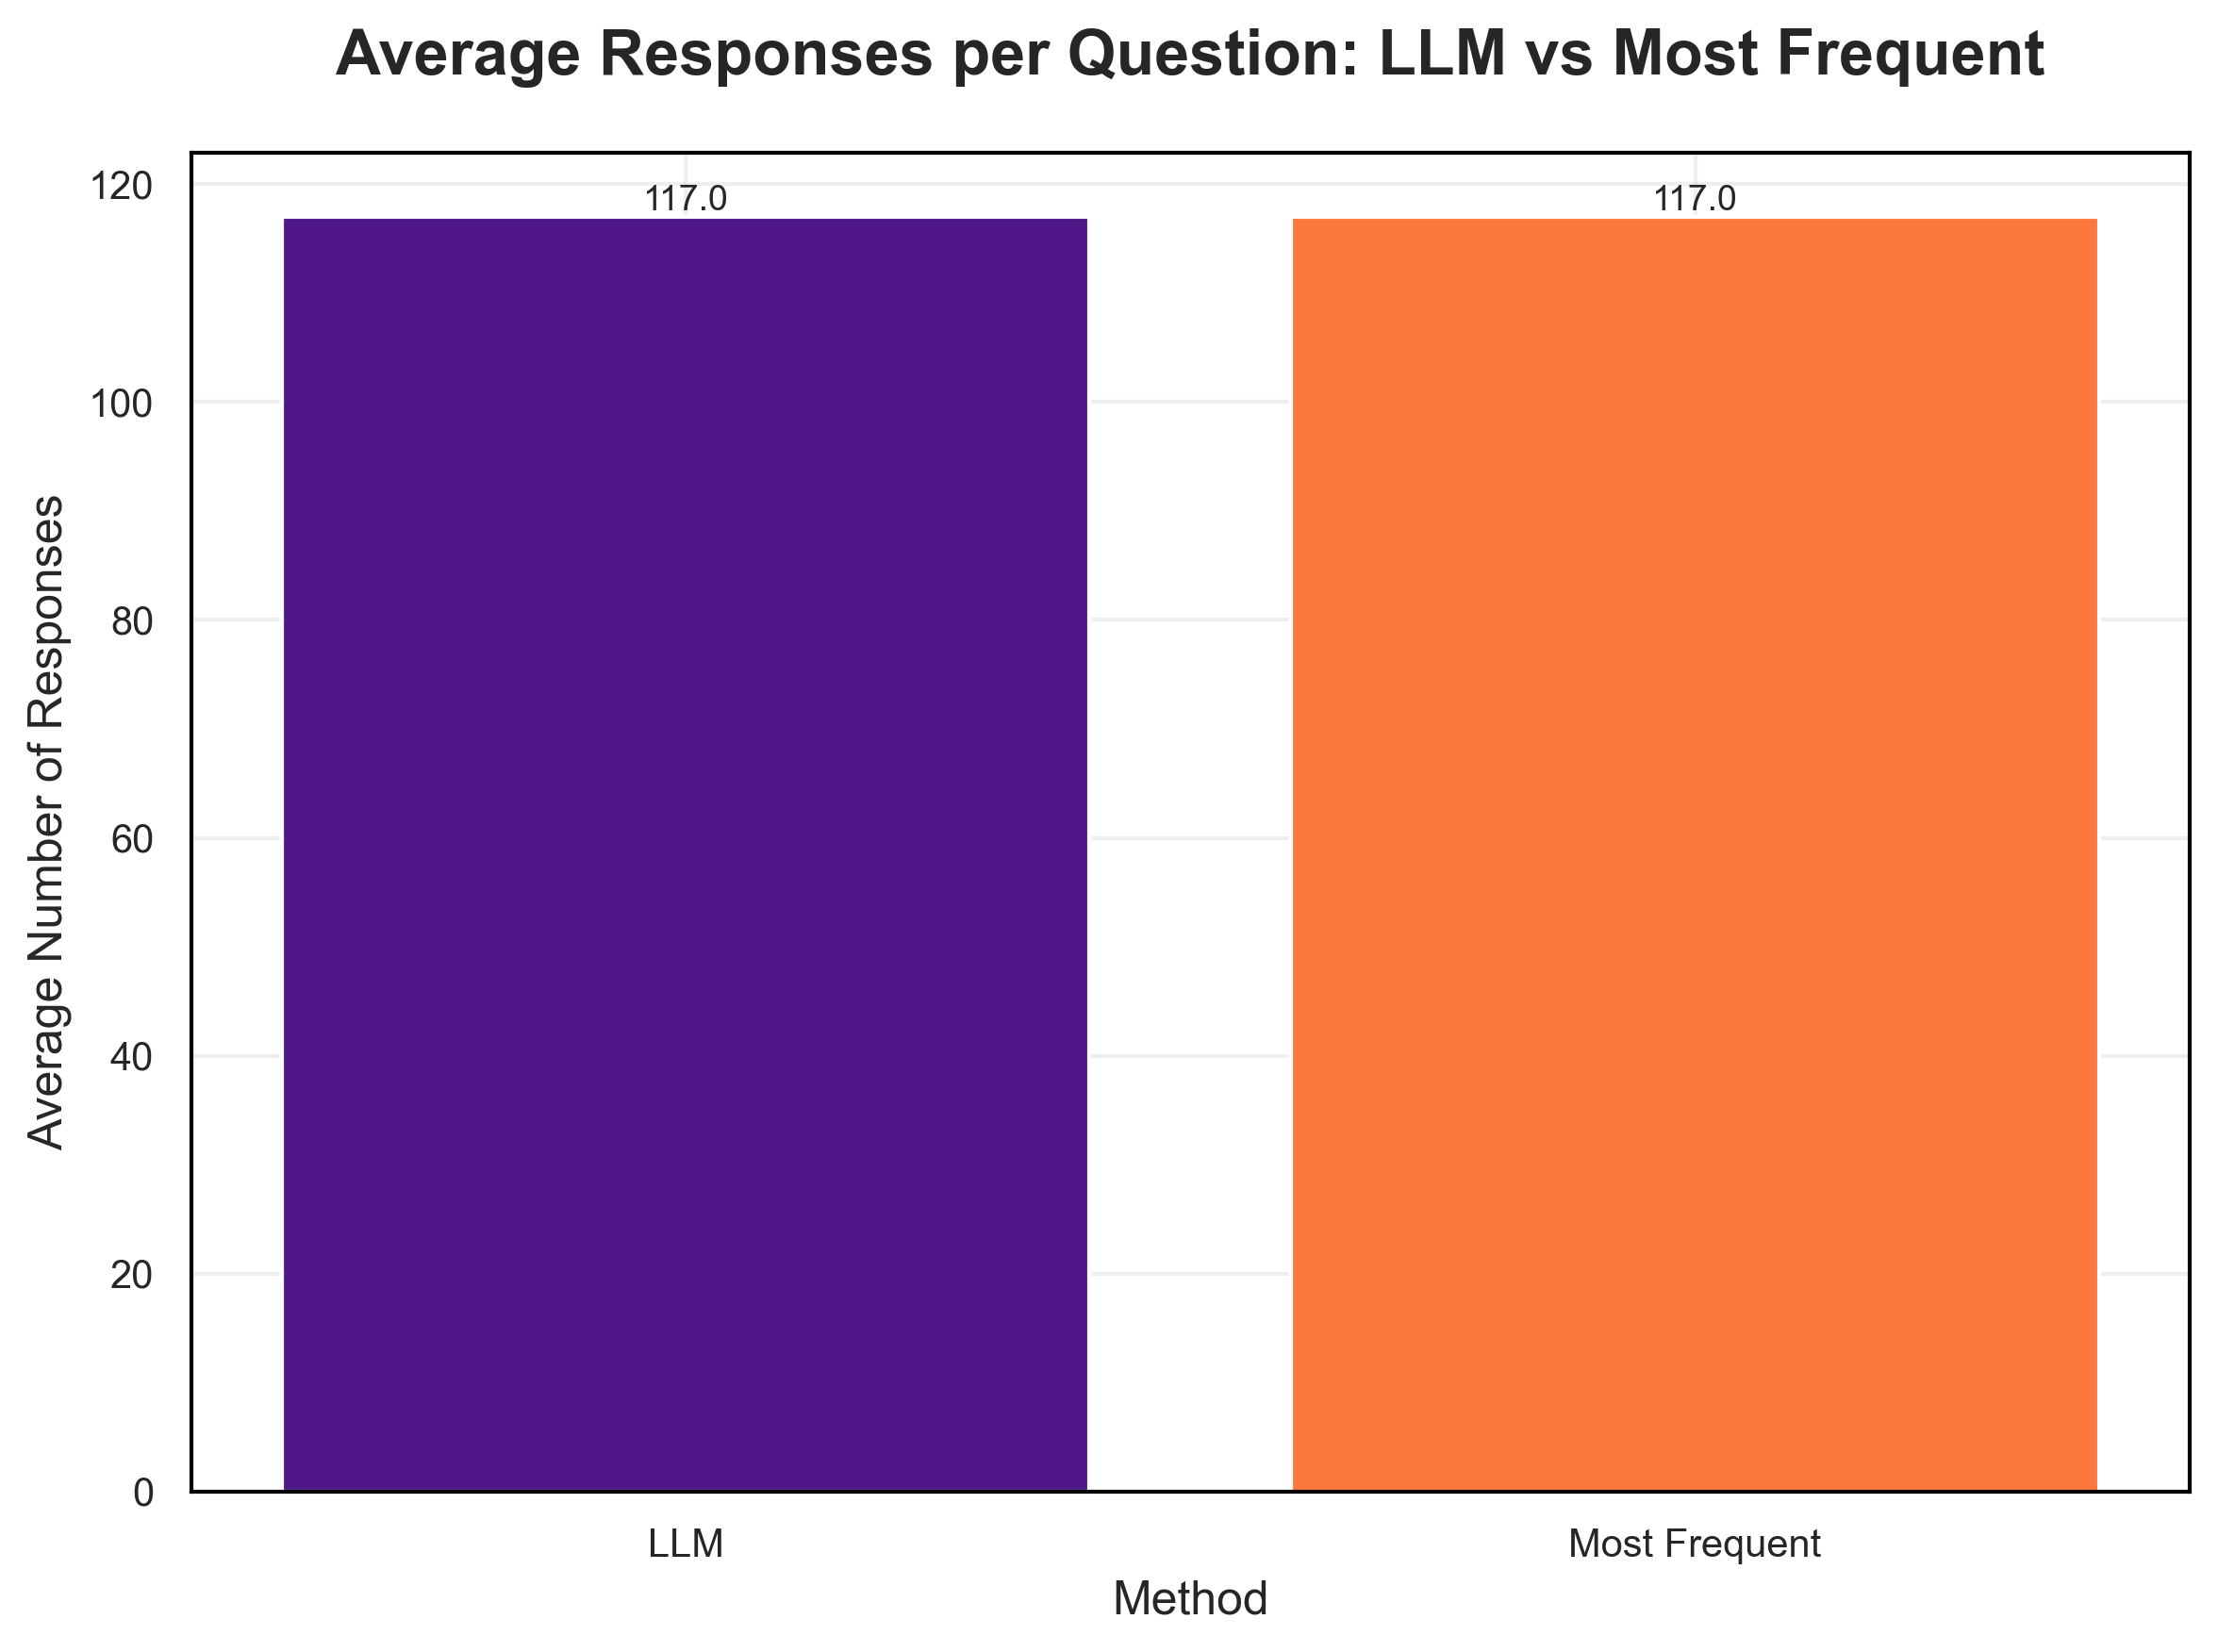

In [413]:
def create_method_comparison(step_wise_df):
    """
    Create an aggregated comparison between LLM and Most Frequent methods.
    
    Parameters:
    - step_wise_df (pd.DataFrame): DataFrame with step-wise comparison data
    
    Returns:
    - Dict with average responses and raw counts
    """
    # Calculate total responses for each method
    results = {
        'LLM': {
            'total_responses': len(step_wise_df),
            'avg_responses_per_question': len(step_wise_df) / len(step_wise_df['question_code'].unique())
        },
        'Most_Frequent': {
            'total_responses': len(step_wise_df),
            'avg_responses_per_question': len(step_wise_df) / len(step_wise_df['question_code'].unique())
        }
    }
    
    return results

def plot_method_comparison(results):
    """
    Create a bar plot comparing LLM and Most Frequent methods.
    """
    # Set the publication style
    PublicationStyle.set_style()
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Prepare data
    methods = ['LLM', 'Most Frequent']
    avg_responses = [results['LLM']['avg_responses_per_question'],
                    results['Most_Frequent']['avg_responses_per_question']]
    
    # Plot bars
    bars = ax.bar(methods, avg_responses, 
                  color=[PublicationStyle.MAIN_COLORS['primary'],
                        PublicationStyle.MAIN_COLORS['secondary']])
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height,
               f'{height:.1f}',
               ha='center', va='bottom',
               fontsize=PublicationStyle.FONT_SIZES['annotation'])
    
    # Customize axis
    PublicationStyle.format_axis(
        ax,
        title='Average Responses per Question: LLM vs Most Frequent',
        xlabel='Method',
        ylabel='Average Number of Responses'
    )
    
    # Add grid
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig, ax

# Generate the comparison data
results = create_method_comparison(step_wise_df)

# Create and show the plot
fig, ax = plot_method_comparison(results)

# Print raw numbers
print("\nRaw Numbers:")
print("LLM:")
print(f"Total responses: {results['LLM']['total_responses']}")
print(f"Average responses per question: {results['LLM']['avg_responses_per_question']:.2f}")
print("\nMost Frequent:")
print(f"Total responses: {results['Most_Frequent']['total_responses']}")
print(f"Average responses per question: {results['Most_Frequent']['avg_responses_per_question']:.2f}")


Raw Numbers:

LLM:
Total exact matches: 231
Average success rate: 24.7%

Most Frequent:
Total exact matches: 241
Average success rate: 25.7%


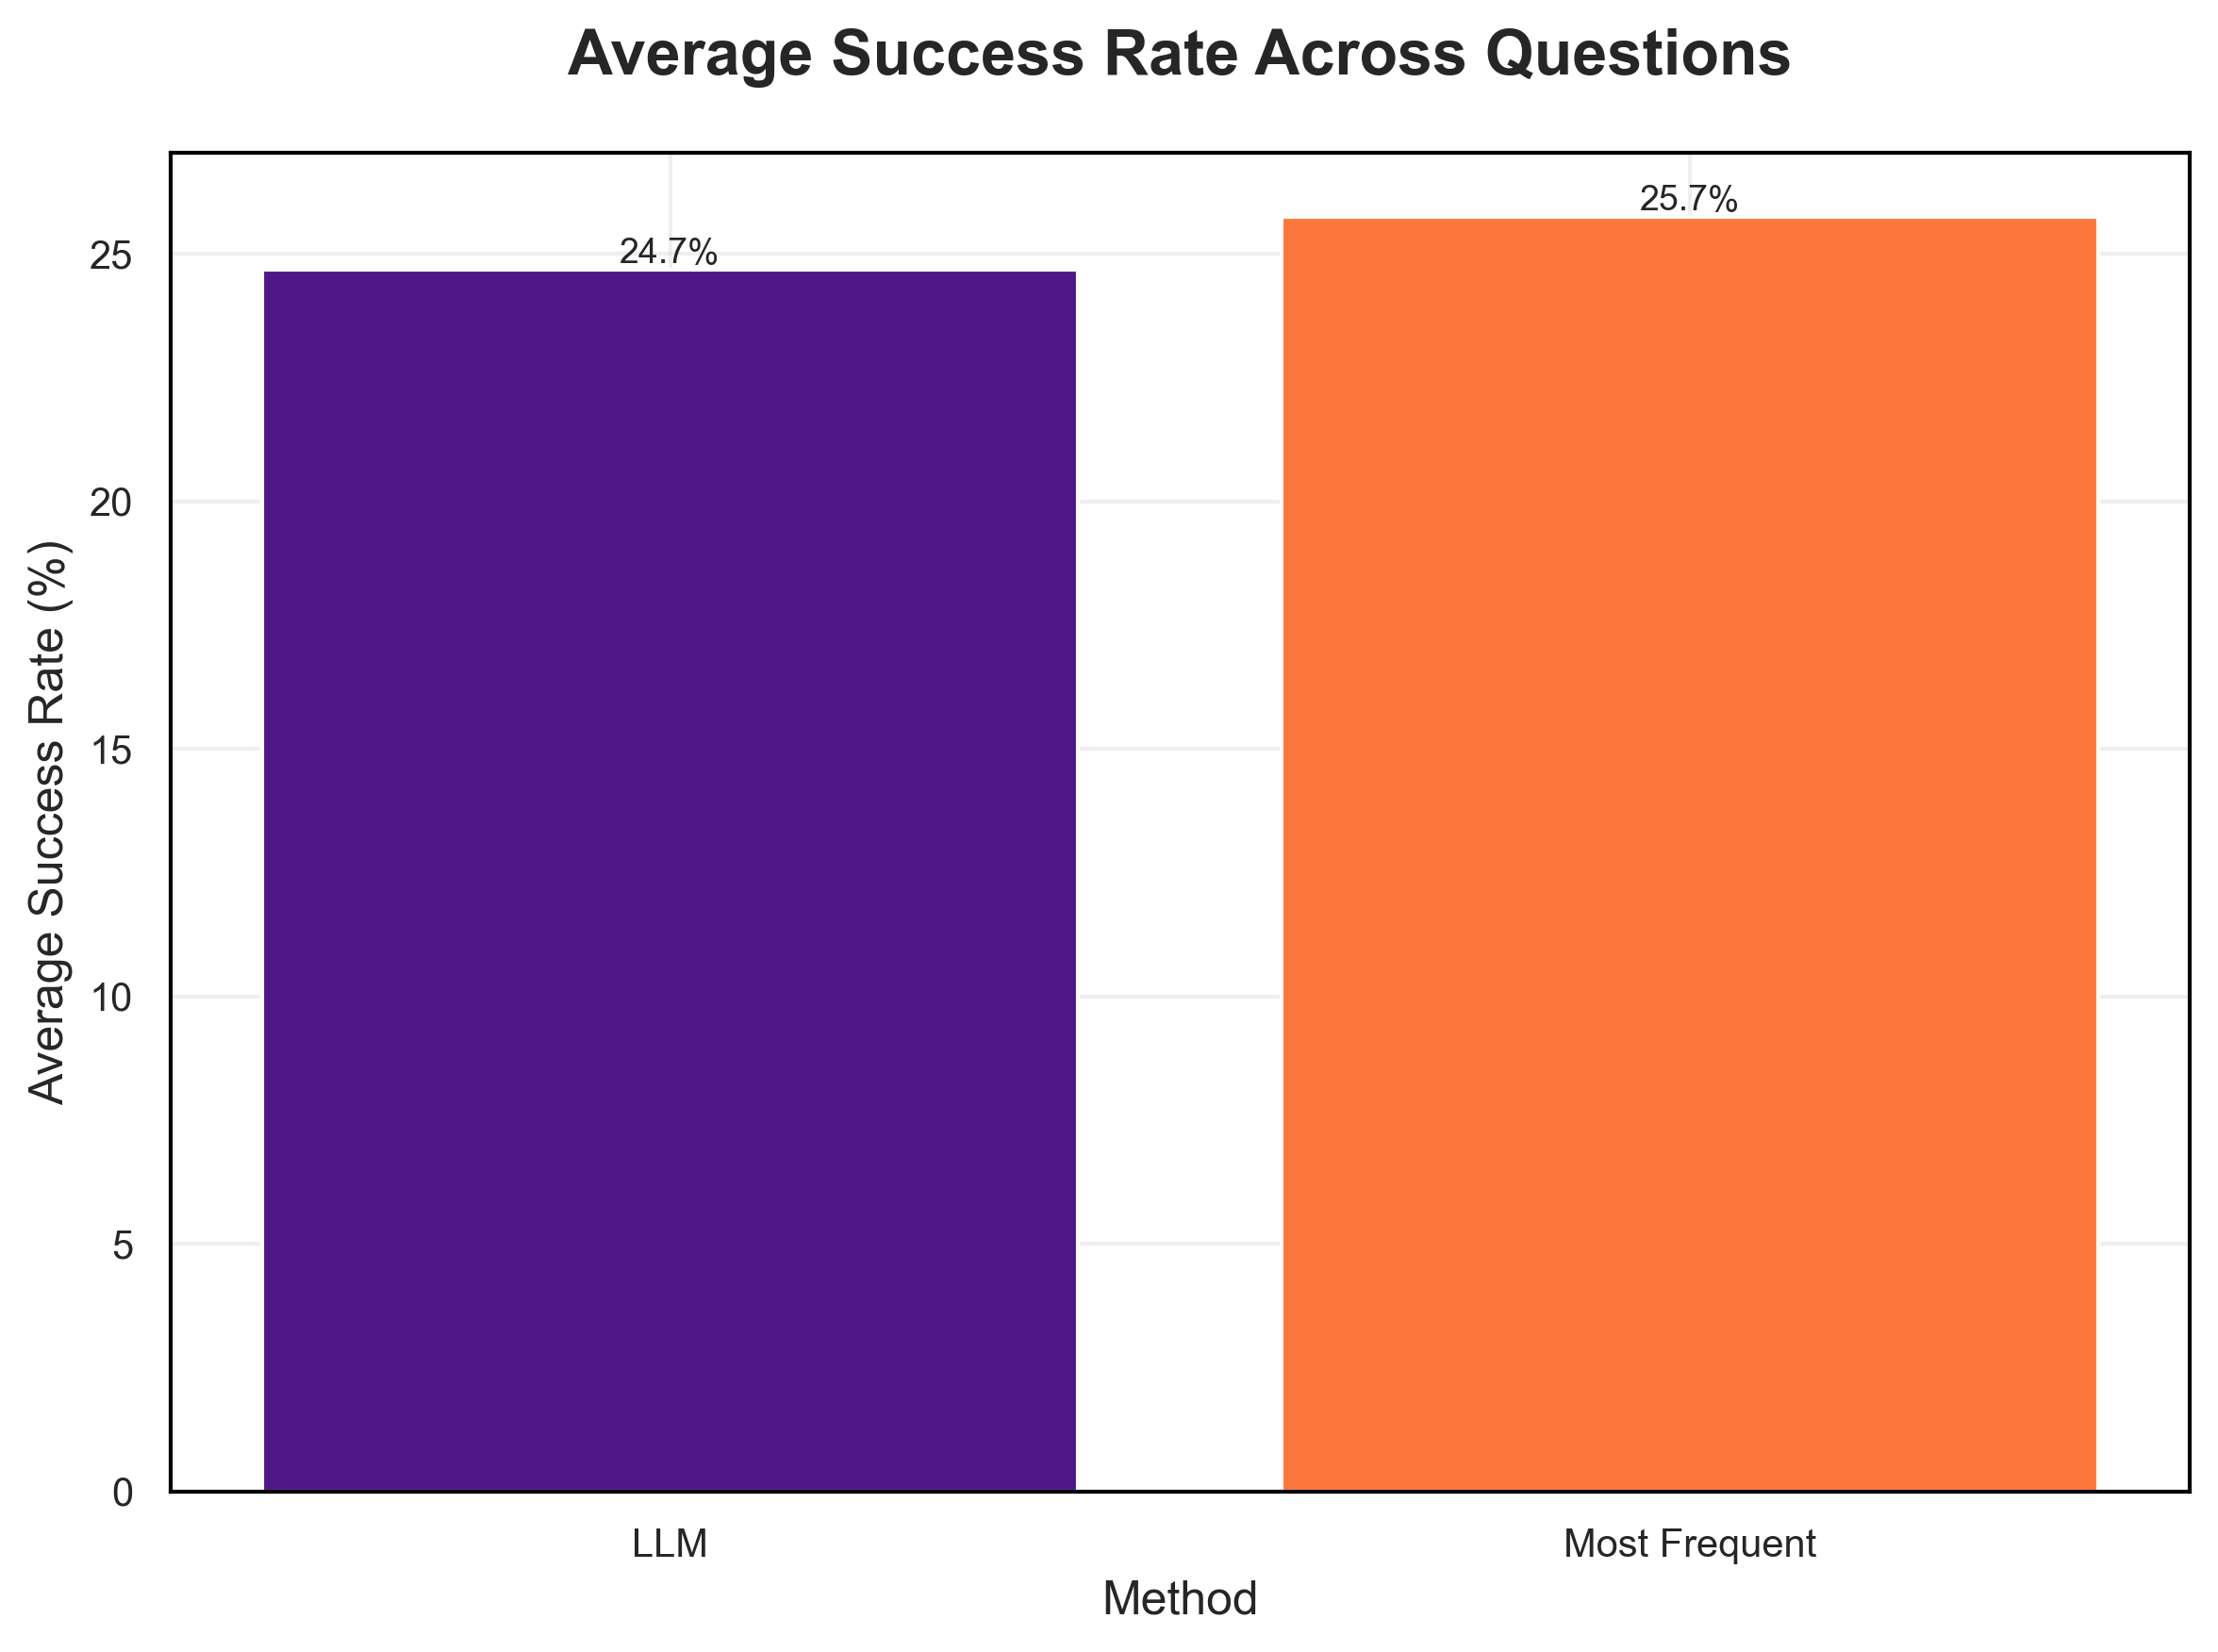

In [ ]:
def calculate_average_success(step_wise_df):
    """
    Calculate the average success rate for LLM and Most Frequent across all questions.
    Success is defined as getting the exact correct answer (0 steps away).
    """
    # Count successful responses (0 steps away) for each question
    llm_success = (step_wise_df['llm_steps_away'] == 0).groupby(step_wise_df['question_code']).mean() * 100
    mf_success = (step_wise_df['mf_steps_away'] == 0).groupby(step_wise_df['question_code']).mean() * 100
    
    results = {
        'LLM': {
            'average_success': llm_success.mean(),
            'raw_successes': (step_wise_df['llm_steps_away'] == 0).sum(),
            'per_question_success': llm_success
        },
        'Most_Frequent': {
            'average_success': mf_success.mean(),
            'raw_successes': (step_wise_df['mf_steps_away'] == 0).sum(),
            'per_question_success': mf_success
        }
    }
    
    return results

def plot_average_success(results):
    """
    Create a bar plot comparing average success rates of LLM and Most Frequent.
    """
    PublicationStyle.set_style()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    methods = ['LLM', 'Most Frequent']
    success_rates = [results['LLM']['average_success'],
                    results['Most_Frequent']['average_success']]
    
    bars = ax.bar(methods, success_rates,
                  color=[PublicationStyle.MAIN_COLORS['primary'],
                        PublicationStyle.MAIN_COLORS['secondary']])
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height,
               f'{height:.1f}%',
               ha='center', va='bottom',
               fontsize=PublicationStyle.FONT_SIZES['annotation'])
    
    PublicationStyle.format_axis(
        ax,
        title='Average Success Rate Across Questions',
        xlabel='Method',
        ylabel='Average Success Rate (%)'
    )
    
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    return fig, ax

# Calculate and show results
results = calculate_average_success(step_wise_df)

# Create plot
fig, ax = plot_average_success(results)

# Print raw numbers
print("\nRaw Numbers:")
print("\nLLM:")
print(f"Total exact matches: {results['LLM']['raw_successes']}")
print(f"Average success rate: {results['LLM']['average_success']:.1f}%")
print("\nMost Frequent:")
print(f"Total exact matches: {results['Most_Frequent']['raw_successes']}")
print(f"Average success rate: {results['Most_Frequent']['average_success']:.1f}%")

plt.show()


Detailed Results:

LLM:
Average weighted success rate: 55.1%
Raw score total: 515.8

Most Frequent:
Average weighted success rate: 59.2%
Raw score total: 553.8


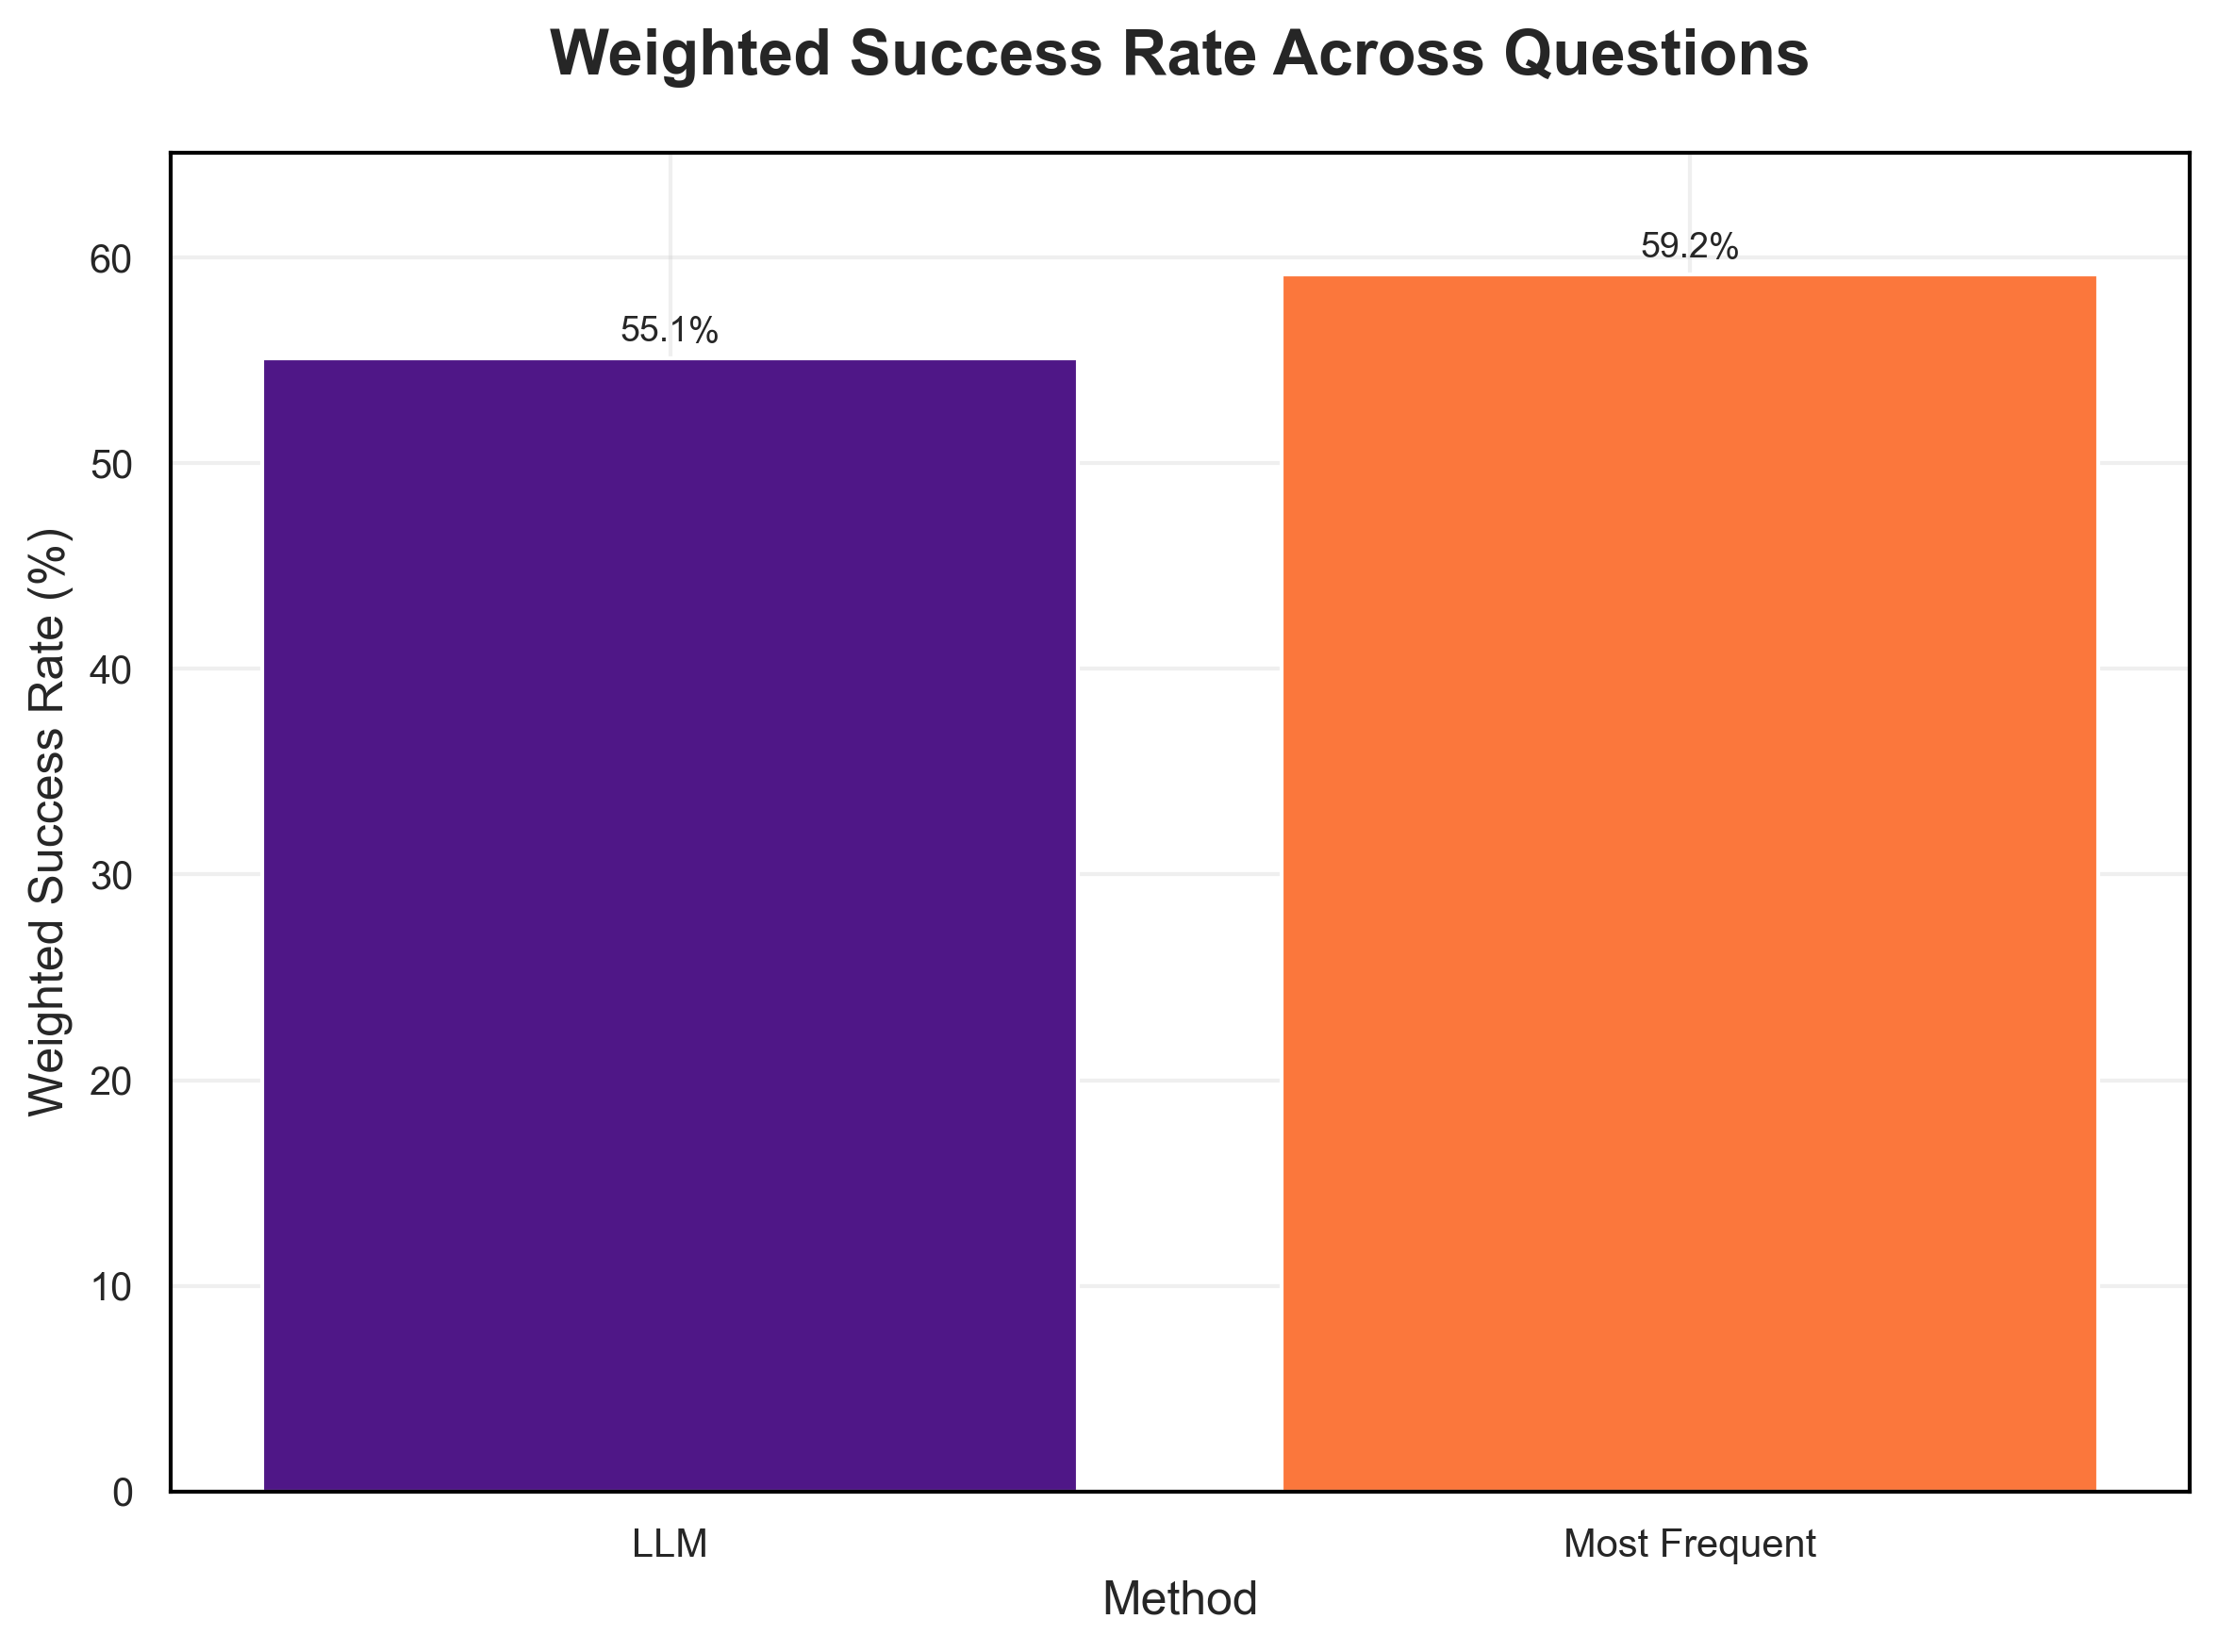

In [417]:
def calculate_weighted_success(step_wise_df):
    """
    Calculate weighted success rate where:
    - Exact match (0 steps) = 100% credit
    - 1 step away = 75% credit
    - 2 steps away = 50% credit
    """
    def get_weighted_score(steps):
        if steps == 0:
            return 1.0
        elif steps == 1:
            return 0.75
        elif steps == 2:
            return 0.50
        else:
            return 0.0
    
    llm_scores = step_wise_df['llm_steps_away'].apply(get_weighted_score)
    mf_scores = step_wise_df['mf_steps_away'].apply(get_weighted_score)
    
    # Calculate per-question averages first
    llm_question_scores = llm_scores.groupby(step_wise_df['question_code']).mean()
    mf_question_scores = mf_scores.groupby(step_wise_df['question_code']).mean()
    
    results = {
        'LLM': {
            'average_success': llm_question_scores.mean() * 100,  # Average across questions
            'raw_score': llm_scores.sum(),
            'per_question_success': llm_question_scores * 100
        },
        'Most_Frequent': {
            'average_success': mf_question_scores.mean() * 100,  # Average across questions
            'raw_score': mf_scores.sum(),
            'per_question_success': mf_question_scores * 100
        }
    }
    
    return results

def plot_weighted_success(results):
    """
    Create a publication-quality bar plot comparing weighted success rates.
    """
    PublicationStyle.set_style()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    methods = ['LLM', 'Most Frequent']
    success_rates = [results['LLM']['average_success'],
                    results['Most_Frequent']['average_success']]
    
    bars = ax.bar(methods, success_rates,
                  color=[PublicationStyle.MAIN_COLORS['primary'],
                        PublicationStyle.MAIN_COLORS['secondary']])
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.5,
               f'{height:.1f}%',
               ha='center', va='bottom',
               fontsize=PublicationStyle.FONT_SIZES['annotation'])
    
    PublicationStyle.format_axis(
        ax,
        title='Weighted Success Rate Across Questions',
        xlabel='Method',
        ylabel='Weighted Success Rate (%)'
    )
    
    # Customize y-axis to start from 0
    ax.set_ylim(0, max(success_rates) * 1.1)
    
    # Add subtle grid
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    return fig, ax

# Calculate and show results
results = calculate_weighted_success(step_wise_df)

# Create plot
fig, ax = plot_weighted_success(results)

# Print raw numbers
print("\nDetailed Results:")
print("\nLLM:")
print(f"Average weighted success rate: {results['LLM']['average_success']:.1f}%")
print(f"Raw score total: {results['LLM']['raw_score']:.1f}")
print("\nMost Frequent:")
print(f"Average weighted success rate: {results['Most_Frequent']['average_success']:.1f}%")
print(f"Raw score total: {results['Most_Frequent']['raw_score']:.1f}")

plt.show()

In [418]:
def calculate_comprehensive_metrics(step_wise_df):
    """
    Calculate both MAE/MSE and weighted success metrics
    """
    # MAE calculation
    llm_mae = abs(step_wise_df['llm_steps_away']).mean()
    mf_mae = abs(step_wise_df['mf_steps_away']).mean()
    
    # MSE calculation
    llm_mse = (step_wise_df['llm_steps_away'] ** 2).mean()
    mf_mse = (step_wise_df['mf_steps_away'] ** 2).mean()
    
    # Weighted success (per question average)
    def get_weighted_score(steps):
        if steps == 0:
            return 1.0
        elif steps == 1:
            return 0.75
        elif steps == 2:
            return 0.50
        else:
            return 0.0
    
    llm_scores = step_wise_df.groupby('question_code')['llm_steps_away'].apply(
        lambda x: x.apply(get_weighted_score).mean()
    )
    mf_scores = step_wise_df.groupby('question_code')['mf_steps_away'].apply(
        lambda x: x.apply(get_weighted_score).mean()
    )

    return {
        'LLM': {
            'mae': llm_mae,
            'mse': llm_mse,
            'weighted_success': llm_scores.mean() * 100
        },
        'Most_Frequent': {
            'mae': mf_mae,
            'mse': mf_mse,
            'weighted_success': mf_scores.mean() * 100
        }
    }

# Calculate and print all metrics
results = calculate_comprehensive_metrics(step_wise_df)
print("\nComprehensive Metrics:")
for method in ['LLM', 'Most_Frequent']:
    print(f"\n{method}:")
    print(f"MAE: {results[method]['mae']:.3f}")
    print(f"MSE: {results[method]['mse']:.3f}")
    print(f"Weighted Success: {results[method]['weighted_success']:.1f}%")


Comprehensive Metrics:

LLM:
MAE: 1.730
MSE: 5.285
Weighted Success: 55.1%

Most_Frequent:
MAE: 1.660
MSE: 5.308
Weighted Success: 59.2%


In [420]:
def calculate_average_matches(step_wise_df):
    """
    Calculate average number of exact matches (0 steps away) per question
    """
    # Group by question and count exact matches (0 steps away)
    llm_matches = (step_wise_df['llm_steps_away'] == 0).groupby(step_wise_df['question_code']).sum()
    mf_matches = (step_wise_df['mf_steps_away'] == 0).groupby(step_wise_df['question_code']).sum()
    
    results = {
        'LLM': {
            'matches_per_question': llm_matches.values,
            'average_matches': llm_matches.mean(),
            'total_matches': llm_matches.sum()
        },
        'Most_Frequent': {
            'matches_per_question': mf_matches.values,
            'average_matches': mf_matches.mean(),
            'total_matches': mf_matches.sum()
        }
    }
    
    return results

# Calculate results
results = calculate_average_matches(step_wise_df)

# Print raw numbers
print("Raw Numbers:")
print("\nLLM:")
print(f"Total exact matches: {results['LLM']['total_matches']}")
print(f"Average matches per question: {results['LLM']['average_matches']:.2f}")
print("Matches by question:", results['LLM']['matches_per_question'])

print("\nMost Frequent:")
print(f"Total exact matches: {results['Most_Frequent']['total_matches']}")
print(f"Average matches per question: {results['Most_Frequent']['average_matches']:.2f}")
print("Matches by question:", results['Most_Frequent']['matches_per_question'])

Raw Numbers:

LLM:
Total exact matches: 231
Average matches per question: 28.88
Matches by question: [28 29 29 21 25 39 28 32]

Most Frequent:
Total exact matches: 241
Average matches per question: 30.12
Matches by question: [32 32 36 32 35 33 21 20]



Raw Numbers:
LLM average responses per question: 117.00
Most Frequent average responses per question: 117.00


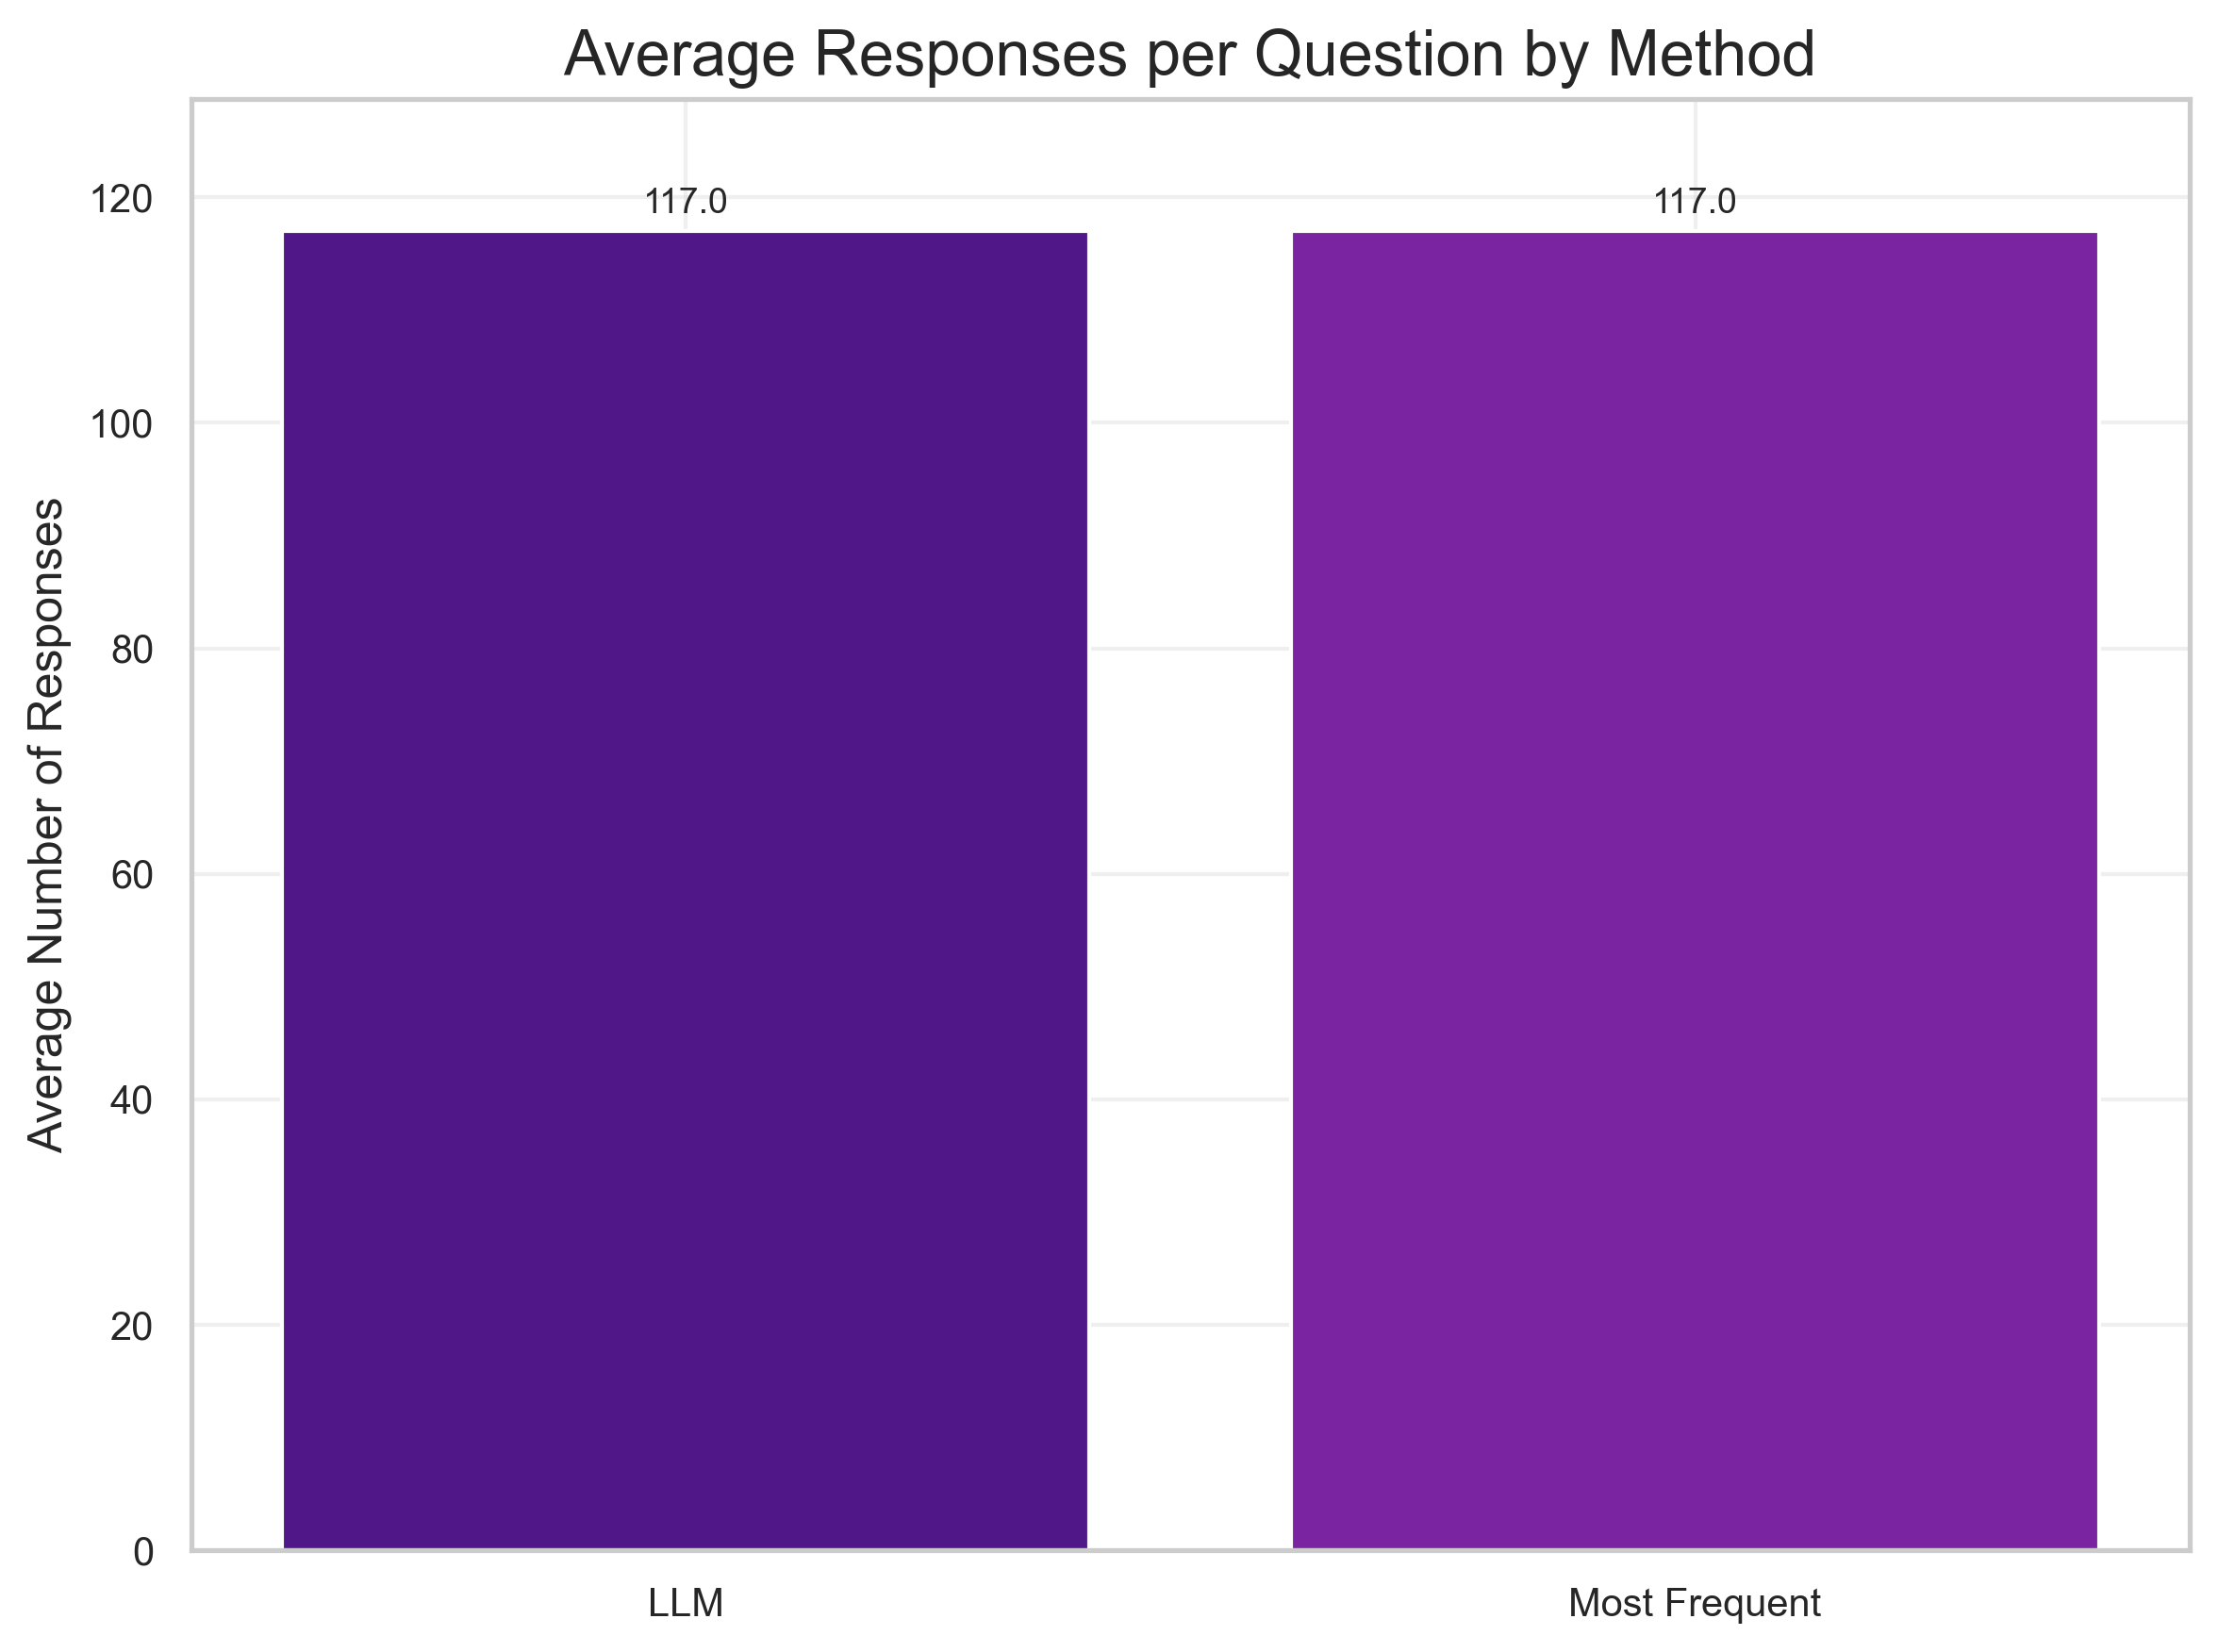


Raw Counts:
   LLM  Most_Frequent
0  231            241
1  249            287
2  196            195
3  139             96
4   61             34
5   43             45
6   17             38

Normalized Counts (%):
         LLM  Most_Frequent
0  24.679487      25.747863
1  26.602564      30.662393
2  20.940171      20.833333
3  14.850427      10.256410
4   6.517094       3.632479
5   4.594017       4.807692
6   1.816239       4.059829


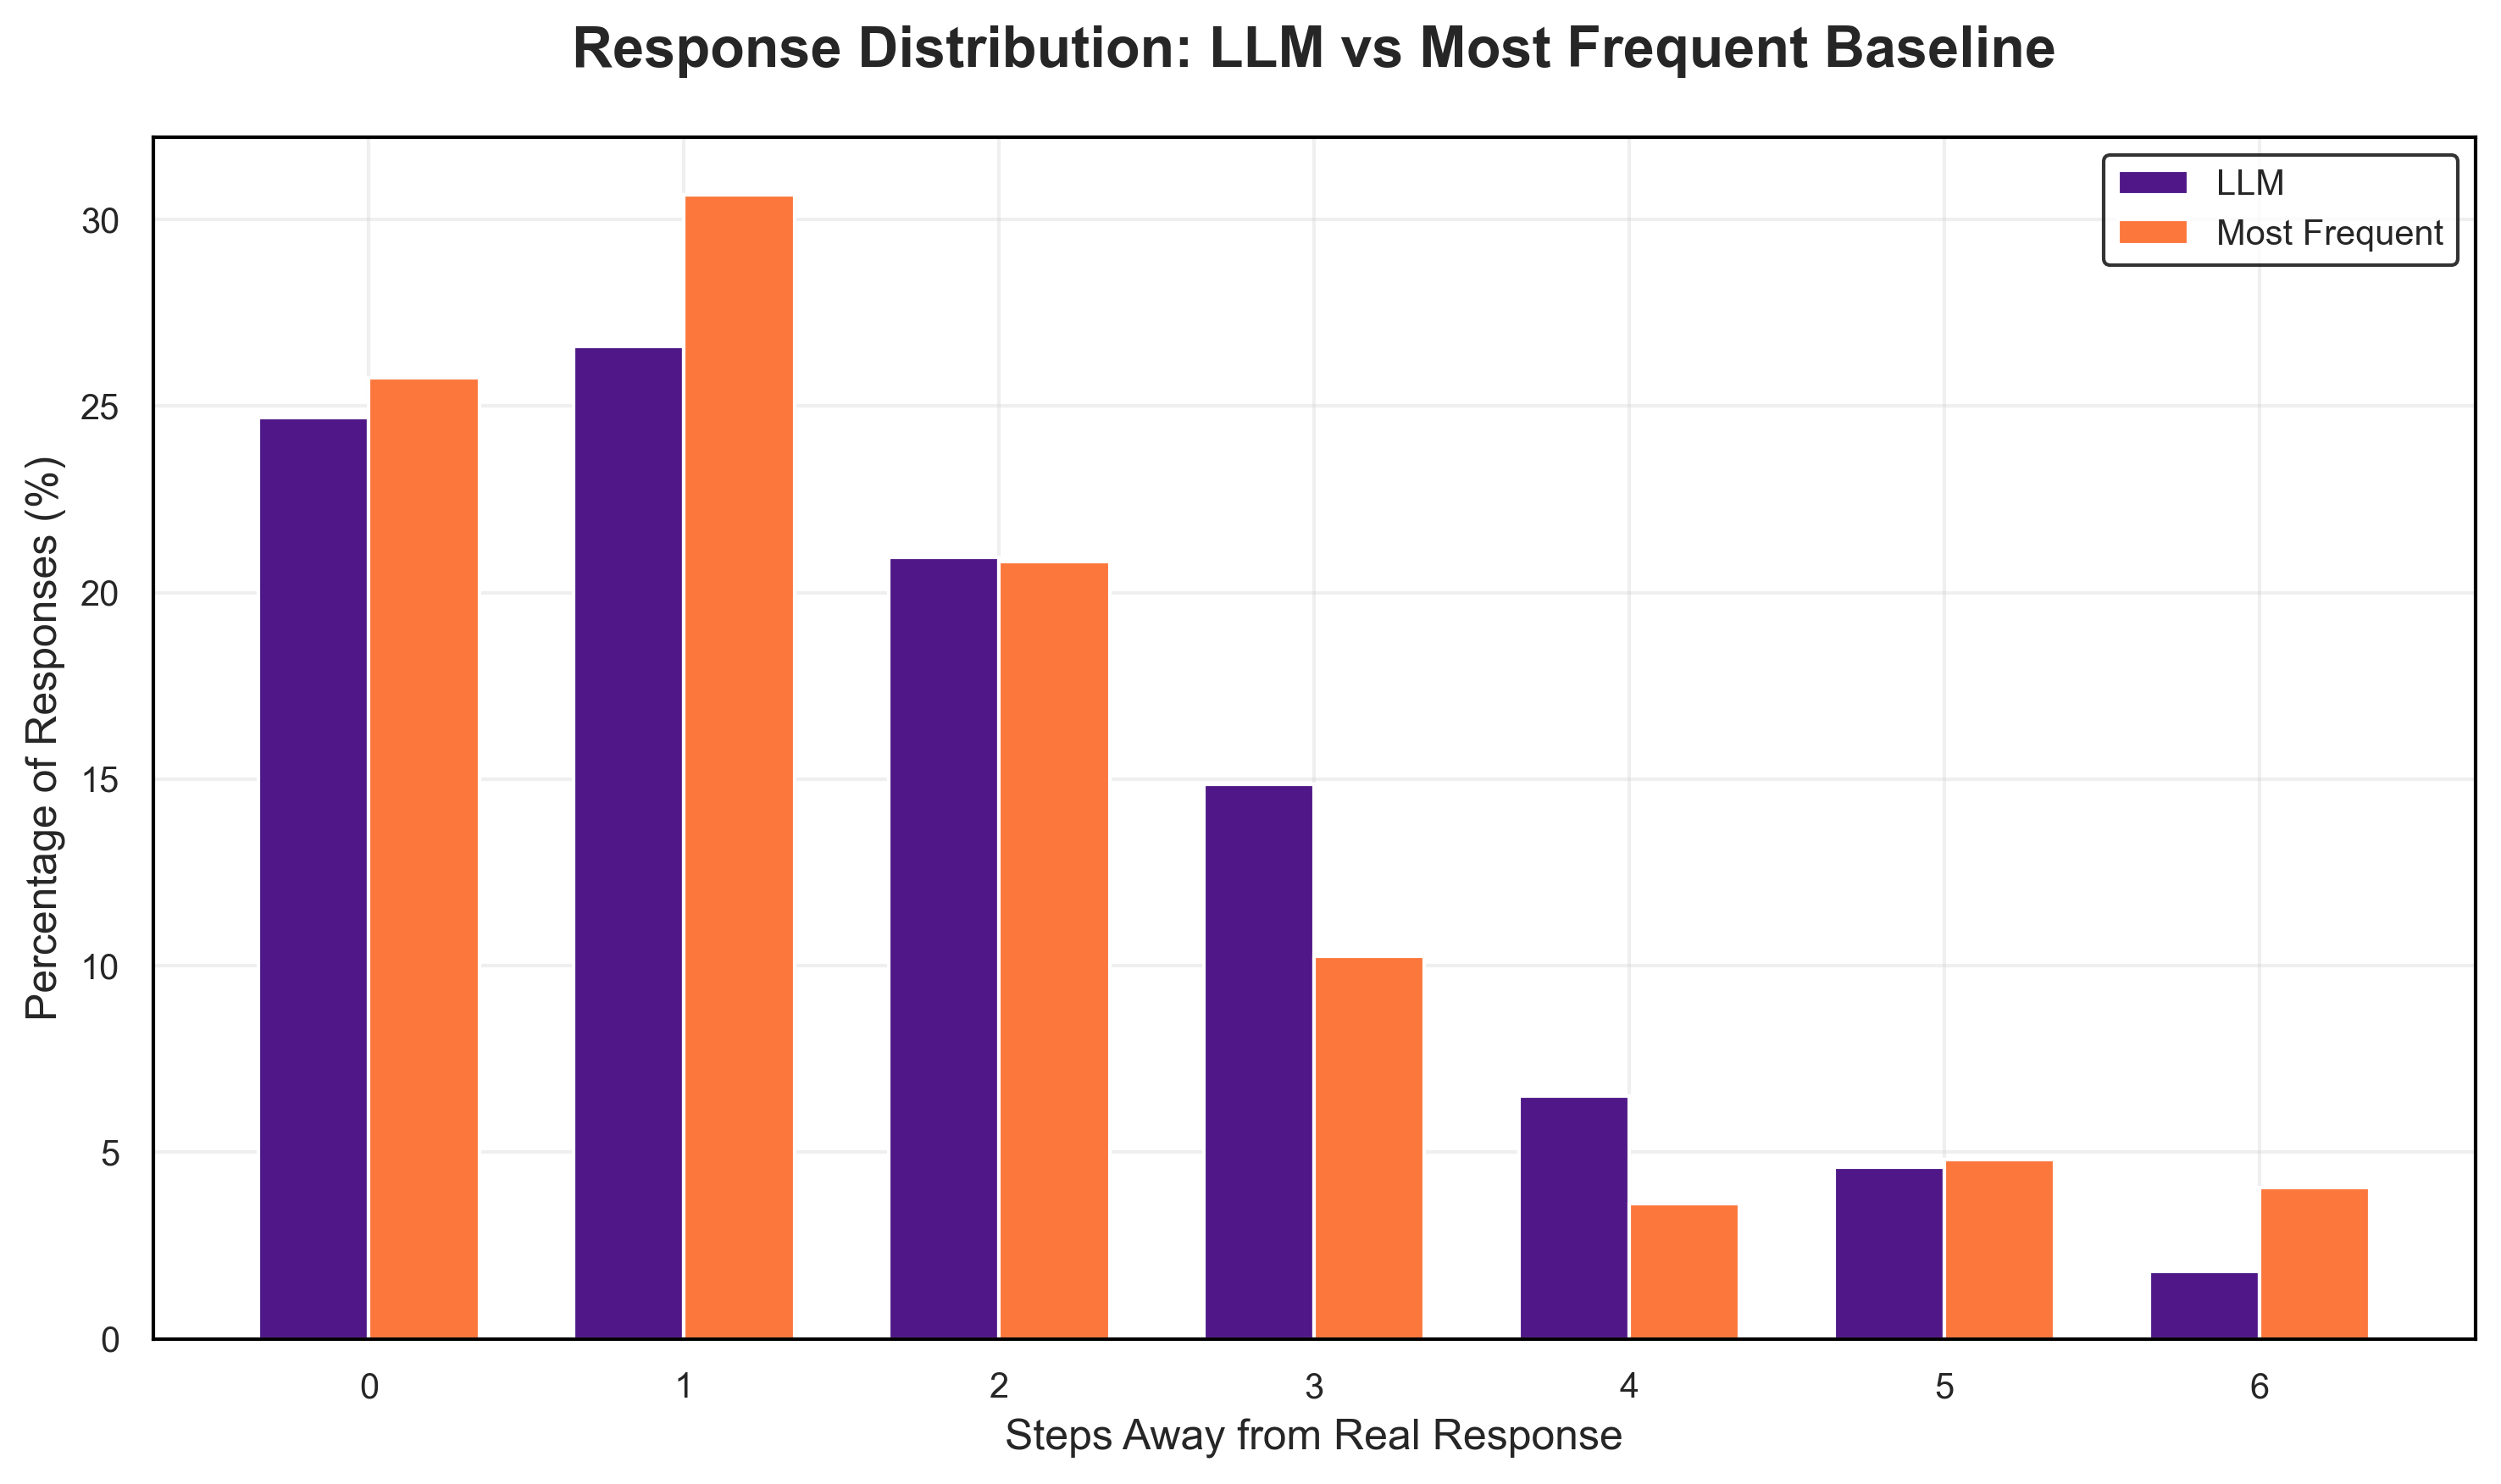

In [423]:
def create_normalized_comparison(step_wise_df):
    """
    Create a normalized comparison between LLM and Most Frequent baseline,
    averaged across all questions.
    
    Parameters:
    ----------
    step_wise_df : pd.DataFrame
        DataFrame containing the step-wise comparison data
        
    Returns:
    -------
    normalized_counts : pd.DataFrame
        Normalized (percentage) counts for each step
    raw_counts : pd.DataFrame
        Raw counts for reference
    """
    # Calculate totals for each method
    total_llm = len(step_wise_df)
    total_mf = len(step_wise_df)
    
    # Count responses for each step
    llm_counts = step_wise_df['llm_steps_away'].value_counts()
    mf_counts = step_wise_df['mf_steps_away'].value_counts()
    
    # Create DataFrame with all steps (0-6)
    all_steps = pd.Index(range(7))
    raw_counts = pd.DataFrame({
        'LLM': llm_counts.reindex(all_steps, fill_value=0),
        'Most_Frequent': mf_counts.reindex(all_steps, fill_value=0)
    })
    
    # Calculate percentages
    normalized_counts = pd.DataFrame({
        'LLM': (raw_counts['LLM'] / total_llm * 100),
        'Most_Frequent': (raw_counts['Most_Frequent'] / total_mf * 100)
    })
    
    return normalized_counts, raw_counts

def plot_normalized_comparison(normalized_counts):
    """
    Create a publication-ready bar plot comparing normalized LLM 
    and Most Frequent baseline responses.
    """
    # Set the publication style
    PublicationStyle.set_style()
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot data
    x = np.arange(len(normalized_counts.index))
    width = 0.35
    
    ax.bar(x - width/2, normalized_counts['LLM'], width, 
           label='LLM', color=PublicationStyle.MAIN_COLORS['primary'])
    ax.bar(x + width/2, normalized_counts['Most_Frequent'], width,
           label='Most Frequent', color=PublicationStyle.MAIN_COLORS['secondary'])
    
    # Customize axis
    PublicationStyle.format_axis(
        ax,
        title='Response Distribution: LLM vs Most Frequent Baseline',
        xlabel='Steps Away from Real Response',
        ylabel='Percentage of Responses (%)'
    )
    
    # Add legend
    ax.legend()
    
    # Add grid
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig, ax

# Generate the comparison data
normalized_counts, raw_counts = create_normalized_comparison(step_wise_df)

# Create and show the plot
fig, ax = plot_normalized_comparison(normalized_counts)

# Print raw numbers
print("\nRaw Counts:")
print(raw_counts)
print("\nNormalized Counts (%):")
print(normalized_counts)

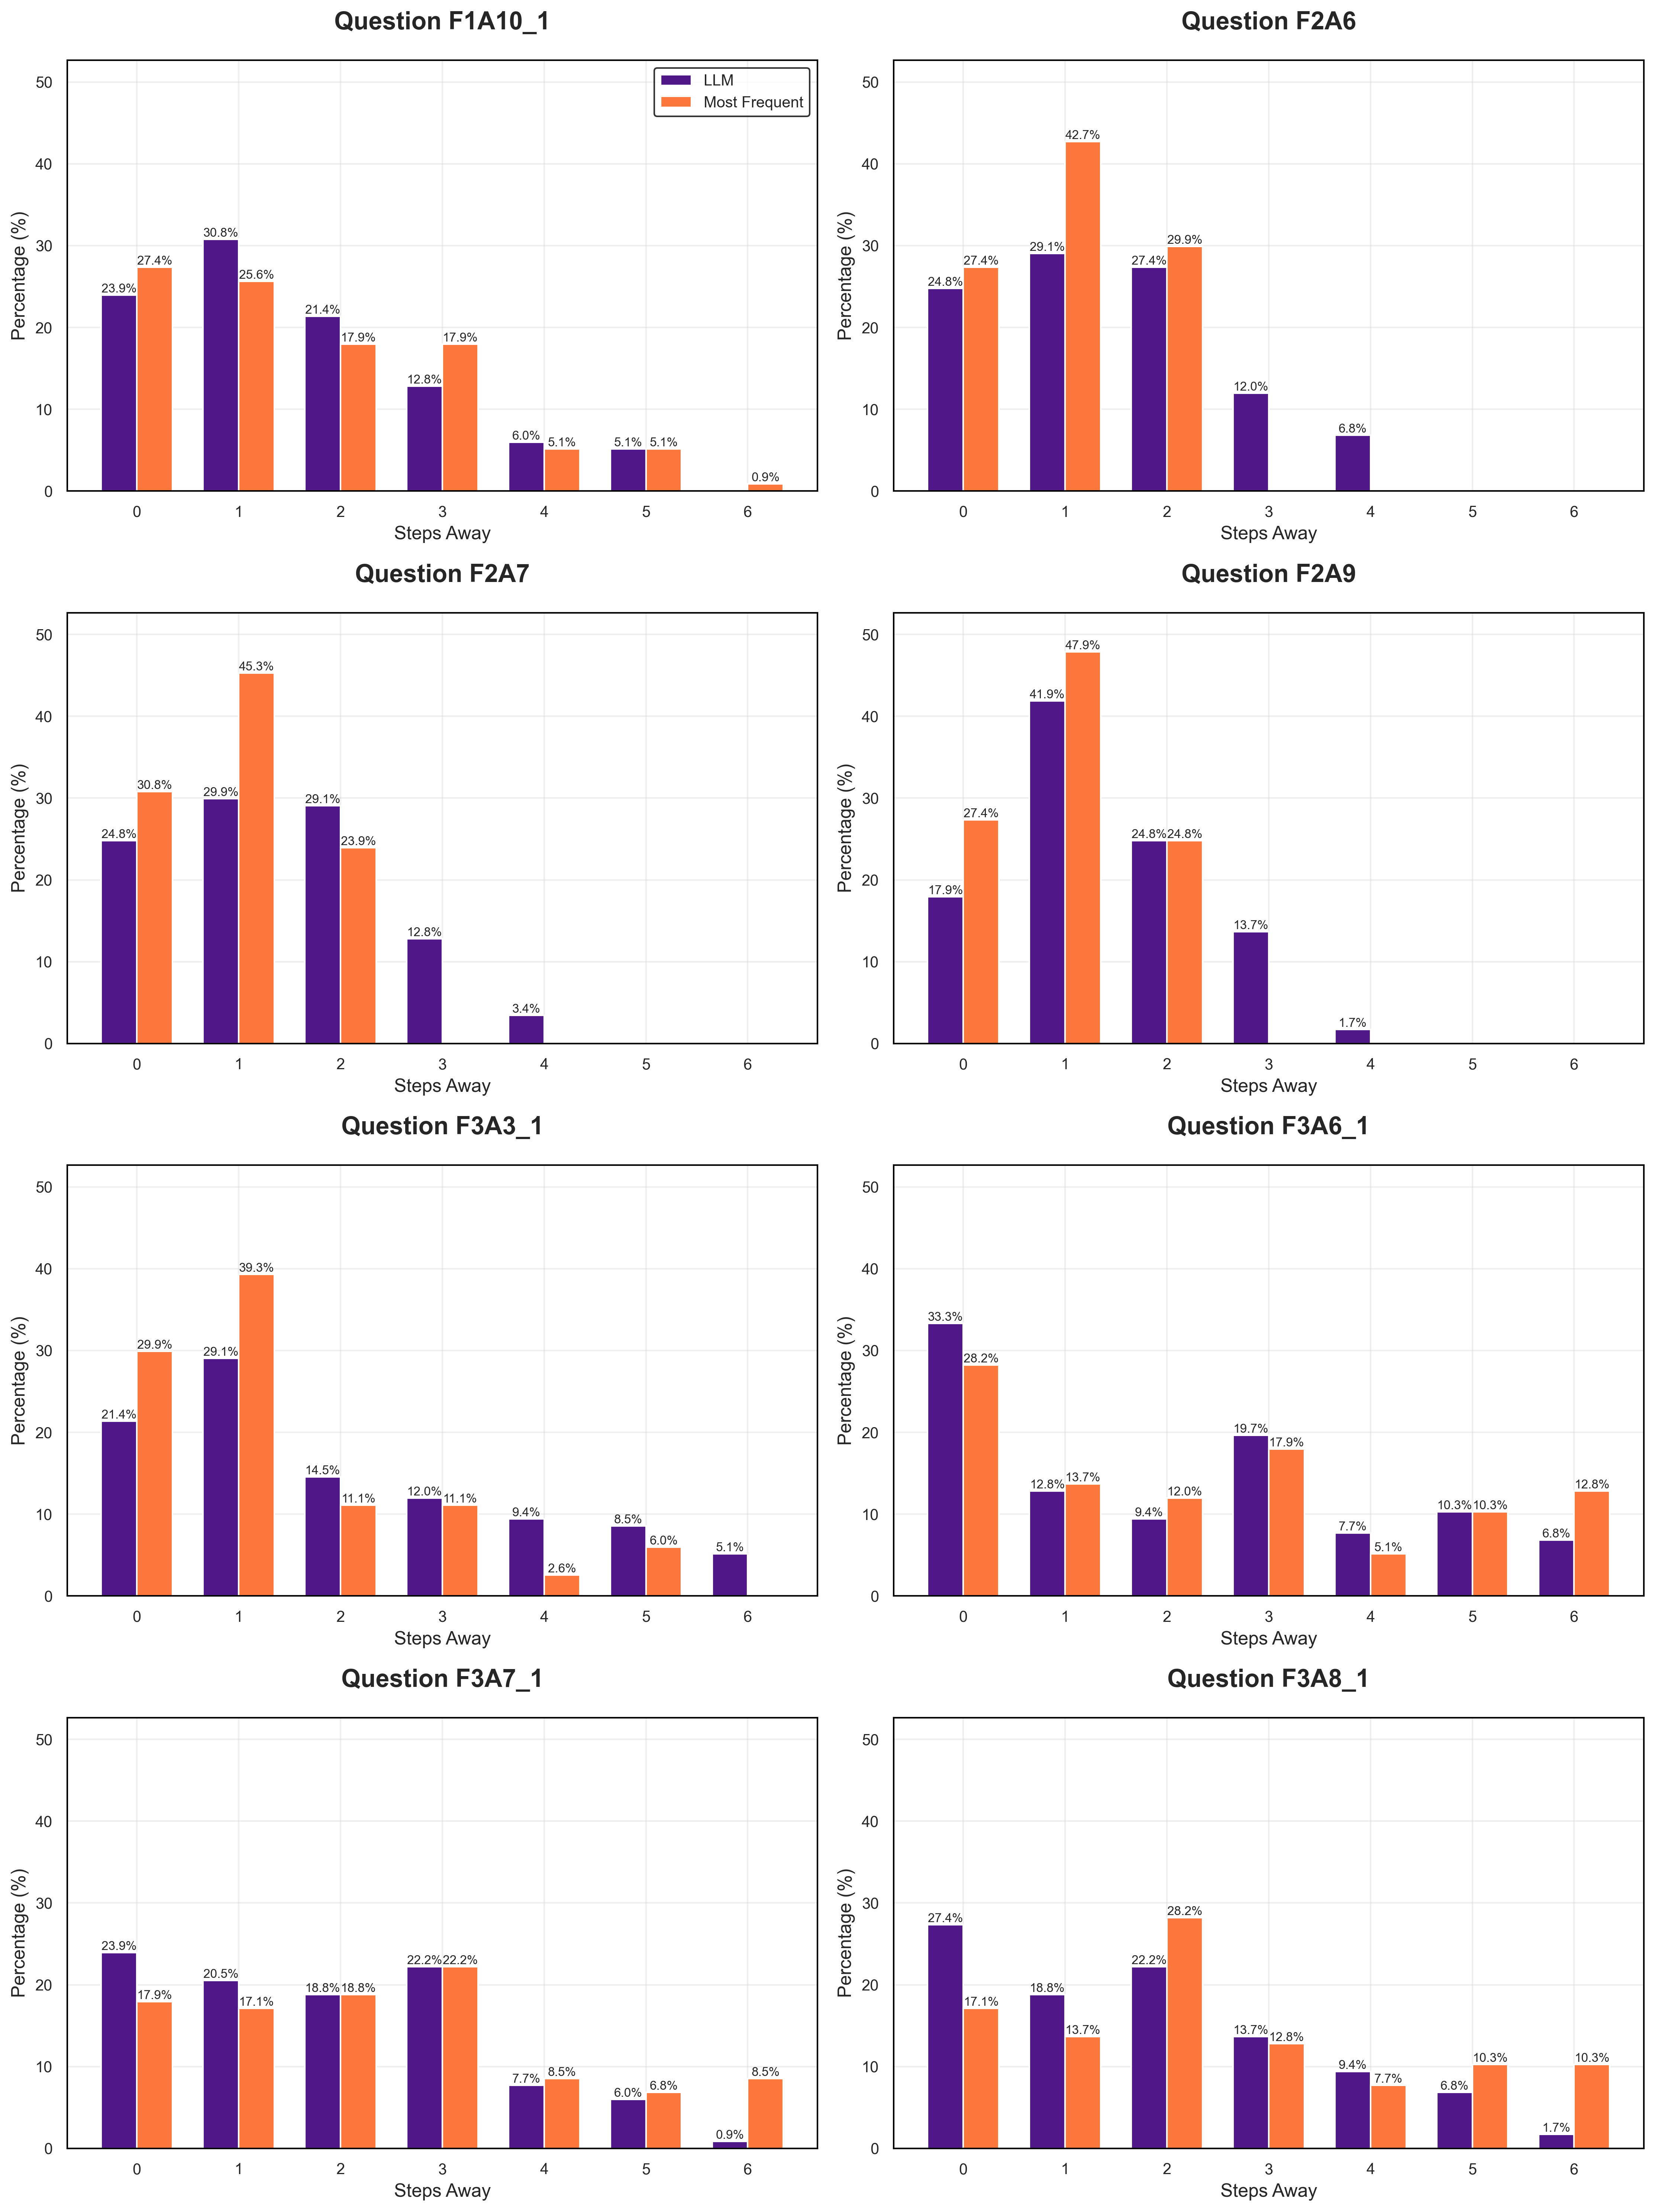


Question F1A10_1:

Normalized Counts (%):
         LLM  Most_Frequent
0  23.931624      27.350427
1  30.769231      25.641026
2  21.367521      17.948718
3  12.820513      17.948718
4   5.982906       5.128205
5   5.128205       5.128205
6   0.000000       0.854701

Question F2A6:

Normalized Counts (%):
         LLM  Most_Frequent
0  24.786325      27.350427
1  29.059829      42.735043
2  27.350427      29.914530
3  11.965812       0.000000
4   6.837607       0.000000
5   0.000000       0.000000
6   0.000000       0.000000

Question F2A7:

Normalized Counts (%):
         LLM  Most_Frequent
0  24.786325      30.769231
1  29.914530      45.299145
2  29.059829      23.931624
3  12.820513       0.000000
4   3.418803       0.000000
5   0.000000       0.000000
6   0.000000       0.000000

Question F2A9:

Normalized Counts (%):
         LLM  Most_Frequent
0  17.948718      27.350427
1  41.880342      47.863248
2  24.786325      24.786325
3  13.675214       0.000000
4   1.709402       0.0000

In [426]:
def plot_question_breakdown(question_normalized):
    """
    Create publication-ready subplots showing normalized comparisons for each question,
    with percentage labels and standardized y-axis range.
    """
    # Set the publication style
    PublicationStyle.set_style()
    
    # Create subplots
    n_questions = len(question_normalized)
    n_cols = 2
    n_rows = (n_questions + 1) // 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()
    
    # Find maximum percentage across all questions for y-axis standardization
    max_percentage = max(
        max(data['LLM'].max(), data['Most_Frequent'].max())
        for data in question_normalized.values()
    )
    # Add 10% padding to max_percentage for label space
    y_max = max_percentage * 1.1
    
    # Plot each question
    for idx, (question, data) in enumerate(question_normalized.items()):
        ax = axes[idx]
        x = np.arange(len(data.index))
        width = 0.35
        
        # Plot bars
        llm_bars = ax.bar(x - width/2, data['LLM'], width,
                         label='LLM', color=PublicationStyle.MAIN_COLORS['primary'])
        mf_bars = ax.bar(x + width/2, data['Most_Frequent'], width,
                        label='Most Frequent', color=PublicationStyle.MAIN_COLORS['secondary'])
        
        # Add percentage labels on top of bars
        def add_labels(bars):
            for bar in bars:
                height = bar.get_height()
                if height > 0:  # Only add label if bar has height
                    ax.text(bar.get_x() + bar.get_width()/2, height,
                           f'{height:.1f}%',
                           ha='center', va='bottom',
                           fontsize=PublicationStyle.FONT_SIZES['tiny'])
        
        add_labels(llm_bars)
        add_labels(mf_bars)
        
        # Customize axis
        PublicationStyle.format_axis(
            ax,
            title=f'Question {question}',
            xlabel='Steps Away',
            ylabel='Percentage (%)'
        )
        
        # Set standardized y-axis range
        ax.set_ylim(0, y_max)
        
        # Add grid
        ax.grid(True, alpha=0.3, axis='y')
        
        # Only add legend to first subplot
        if idx == 0:
            ax.legend()
    
    # Remove any empty subplots
    for idx in range(len(question_normalized), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    return fig, axes

# Generate the question-level comparisons
question_normalized, question_raw = create_question_level_comparison(step_wise_df)

# Create and show the question breakdown
fig_questions, axes_questions = plot_question_breakdown(question_normalized)
plt.show()

# Print question-by-question statistics
for question in question_normalized.keys():
    print(f"\nQuestion {question}:")
    print("\nNormalized Counts (%):")
    print(question_normalized[question])